In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

## Loading an example image
To start getting a sense about the lanes lets load one frame from the video

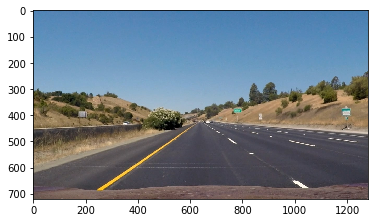

In [6]:
original = cv2.imread("example.jpg")
rgb = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)
plt.imshow(rgb)

## Color Space filtering
We want to get only the lanes in order to process and detect them.
Lets expriment different color spaces to see which color channel gives the best results based on the idea that the lanes colors are yellow and white

In [8]:
def show_images(img_list, img_labels, title, cols=2, fig_size=(15, 15), show_ticks=True):
    rows = len(img_list)
    cmap = None

    fig, axes = plt.subplots(rows, cols, figsize=fig_size)

    for i in range(0, rows):
        for j in range(0, cols):
            ax = axes[i, j] if rows > 1 else axes[j]
            img_name = img_labels[i][j]
            img = img_list[i][j]
            if len(img.shape) < 3 or img.shape[-1] < 3:
                cmap = "gray"
                img = np.reshape(img, (img.shape[0], img.shape[1]))

            if not show_ticks:
                ax.axis("off")

            ax.imshow(img, cmap=cmap)
            ax.set_title(img_name)

    fig.suptitle(title, fontsize=12, fontweight='bold', y=1)
    fig.tight_layout()
    plt.show()

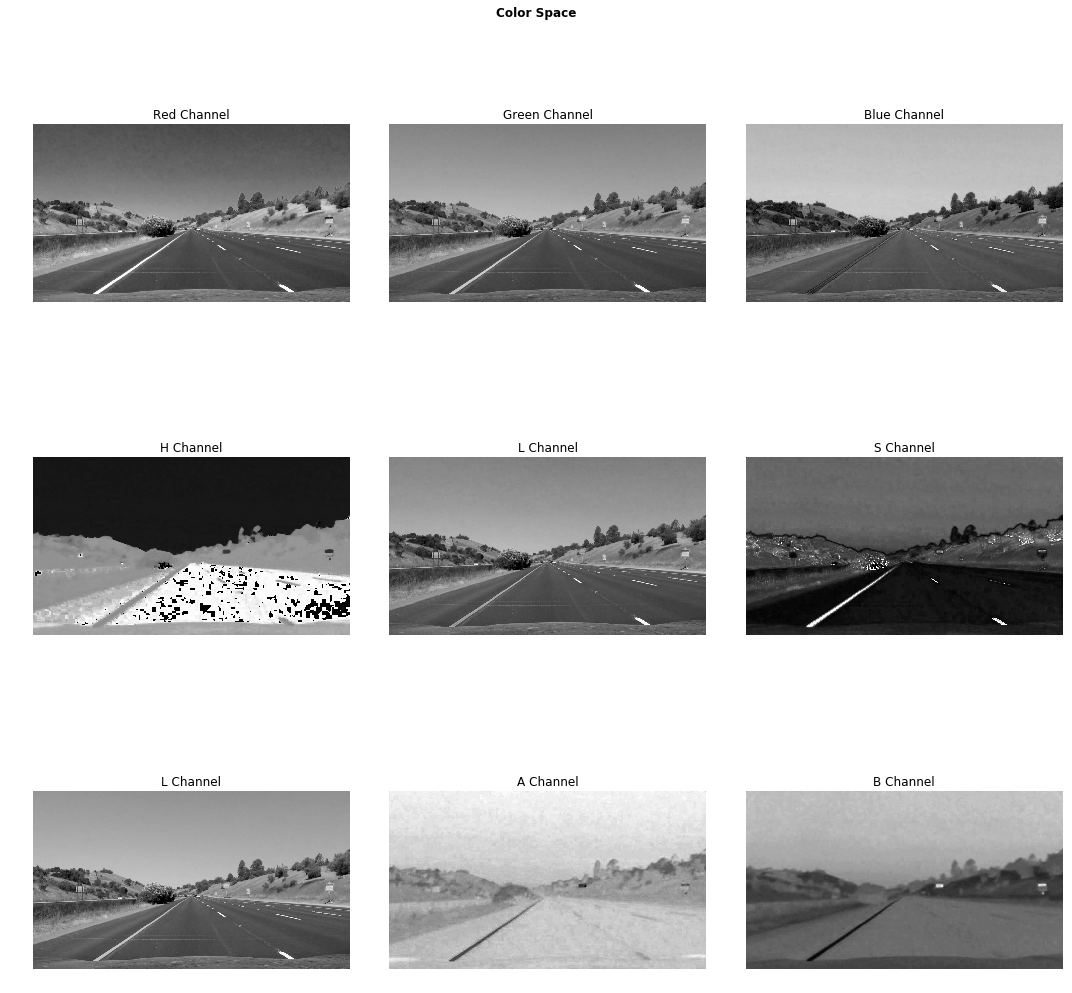

In [48]:
rgb = rgb
hls = cv2.cvtColor(original, cv2.COLOR_RGB2HLS)
lab = cv2.cvtColor(original, cv2.COLOR_RGB2LAB)

channels = np.asarray([
    [rgb[:, :, 0], rgb[:, :, 1], rgb[:, :, 2]],
    [hls[:, :, 0], hls[:, :, 1], hls[:, :, 2]],
    [lab[:, :, 0], lab[:, :, 1], lab[:, :, 2]],
])
labels = np.asarray([
    ["Red Channel", "Green Channel", "Blue Channel"],
    ["H Channel", "L Channel", "S Channel"],
    ["L Channel", "A Channel", "B Channel"],
])
show_images(channels, labels, "Color Space", 3, (15, 15), False)

In [48]:
def filter_threshold(img, min, max):
    """
    Takes an image and convert it to binary image
    based on the (min, max) thresholds
    :param img: the source image
    :param min: the min threshold
    :param max: the max threshold
    :return: the binary image based on the given thresholds
    """
    binary = np.zeros_like(img)
    binary[(img >= min) & (img <= max)] = 1
    return binary

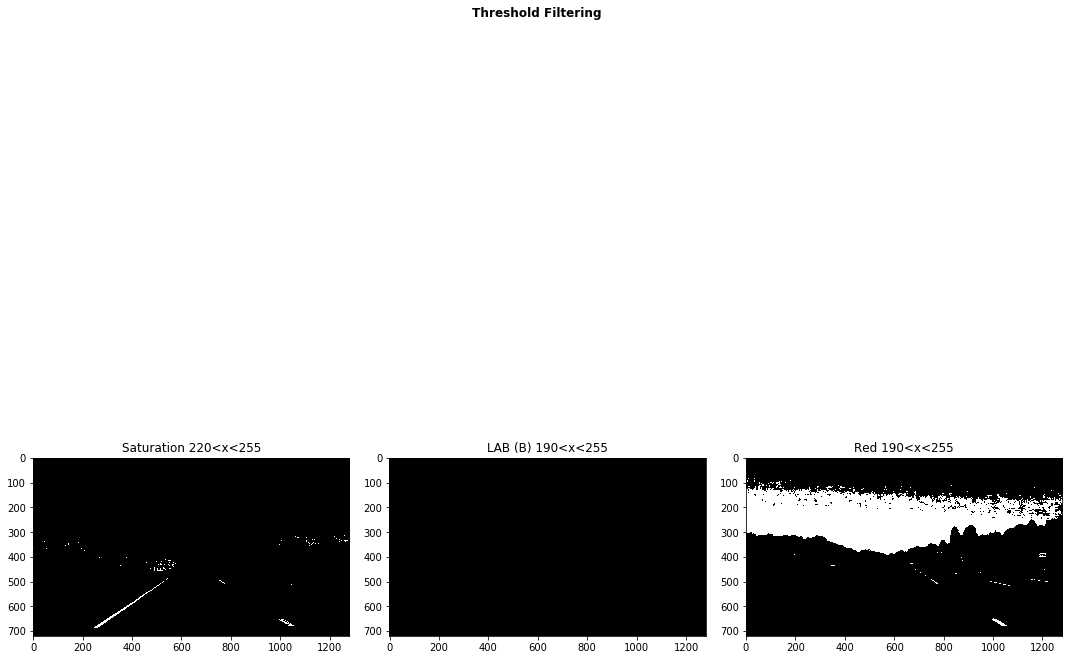

In [50]:
# Find the right thresholds:
s_bin = filter_threshold(hls[:, :, 2], 220, 255)
b_bin = filter_threshold(lab[:, :, 2], 190, 255)
r_bin = filter_threshold(rgb[:, :, 2], 190, 255)

f_channels = np.asarray([
    [s_bin, b_bin, r_bin]
])

f_labels = np.asarray([[
    "Saturation 220<x<255",
    "LAB (B) 190<x<255",
    "Red 190<x<255",
]])

show_images(f_channels, f_labels, "Threshold Filtering", cols=3)

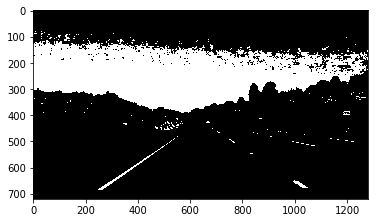

In [28]:
# Combine them to single binary image:
binary = np.zeros_like(rgb[:, :, 0])
binary[(s_bin == 1) | (b_bin == 1) | (r_bin == 1)] = 1
plt.imshow(binary, cmap='gray')

## Region of Intrest:
As you can see we only care about the lanes itself other things just create noise.
To overcome that we will use a mask shape as the road (the current lane) and apply it.

In [51]:
def mask_with_polygon(img, vertices):
    """
    Takes an image and a set of vertices that represents a polygon
    and mask the original image with the polygon in a way that only
    the polygon is shown on the output
    :param img: the source image
    :param vertices: array of points that represents a polygon
    :return: the image with the mask applied
    """

    mask = np.zeros_like(img)

    if len(img.shape) > 2:
        channel_count = img.shape[2]
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255

    # filling pixels inside the polygon defined by "vertices" with the fill color
    cv2.fillPoly(mask, [vertices], ignore_mask_color)

    # returning the image only where mask pixels are non-zero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

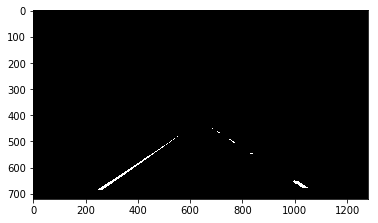

In [52]:
# Build the shape of the mask
height = binary.shape[0]
width = binary.shape[1]
center_x = 670
center_y = height / 2
x_top_factor = 0.04
x_lower_factor = 0.5
lower_left = [center_x - x_lower_factor * width, height]
lower_right = [center_x + x_lower_factor * width, height]
top_left = [center_x - x_top_factor * width, center_y + height / 10]
top_right = [center_x + x_top_factor * width, center_y + height / 10]

roi_matrix = np.int32([
    lower_left, top_left, top_right, lower_right
])

# Apply the mask
roi = mask_with_polygon(binary, roi_matrix)
plt.imshow(roi, cmap='gray')

Cool, now we have the shape of the lanes !

## Going to birds-eye view
As we now have the lanes, their layour is in a 3d space, we would like to look at the road from above (just like a bird)
There is a cool trick called perspective wrap that allows us to do it, we basically take a trapeziod that matches the road shape and change its perspective

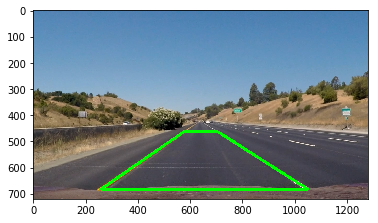

In [53]:
# Finding the trapezoid:
image_copy = np.copy(rgb)

trapezoid = np.asarray([
    [707, 464],
    [575, 464],
    [258, 682],
    [1049, 682]
])

cv2.polylines(image_copy, [trapezoid], True, (0, 255, 0), 10)

plt.imshow(image_copy)

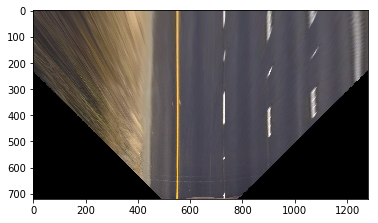

In [62]:
# Now we use that trapezoid to calc the perspective wrap:
src = np.float32([(575, 464),
                  (707, 464),
                  (258, 682),
                  (1049, 682)])

dst = np.float32([(550, 0),
                  (width - 550, 0),
                  (550, height),
                  (width - 550, height)])

M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)

wrapped = cv2.warpPerspective(rgb, M, (width, height), flags=cv2.INTER_LINEAR)
plt.imshow(wrapped)

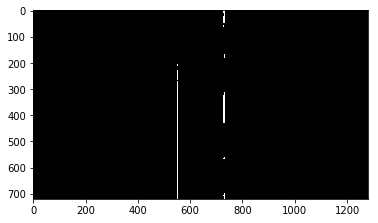

In [64]:
# WOW, this is a cool trick, lets apply it to our roi_image
wrapped_roi = cv2.warpPerspective(roi, M, (width, height), flags=cv2.INTER_LINEAR)
plt.imshow(wrapped_roi, cmap='gray')

## Detecting the actual lane lines
We reached to a crucial step, basically we've filtered the raw image into something binary that contains only the lane lines.

Now we need to apply some math to get the actual lanes

### Histogram
The histogram show 1 to 1 correlation with lanes lines so we will use it later to detect where to plot the "detected" lanes base on a threshold for each one of the spikes

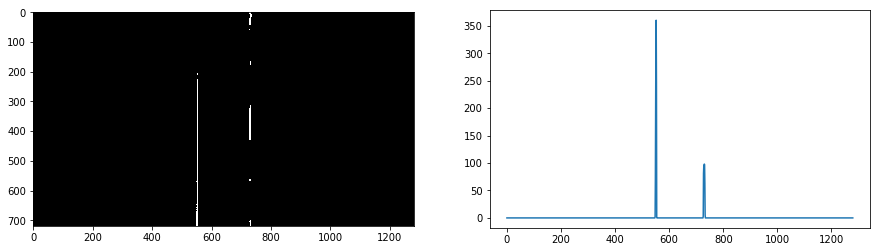

In [96]:
# Get the histogram of the wrapped image:
histogram = np.sum(wrapped_roi[wrapped_roi.shape[0] // 2:, :], axis=0)

fig, ax = plt.subplots(1, 2, figsize=(15, 4))
ax[0].imshow(wrapped_roi, cmap='gray')
ax[1].plot(histogram)

plt.show()

### Windowing the lane
Now we can split the detected lines in histogram into windows, where each window checks if a line (meaning ones) is within this window this way we can overcome missing parts in the original lines.

(720, 0)

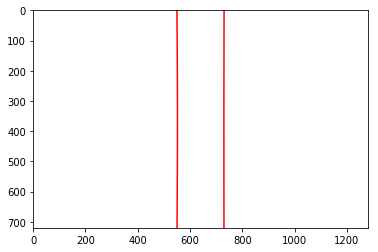

In [124]:
from processors import sliding_window

(left_fit, right_fit, left_lane_idx, right_lane_idx, visualization_data) = \
    sliding_window(wrapped_roi, 12)

lane_y = np.linspace(0, wrapped_roi.shape[0] - 1, wrapped_roi.shape[0])
left_lane_x = left_fit[0] * lane_y ** 2 + left_fit[1] * lane_y + left_fit[2]
right_lane_x = right_fit[0] * lane_y ** 2 + right_fit[1] * lane_y + right_fit[2]

plt.plot(left_lane_x, lane_y, color='red')
plt.plot(right_lane_x, lane_y, color='red')
plt.xlim(0, 1280)
plt.ylim(720, 0)

## Combining it all
With the help of some state we can safely detect, draw and measure the depratrue of the lane.

This class will do all the processing required (including a polynomial approx on curved lines) to complete the objectives
 

In [126]:
from processors import to_hls, to_lab, filter, sliding_window, lane_departure, lane_polyfit


class LaneDepartureDetector:
    """
    A class that will detect lane departure from a set of images (frames of video)
    """

    def __init__(self, perspective_src, perspective_dst, roi_matrix):
        """
        Init the class
        :param perspective_src: the source perspective wrap points (should match a trapezoid that matches the lane shape
        :param perspective_dst: the destination perspective wrap points
        :param roi_matrix: the region of interest mask
        """
        self.left_lane = Line()
        self.right_lane = Line()
        self.M = cv2.getPerspectiveTransform(perspective_src, perspective_dst)
        self.Minv = cv2.getPerspectiveTransform(perspective_dst, perspective_src)
        self.roi_matrix = roi_matrix

    def process_image(self, image):
        """
        Process a single frame of the image
        :param image: the source image
        :return: the image with discovered lanes + departure
        """
        h, w = image.shape[:2]

        # Apply some smoothing:
        blurred = cv2.blur(image, (15, 15))

        # Create the binary image of the lanes based on the color space:
        hls = to_hls(image)
        lab = to_lab(image)
        s_bin = filter(hls[:, :, 2], 220, 255)
        b_bin = filter(lab[:, :, 2], 190, 255)
        r_bin = filter(image[:, :, 2], 190, 255)
        binary = np.zeros_like(blurred[:, :, 0])
        binary[(s_bin == 1) | (b_bin == 1) | (r_bin == 1)] = 1

        # Find the Region of Interest:
        roi = mask_with_polygon(binary, self.roi_matrix)

        # Wrap the perspective into birds-eye view
        wrapped = cv2.warpPerspective(roi, self.M, (w, h), flags=cv2.INTER_LINEAR)

        (processed_image, departure) = self._find_lanes(image, wrapped)
        return processed_image, departure

    @staticmethod
    def _draw_data(original_img, center_dist):
        new_img = np.copy(original_img)

        font = cv2.FONT_HERSHEY_DUPLEX
        direction = ''

        if center_dist > 0:
            direction = 'right'
        elif center_dist < 0:
            direction = 'left'

        abs_center_dist = abs(center_dist)
        text = '{:04.3f}'.format(abs_center_dist) + 'm ' + direction + ' of center'
        cv2.putText(new_img, text, (40, 70), font, 1.5, (255, 255, 255), 2, cv2.LINE_AA)

        return new_img

    def _find_lanes(self, orig_img, img):
        new_img = np.copy(orig_img)
        d_center = 0

        if not self.left_lane.detected or not self.right_lane.detected:
            l_fit, r_fit, l_lane_inds, r_lane_inds, _ = sliding_window(img)
        else:
            l_fit, r_fit, l_lane_inds, r_lane_inds = lane_polyfit(img, self.left_lane.best_fit,
                                                                  self.right_lane.best_fit)

        # invalidate both fits if the difference in their x-intercepts isn't around 350 px (+/- 100 px)
        if l_fit is not None and r_fit is not None:
            # calculate x-intercept (bottom of image, x=image_height) for fits
            h = img.shape[0]
            l_fit_x_int = l_fit[0] * h ** 2 + l_fit[1] * h + l_fit[2]
            r_fit_x_int = r_fit[0] * h ** 2 + r_fit[1] * h + r_fit[2]
            x_int_diff = abs(r_fit_x_int - l_fit_x_int)
            if abs(350 - x_int_diff) > 200:
                l_fit = None
                r_fit = None

        self.left_lane.add_fit(l_fit, l_lane_inds)
        self.right_lane.add_fit(r_fit, r_lane_inds)

        # draw the current best fit if it exists
        if self.left_lane.best_fit is not None and self.right_lane.best_fit is not None:
            img_out1 = self._draw_lane(new_img, img, self.left_lane.best_fit, self.right_lane.best_fit)
            d_center = lane_departure(img, self.left_lane.best_fit, self.right_lane.best_fit)
            img_out = self._draw_data(img_out1, d_center)
        else:
            img_out = new_img

        return img_out, d_center

    def _draw_lane(self, original_img, binary_img, l_fit, r_fit):
        new_img = np.copy(original_img)
        if l_fit is None or r_fit is None:
            return original_img

        # Create an image to draw the lines on
        warp_zero = np.zeros_like(binary_img).astype(np.uint8)
        color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

        h, w = binary_img.shape
        ploty = np.linspace(0, h - 1, num=h)  # to cover same y-range as image
        left_fitx = l_fit[0] * ploty ** 2 + l_fit[1] * ploty + l_fit[2]
        right_fitx = r_fit[0] * ploty ** 2 + r_fit[1] * ploty + r_fit[2]

        # Recast the x and y points into usable format for cv2.fillPoly()
        pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
        pts = np.hstack((pts_left, pts_right))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(color_warp, np.int_([pts]), (200, 0, 200))
        cv2.polylines(color_warp, np.int32([pts_left]), isClosed=False, color=(0, 0, 255), thickness=15)
        cv2.polylines(color_warp, np.int32([pts_right]), isClosed=False, color=(0, 0, 255), thickness=15)

        # Warp the blank back to original image space using inverse perspective matrix (Minv)
        newwarp = cv2.warpPerspective(color_warp, self.Minv, (w, h))

        # Combine the result with the original image
        result = cv2.addWeighted(new_img, 1, newwarp, 0.5, 0)
        return result


class Line:
    def __init__(self):
        self.detected = False  # was the line detected in the last iteration?
        self.recent_xfitted = []  # x values of the last n fits of the line
        self.bestx = None  # average x values of the fitted line over the last n iterations
        self.best_fit = None  # polynomial coefficients averaged over the last n iterations
        self.current_fit = []  # polynomial coefficients for the most recent fit
        self.radius_of_curvature = None  # radius of curvature of the line in some units
        self.line_base_pos = None  # distance in meters of vehicle center from the line
        self.diffs = np.array([0, 0, 0], dtype='float')  # difference in fit coefficients between last and new fits
        self.px_count = None  # number of detected pixels

    def add_fit(self, fit, inds):
        if fit is not None:  # add the found fit to the line, up to n
            if self.best_fit is not None:
                self.diffs = abs(fit - self.best_fit)

            if (self.diffs[0] > 0.001 or self.diffs[1] > 1.0 or self.diffs[2] > 100.) and \
                            len(self.current_fit) > 0:
                self.detected = False  # No fit found
            else:
                self.detected = True
                self.px_count = np.count_nonzero(inds)
                self.current_fit.append(fit)

                if len(self.current_fit) > 5:
                    self.current_fit = self.current_fit[len(self.current_fit) - 5:]

                self.best_fit = np.average(self.current_fit, axis=0)
        else:
            self.detected = False
            if len(self.current_fit) > 0:
                self.current_fit = self.current_fit[:len(self.current_fit) - 1]
            if len(self.current_fit) > 0:
                self.best_fit = np.average(self.current_fit, axis=0)

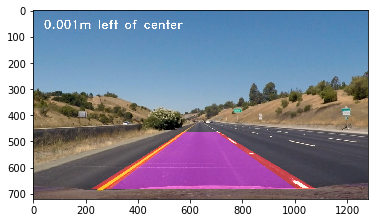

In [131]:
import glob

# Init the detector
detector = LaneDepartureDetector(src, dst, roi_matrix)

# Load a set of snapshots from the original video:
before_images = glob.glob("out/before*.jpg")

# Append the result to a list:
results = list()
for image in before_images:
    results.append(detector.process_image(original))

# Show the processed image:
out_image = cv2.cvtColor(results[2][0], cv2.COLOR_BGR2RGB)
plt.imshow(out_image)

In [134]:
print "Lane Departure: " + str(results[2][1]) + " meters"

Lane Departure: -0.0011403256855899036 meters


In [139]:
from detector import LaneDepartureDetector
from moviepy.editor import VideoFileClip

# Make a video out of it:

def create_config(height, width):
    center_x = 670
    center_y = height / 2
    x_top_factor = 0.04
    x_lower_factor = 0.5
    lower_left = [center_x - x_lower_factor * width, height]
    lower_right = [center_x + x_lower_factor * width, height]
    top_left = [center_x - x_top_factor * width, center_y + height / 10]
    top_right = [center_x + x_top_factor * width, center_y + height / 10]

    roi_matrix = np.int32([
        lower_left, top_left, top_right, lower_right
    ])

    src = np.float32([(575, 464),
                      (707, 464),
                      (258, 682),
                      (1049, 682)])

    dst = np.float32([(550, 0),
                      (width - 500, 0),
                      (500, height),
                      (width - 550, height)])

    return src, dst, roi_matrix


(src, dst, roi) = create_config(720, 1280)
detector = LaneDepartureDetector(src, dst, roi)


def process_image(image):
    return detector.process_image(image)[0]

video_output1 = './out/lanes_processed.mp4'
video_input1 = VideoFileClip('lanes.mp4')
processed_video = video_input1.fl_image(process_image)
%time processed_video.write_videofile(video_output1, audio=False)

[MoviePy] >>>> Building video ./out/lanes_processed.mp4


[MoviePy] Writing video ./out/lanes_processed.mp4


  0%|          | 0/1261 [00:00<?, ?it/s]

  0%|          | 1/1261 [00:00<02:24,  8.70it/s]

  0%|          | 3/1261 [00:00<02:06,  9.95it/s]

  0%|          | 5/1261 [00:00<01:53, 11.06it/s]

  1%|          | 7/1261 [00:00<01:44, 11.98it/s]

  1%|          | 9/1261 [00:00<01:36, 13.01it/s]

  1%|          | 11/1261 [00:00<01:44, 11.95it/s]

  1%|          | 13/1261 [00:01<01:44, 11.94it/s]

  1%|          | 15/1261 [00:01<01:35, 13.11it/s]

  1%|▏         | 17/1261 [00:01<01:27, 14.18it/s]

  2%|▏         | 19/1261 [00:01<01:23, 14.96it/s]

  2%|▏         | 21/1261 [00:01<01:19, 15.60it/s]

  2%|▏         | 23/1261 [00:01<01:15, 16.32it/s]

  2%|▏         | 25/1261 [00:01<01:13, 16.80it/s]

  2%|▏         | 27/1261 [00:01<01:29, 13.78it/s]

  2%|▏         | 29/1261 [00:02<01:28, 13.94it/s]

  2%|▏         | 31/1261 [00:02<01:34, 12.95it/s]

  3%|▎         | 33/1261 [00:02<01:28, 13.94it/s]

  3%|▎         | 35/1261 [00:02<01:23, 14.68it/s]

  3%|▎         | 37/1261 [00:02<01:20, 15.21it/s]

  3%|▎         | 39/1261 [00:02<01:23, 14.57it/s]

  3%|▎         | 41/1261 [00:02<01:18, 15.47it/s]

  3%|▎         | 43/1261 [00:02<01:16, 15.96it/s]

  4%|▎         | 45/1261 [00:03<01:15, 16.11it/s]

  4%|▎         | 47/1261 [00:03<01:22, 14.63it/s]

  4%|▍         | 49/1261 [00:03<01:22, 14.61it/s]

  4%|▍         | 51/1261 [00:03<01:39, 12.20it/s]

  4%|▍         | 53/1261 [00:03<01:36, 12.53it/s]

  4%|▍         | 55/1261 [00:03<01:33, 12.90it/s]

  5%|▍         | 57/1261 [00:04<01:34, 12.72it/s]

  5%|▍         | 59/1261 [00:04<01:55, 10.41it/s]

  5%|▍         | 61/1261 [00:04<01:51, 10.79it/s]

  5%|▍         | 63/1261 [00:04<01:56, 10.27it/s]

  5%|▌         | 65/1261 [00:04<01:52, 10.64it/s]

  5%|▌         | 67/1261 [00:05<01:46, 11.22it/s]

  5%|▌         | 69/1261 [00:05<01:40, 11.85it/s]

  6%|▌         | 71/1261 [00:05<01:38, 12.14it/s]

  6%|▌         | 73/1261 [00:05<01:36, 12.37it/s]

  6%|▌         | 75/1261 [00:05<01:34, 12.60it/s]

  6%|▌         | 77/1261 [00:05<01:35, 12.44it/s]

  6%|▋         | 79/1261 [00:05<01:34, 12.51it/s]

  6%|▋         | 81/1261 [00:06<01:40, 11.76it/s]

  7%|▋         | 83/1261 [00:06<01:35, 12.30it/s]

  7%|▋         | 85/1261 [00:06<01:37, 12.10it/s]

  7%|▋         | 87/1261 [00:06<01:55, 10.18it/s]

  7%|▋         | 89/1261 [00:07<02:07,  9.22it/s]

  7%|▋         | 90/1261 [00:07<02:11,  8.91it/s]

  7%|▋         | 91/1261 [00:07<02:29,  7.81it/s]

  7%|▋         | 92/1261 [00:07<02:40,  7.29it/s]

  7%|▋         | 93/1261 [00:07<02:37,  7.39it/s]

  8%|▊         | 95/1261 [00:07<02:19,  8.38it/s]

  8%|▊         | 96/1261 [00:07<02:38,  7.36it/s]

  8%|▊         | 98/1261 [00:08<02:30,  7.71it/s]

  8%|▊         | 100/1261 [00:08<02:10,  8.92it/s]

  8%|▊         | 102/1261 [00:08<01:57,  9.83it/s]

  8%|▊         | 104/1261 [00:08<01:48, 10.67it/s]

  8%|▊         | 106/1261 [00:08<01:47, 10.79it/s]

  9%|▊         | 108/1261 [00:08<01:43, 11.14it/s]

  9%|▊         | 110/1261 [00:09<01:43, 11.16it/s]

  9%|▉         | 112/1261 [00:09<01:49, 10.50it/s]

  9%|▉         | 114/1261 [00:09<01:52, 10.22it/s]

  9%|▉         | 116/1261 [00:09<01:49, 10.47it/s]

  9%|▉         | 118/1261 [00:09<01:58,  9.63it/s]

 10%|▉         | 120/1261 [00:10<01:49, 10.40it/s]

 10%|▉         | 122/1261 [00:10<01:54,  9.98it/s]

 10%|▉         | 124/1261 [00:10<01:54,  9.95it/s]

 10%|▉         | 126/1261 [00:10<01:51, 10.20it/s]

 10%|█         | 128/1261 [00:10<01:44, 10.84it/s]

 10%|█         | 130/1261 [00:11<01:51, 10.14it/s]

 10%|█         | 132/1261 [00:11<01:53,  9.90it/s]

 11%|█         | 134/1261 [00:11<01:56,  9.63it/s]

 11%|█         | 136/1261 [00:11<01:53,  9.94it/s]

 11%|█         | 138/1261 [00:11<01:51, 10.09it/s]

 11%|█         | 140/1261 [00:12<01:47, 10.39it/s]

 11%|█▏        | 142/1261 [00:12<01:43, 10.78it/s]

 11%|█▏        | 144/1261 [00:12<01:39, 11.28it/s]

 12%|█▏        | 146/1261 [00:12<01:55,  9.63it/s]

 12%|█▏        | 148/1261 [00:13<02:14,  8.28it/s]

 12%|█▏        | 149/1261 [00:13<02:35,  7.14it/s]

 12%|█▏        | 150/1261 [00:13<02:41,  6.87it/s]

 12%|█▏        | 151/1261 [00:13<03:11,  5.80it/s]

 12%|█▏        | 152/1261 [00:13<03:03,  6.05it/s]

 12%|█▏        | 153/1261 [00:13<02:45,  6.71it/s]

 12%|█▏        | 154/1261 [00:14<02:47,  6.62it/s]

 12%|█▏        | 156/1261 [00:14<02:22,  7.77it/s]

 13%|█▎        | 158/1261 [00:14<02:12,  8.32it/s]

 13%|█▎        | 159/1261 [00:14<02:08,  8.60it/s]

 13%|█▎        | 160/1261 [00:14<02:03,  8.94it/s]

 13%|█▎        | 161/1261 [00:14<02:09,  8.47it/s]

 13%|█▎        | 162/1261 [00:14<02:04,  8.83it/s]

 13%|█▎        | 164/1261 [00:15<02:00,  9.13it/s]

 13%|█▎        | 165/1261 [00:15<01:57,  9.32it/s]

 13%|█▎        | 167/1261 [00:15<01:50,  9.92it/s]

 13%|█▎        | 169/1261 [00:15<01:50,  9.93it/s]

 14%|█▎        | 171/1261 [00:15<01:45, 10.33it/s]

 14%|█▎        | 173/1261 [00:15<01:44, 10.38it/s]

 14%|█▍        | 175/1261 [00:16<01:40, 10.81it/s]

 14%|█▍        | 177/1261 [00:16<01:41, 10.70it/s]

 14%|█▍        | 179/1261 [00:16<01:37, 11.11it/s]

 14%|█▍        | 181/1261 [00:16<01:37, 11.08it/s]

 15%|█▍        | 183/1261 [00:16<01:28, 12.19it/s]

 15%|█▍        | 185/1261 [00:16<01:32, 11.63it/s]

 15%|█▍        | 187/1261 [00:17<01:36, 11.17it/s]

 15%|█▍        | 189/1261 [00:17<01:34, 11.29it/s]

 15%|█▌        | 191/1261 [00:17<01:27, 12.22it/s]

 15%|█▌        | 193/1261 [00:17<01:29, 11.98it/s]

 15%|█▌        | 195/1261 [00:17<01:22, 12.88it/s]

 16%|█▌        | 197/1261 [00:17<01:24, 12.56it/s]

 16%|█▌        | 199/1261 [00:18<01:33, 11.40it/s]

 16%|█▌        | 201/1261 [00:18<01:33, 11.31it/s]

 16%|█▌        | 203/1261 [00:18<01:31, 11.53it/s]

 16%|█▋        | 205/1261 [00:18<01:43, 10.19it/s]

 16%|█▋        | 207/1261 [00:18<01:42, 10.27it/s]

 17%|█▋        | 209/1261 [00:19<01:51,  9.47it/s]

 17%|█▋        | 210/1261 [00:19<02:04,  8.41it/s]

 17%|█▋        | 211/1261 [00:19<02:05,  8.39it/s]

 17%|█▋        | 212/1261 [00:19<02:23,  7.29it/s]

 17%|█▋        | 213/1261 [00:19<02:47,  6.25it/s]

 17%|█▋        | 214/1261 [00:19<02:37,  6.65it/s]

 17%|█▋        | 215/1261 [00:20<02:22,  7.33it/s]

 17%|█▋        | 216/1261 [00:20<02:16,  7.66it/s]

 17%|█▋        | 217/1261 [00:20<02:15,  7.73it/s]

 17%|█▋        | 218/1261 [00:20<02:06,  8.26it/s]

 17%|█▋        | 219/1261 [00:20<02:00,  8.68it/s]

 17%|█▋        | 220/1261 [00:20<01:58,  8.78it/s]

 18%|█▊        | 221/1261 [00:20<02:03,  8.40it/s]

 18%|█▊        | 222/1261 [00:20<02:02,  8.49it/s]

 18%|█▊        | 223/1261 [00:20<02:01,  8.51it/s]

 18%|█▊        | 224/1261 [00:21<02:02,  8.43it/s]

 18%|█▊        | 225/1261 [00:21<02:02,  8.49it/s]

 18%|█▊        | 226/1261 [00:21<02:08,  8.06it/s]

 18%|█▊        | 227/1261 [00:21<02:04,  8.31it/s]

 18%|█▊        | 228/1261 [00:21<02:07,  8.11it/s]

 18%|█▊        | 229/1261 [00:21<02:02,  8.45it/s]

 18%|█▊        | 230/1261 [00:21<02:12,  7.79it/s]

 18%|█▊        | 232/1261 [00:22<02:00,  8.52it/s]

 18%|█▊        | 233/1261 [00:22<01:58,  8.68it/s]

 19%|█▊        | 234/1261 [00:22<01:55,  8.89it/s]

 19%|█▊        | 236/1261 [00:22<01:46,  9.59it/s]

 19%|█▉        | 237/1261 [00:22<01:46,  9.66it/s]

 19%|█▉        | 239/1261 [00:22<01:37, 10.45it/s]

 19%|█▉        | 241/1261 [00:22<01:34, 10.78it/s]

 19%|█▉        | 243/1261 [00:22<01:28, 11.49it/s]

 19%|█▉        | 245/1261 [00:23<01:26, 11.77it/s]

 20%|█▉        | 247/1261 [00:23<01:26, 11.71it/s]

 20%|█▉        | 249/1261 [00:23<01:30, 11.19it/s]

 20%|█▉        | 251/1261 [00:23<01:28, 11.46it/s]

 20%|██        | 253/1261 [00:23<01:33, 10.75it/s]

 20%|██        | 255/1261 [00:24<01:36, 10.46it/s]

 20%|██        | 257/1261 [00:24<01:37, 10.31it/s]

 21%|██        | 259/1261 [00:24<01:47,  9.34it/s]

 21%|██        | 261/1261 [00:24<01:39, 10.02it/s]

 21%|██        | 263/1261 [00:24<01:42,  9.73it/s]

 21%|██        | 264/1261 [00:25<01:48,  9.20it/s]

 21%|██        | 266/1261 [00:25<01:41,  9.85it/s]

 21%|██▏       | 268/1261 [00:25<01:37, 10.18it/s]

 21%|██▏       | 270/1261 [00:25<01:34, 10.50it/s]

 22%|██▏       | 272/1261 [00:25<01:30, 10.97it/s]

 22%|██▏       | 274/1261 [00:25<01:31, 10.78it/s]

 22%|██▏       | 276/1261 [00:26<01:42,  9.65it/s]

 22%|██▏       | 277/1261 [00:26<01:46,  9.27it/s]

 22%|██▏       | 279/1261 [00:26<01:35, 10.23it/s]

 22%|██▏       | 281/1261 [00:26<01:34, 10.41it/s]

 22%|██▏       | 283/1261 [00:26<01:26, 11.36it/s]

 23%|██▎       | 285/1261 [00:26<01:24, 11.56it/s]

 23%|██▎       | 287/1261 [00:27<01:21, 11.96it/s]

 23%|██▎       | 289/1261 [00:27<01:23, 11.61it/s]

 23%|██▎       | 291/1261 [00:27<01:26, 11.20it/s]

 23%|██▎       | 293/1261 [00:27<01:27, 11.10it/s]

 23%|██▎       | 295/1261 [00:27<01:28, 10.97it/s]

 24%|██▎       | 297/1261 [00:27<01:22, 11.70it/s]

 24%|██▎       | 299/1261 [00:28<01:18, 12.29it/s]

 24%|██▍       | 301/1261 [00:28<01:15, 12.79it/s]

 24%|██▍       | 303/1261 [00:28<01:14, 12.79it/s]

 24%|██▍       | 305/1261 [00:28<01:13, 13.04it/s]

 24%|██▍       | 307/1261 [00:28<01:15, 12.59it/s]

 25%|██▍       | 309/1261 [00:28<01:14, 12.80it/s]

 25%|██▍       | 311/1261 [00:29<01:14, 12.76it/s]

 25%|██▍       | 313/1261 [00:29<01:12, 13.07it/s]

 25%|██▍       | 315/1261 [00:29<01:12, 13.02it/s]

 25%|██▌       | 317/1261 [00:29<01:12, 12.97it/s]

 25%|██▌       | 319/1261 [00:29<01:13, 12.84it/s]

 25%|██▌       | 321/1261 [00:29<01:11, 13.18it/s]

 26%|██▌       | 323/1261 [00:29<01:12, 13.02it/s]

 26%|██▌       | 325/1261 [00:30<01:10, 13.34it/s]

 26%|██▌       | 327/1261 [00:30<01:16, 12.27it/s]

 26%|██▌       | 329/1261 [00:30<01:13, 12.68it/s]

 26%|██▌       | 331/1261 [00:30<01:12, 12.79it/s]

 26%|██▋       | 333/1261 [00:30<01:10, 13.14it/s]

 27%|██▋       | 335/1261 [00:30<01:10, 13.14it/s]

 27%|██▋       | 337/1261 [00:31<01:09, 13.32it/s]

 27%|██▋       | 339/1261 [00:31<01:24, 10.90it/s]

 27%|██▋       | 341/1261 [00:31<01:22, 11.16it/s]

 27%|██▋       | 343/1261 [00:31<01:21, 11.21it/s]

 27%|██▋       | 345/1261 [00:31<01:18, 11.62it/s]

 28%|██▊       | 347/1261 [00:31<01:20, 11.34it/s]

 28%|██▊       | 349/1261 [00:32<01:32,  9.89it/s]

 28%|██▊       | 351/1261 [00:32<01:31,  9.98it/s]

 28%|██▊       | 353/1261 [00:32<01:24, 10.76it/s]

 28%|██▊       | 355/1261 [00:32<01:22, 11.04it/s]

 28%|██▊       | 357/1261 [00:32<01:19, 11.43it/s]

 28%|██▊       | 359/1261 [00:33<01:19, 11.39it/s]

 29%|██▊       | 361/1261 [00:33<01:15, 11.86it/s]

 29%|██▉       | 363/1261 [00:33<01:19, 11.24it/s]

 29%|██▉       | 365/1261 [00:33<01:18, 11.37it/s]

 29%|██▉       | 367/1261 [00:33<01:17, 11.54it/s]

 29%|██▉       | 369/1261 [00:33<01:19, 11.15it/s]

 29%|██▉       | 371/1261 [00:34<01:28, 10.07it/s]

 30%|██▉       | 373/1261 [00:34<01:27, 10.16it/s]

 30%|██▉       | 375/1261 [00:34<01:22, 10.74it/s]

 30%|██▉       | 377/1261 [00:34<01:18, 11.32it/s]

 30%|███       | 379/1261 [00:34<01:18, 11.26it/s]

 30%|███       | 381/1261 [00:35<01:13, 11.93it/s]

 30%|███       | 383/1261 [00:35<01:12, 12.10it/s]

 31%|███       | 385/1261 [00:35<01:10, 12.48it/s]

 31%|███       | 387/1261 [00:35<01:12, 12.10it/s]

 31%|███       | 389/1261 [00:35<01:10, 12.36it/s]

 31%|███       | 391/1261 [00:35<01:10, 12.38it/s]

 31%|███       | 393/1261 [00:36<01:07, 12.82it/s]

 31%|███▏      | 395/1261 [00:36<01:07, 12.76it/s]

 31%|███▏      | 397/1261 [00:36<01:05, 13.22it/s]

 32%|███▏      | 399/1261 [00:36<01:06, 13.03it/s]

 32%|███▏      | 401/1261 [00:36<01:04, 13.31it/s]

 32%|███▏      | 403/1261 [00:36<01:04, 13.32it/s]

 32%|███▏      | 405/1261 [00:36<01:03, 13.53it/s]

 32%|███▏      | 407/1261 [00:37<01:03, 13.50it/s]

 32%|███▏      | 409/1261 [00:37<01:04, 13.26it/s]

 33%|███▎      | 411/1261 [00:37<01:07, 12.56it/s]

 33%|███▎      | 413/1261 [00:37<01:04, 13.12it/s]

 33%|███▎      | 415/1261 [00:37<01:05, 12.91it/s]

 33%|███▎      | 417/1261 [00:37<01:03, 13.24it/s]

 33%|███▎      | 419/1261 [00:38<01:08, 12.36it/s]

 33%|███▎      | 421/1261 [00:38<01:06, 12.56it/s]

 34%|███▎      | 423/1261 [00:38<01:04, 13.03it/s]

 34%|███▎      | 425/1261 [00:38<01:06, 12.52it/s]

 34%|███▍      | 427/1261 [00:38<01:05, 12.68it/s]

 34%|███▍      | 429/1261 [00:38<01:04, 12.96it/s]

 34%|███▍      | 431/1261 [00:38<01:02, 13.24it/s]

 34%|███▍      | 433/1261 [00:39<01:03, 13.06it/s]

 34%|███▍      | 435/1261 [00:39<01:03, 12.93it/s]

 35%|███▍      | 437/1261 [00:39<01:04, 12.68it/s]

 35%|███▍      | 439/1261 [00:39<01:04, 12.84it/s]

 35%|███▍      | 441/1261 [00:39<01:02, 13.14it/s]

 35%|███▌      | 443/1261 [00:39<01:02, 13.05it/s]

 35%|███▌      | 445/1261 [00:40<01:01, 13.34it/s]

 35%|███▌      | 447/1261 [00:40<01:01, 13.22it/s]

 36%|███▌      | 449/1261 [00:40<00:59, 13.64it/s]

 36%|███▌      | 451/1261 [00:40<00:59, 13.67it/s]

 36%|███▌      | 453/1261 [00:40<00:59, 13.68it/s]

 36%|███▌      | 455/1261 [00:40<00:59, 13.50it/s]

 36%|███▌      | 457/1261 [00:40<00:58, 13.79it/s]

 36%|███▋      | 459/1261 [00:41<00:58, 13.70it/s]

 37%|███▋      | 461/1261 [00:41<00:59, 13.48it/s]

 37%|███▋      | 463/1261 [00:41<00:59, 13.39it/s]

 37%|███▋      | 465/1261 [00:41<00:58, 13.68it/s]

 37%|███▋      | 467/1261 [00:41<00:59, 13.33it/s]

 37%|███▋      | 469/1261 [00:41<00:58, 13.57it/s]

 37%|███▋      | 471/1261 [00:41<01:00, 13.15it/s]

 38%|███▊      | 473/1261 [00:42<01:00, 13.04it/s]

 38%|███▊      | 475/1261 [00:42<01:01, 12.88it/s]

 38%|███▊      | 477/1261 [00:42<00:58, 13.32it/s]

 38%|███▊      | 479/1261 [00:42<01:00, 12.91it/s]

 38%|███▊      | 481/1261 [00:42<00:58, 13.26it/s]

 38%|███▊      | 483/1261 [00:42<00:58, 13.29it/s]

 38%|███▊      | 485/1261 [00:42<00:57, 13.46it/s]

 39%|███▊      | 487/1261 [00:43<00:57, 13.40it/s]

 39%|███▉      | 489/1261 [00:43<00:57, 13.41it/s]

 39%|███▉      | 491/1261 [00:43<00:58, 13.26it/s]

 39%|███▉      | 493/1261 [00:43<01:00, 12.76it/s]

 39%|███▉      | 495/1261 [00:43<01:02, 12.33it/s]

 39%|███▉      | 497/1261 [00:43<00:59, 12.77it/s]

 40%|███▉      | 499/1261 [00:44<01:01, 12.31it/s]

 40%|███▉      | 501/1261 [00:44<01:00, 12.64it/s]

 40%|███▉      | 503/1261 [00:44<01:00, 12.56it/s]

 40%|████      | 505/1261 [00:44<00:57, 13.05it/s]

 40%|████      | 507/1261 [00:44<00:58, 12.98it/s]

 40%|████      | 509/1261 [00:44<00:56, 13.20it/s]

 41%|████      | 511/1261 [00:45<00:57, 12.96it/s]

 41%|████      | 513/1261 [00:45<00:56, 13.25it/s]

 41%|████      | 515/1261 [00:45<01:01, 12.23it/s]

 41%|████      | 517/1261 [00:45<00:57, 12.85it/s]

 41%|████      | 519/1261 [00:45<00:57, 12.87it/s]

 41%|████▏     | 521/1261 [00:45<00:56, 13.21it/s]

 41%|████▏     | 523/1261 [00:45<00:55, 13.24it/s]

 42%|████▏     | 525/1261 [00:46<00:54, 13.40it/s]

 42%|████▏     | 527/1261 [00:46<00:54, 13.36it/s]

 42%|████▏     | 529/1261 [00:46<00:54, 13.36it/s]

 42%|████▏     | 531/1261 [00:46<00:54, 13.50it/s]

 42%|████▏     | 533/1261 [00:46<00:54, 13.37it/s]

 42%|████▏     | 535/1261 [00:46<00:54, 13.26it/s]

 43%|████▎     | 537/1261 [00:46<00:53, 13.64it/s]

 43%|████▎     | 539/1261 [00:47<00:53, 13.55it/s]

 43%|████▎     | 541/1261 [00:47<00:53, 13.52it/s]

 43%|████▎     | 543/1261 [00:47<00:54, 13.26it/s]

 43%|████▎     | 545/1261 [00:47<00:56, 12.73it/s]

 43%|████▎     | 547/1261 [00:47<00:53, 13.29it/s]

 44%|████▎     | 549/1261 [00:47<00:53, 13.21it/s]

 44%|████▎     | 551/1261 [00:48<00:52, 13.43it/s]

 44%|████▍     | 553/1261 [00:48<00:52, 13.46it/s]

 44%|████▍     | 555/1261 [00:48<00:53, 13.31it/s]

 44%|████▍     | 557/1261 [00:48<00:52, 13.35it/s]

 44%|████▍     | 559/1261 [00:48<00:53, 13.10it/s]

 44%|████▍     | 561/1261 [00:48<00:54, 12.78it/s]

 45%|████▍     | 563/1261 [00:48<00:54, 12.75it/s]

 45%|████▍     | 565/1261 [00:49<00:54, 12.80it/s]

 45%|████▍     | 567/1261 [00:49<00:54, 12.69it/s]

 45%|████▌     | 569/1261 [00:49<00:55, 12.47it/s]

 45%|████▌     | 571/1261 [00:49<00:57, 11.99it/s]

 45%|████▌     | 573/1261 [00:49<00:56, 12.25it/s]

 46%|████▌     | 575/1261 [00:49<00:55, 12.29it/s]

 46%|████▌     | 577/1261 [00:50<00:56, 12.10it/s]

 46%|████▌     | 579/1261 [00:50<00:56, 12.13it/s]

 46%|████▌     | 581/1261 [00:50<00:56, 12.04it/s]

 46%|████▌     | 583/1261 [00:50<00:55, 12.18it/s]

 46%|████▋     | 585/1261 [00:50<00:54, 12.39it/s]

 47%|████▋     | 587/1261 [00:50<00:56, 11.84it/s]

 47%|████▋     | 589/1261 [00:51<00:54, 12.23it/s]

 47%|████▋     | 591/1261 [00:51<00:54, 12.33it/s]

 47%|████▋     | 593/1261 [00:51<00:54, 12.23it/s]

 47%|████▋     | 595/1261 [00:51<00:52, 12.63it/s]

 47%|████▋     | 597/1261 [00:51<00:53, 12.43it/s]

 48%|████▊     | 599/1261 [00:51<00:53, 12.37it/s]

 48%|████▊     | 601/1261 [00:52<00:52, 12.51it/s]

 48%|████▊     | 603/1261 [00:52<01:05,  9.99it/s]

 48%|████▊     | 605/1261 [00:52<01:13,  8.95it/s]

 48%|████▊     | 606/1261 [00:52<01:27,  7.53it/s]

 48%|████▊     | 607/1261 [00:52<01:28,  7.42it/s]

 48%|████▊     | 608/1261 [00:53<01:27,  7.47it/s]

 48%|████▊     | 609/1261 [00:53<01:26,  7.57it/s]

 48%|████▊     | 610/1261 [00:53<01:32,  7.04it/s]

 48%|████▊     | 611/1261 [00:53<01:31,  7.07it/s]

 49%|████▊     | 613/1261 [00:53<01:19,  8.13it/s]

 49%|████▉     | 615/1261 [00:53<01:13,  8.77it/s]

 49%|████▉     | 617/1261 [00:54<01:08,  9.38it/s]

 49%|████▉     | 618/1261 [00:54<01:09,  9.19it/s]

 49%|████▉     | 619/1261 [00:54<01:18,  8.18it/s]

 49%|████▉     | 620/1261 [00:54<01:19,  8.11it/s]

 49%|████▉     | 621/1261 [00:54<01:28,  7.23it/s]

 49%|████▉     | 622/1261 [00:54<01:30,  7.09it/s]

 49%|████▉     | 623/1261 [00:54<01:23,  7.65it/s]

 50%|████▉     | 625/1261 [00:55<01:13,  8.68it/s]

 50%|████▉     | 627/1261 [00:55<01:07,  9.35it/s]

 50%|████▉     | 629/1261 [00:55<01:02, 10.05it/s]

 50%|█████     | 631/1261 [00:55<01:00, 10.47it/s]

 50%|█████     | 633/1261 [00:55<00:59, 10.50it/s]

 50%|█████     | 635/1261 [00:55<01:00, 10.34it/s]

 51%|█████     | 637/1261 [00:56<00:59, 10.45it/s]

 51%|█████     | 639/1261 [00:56<00:56, 11.05it/s]

 51%|█████     | 641/1261 [00:56<00:54, 11.42it/s]

 51%|█████     | 643/1261 [00:56<00:59, 10.43it/s]

 51%|█████     | 645/1261 [00:56<00:57, 10.69it/s]

 51%|█████▏    | 647/1261 [00:57<00:55, 10.97it/s]

 51%|█████▏    | 649/1261 [00:57<00:55, 10.94it/s]

 52%|█████▏    | 651/1261 [00:57<00:57, 10.61it/s]

 52%|█████▏    | 653/1261 [00:57<01:05,  9.33it/s]

 52%|█████▏    | 654/1261 [00:57<01:07,  9.02it/s]

 52%|█████▏    | 656/1261 [00:57<01:00,  9.95it/s]

 52%|█████▏    | 658/1261 [00:58<00:57, 10.47it/s]

 52%|█████▏    | 660/1261 [00:58<00:53, 11.20it/s]

 52%|█████▏    | 662/1261 [00:58<00:51, 11.56it/s]

 53%|█████▎    | 664/1261 [00:58<00:52, 11.47it/s]

 53%|█████▎    | 666/1261 [00:58<00:51, 11.58it/s]

 53%|█████▎    | 668/1261 [00:58<00:51, 11.47it/s]

 53%|█████▎    | 670/1261 [00:59<00:49, 11.89it/s]

 53%|█████▎    | 672/1261 [00:59<00:48, 12.09it/s]

 53%|█████▎    | 674/1261 [00:59<00:48, 12.09it/s]

 54%|█████▎    | 676/1261 [00:59<00:48, 12.01it/s]

 54%|█████▍    | 678/1261 [00:59<00:47, 12.28it/s]

 54%|█████▍    | 680/1261 [00:59<00:47, 12.33it/s]

 54%|█████▍    | 682/1261 [01:00<00:51, 11.15it/s]

 54%|█████▍    | 684/1261 [01:00<00:51, 11.23it/s]

 54%|█████▍    | 686/1261 [01:00<00:50, 11.33it/s]

 55%|█████▍    | 688/1261 [01:00<00:50, 11.29it/s]

 55%|█████▍    | 690/1261 [01:00<00:49, 11.43it/s]

 55%|█████▍    | 692/1261 [01:01<00:53, 10.63it/s]

 55%|█████▌    | 694/1261 [01:01<00:57,  9.81it/s]

 55%|█████▌    | 696/1261 [01:01<00:54, 10.29it/s]

 55%|█████▌    | 698/1261 [01:01<00:51, 11.00it/s]

 56%|█████▌    | 700/1261 [01:01<00:49, 11.24it/s]

 56%|█████▌    | 702/1261 [01:01<00:46, 12.02it/s]

 56%|█████▌    | 704/1261 [01:02<00:45, 12.17it/s]

 56%|█████▌    | 706/1261 [01:02<00:43, 12.69it/s]

 56%|█████▌    | 708/1261 [01:02<00:44, 12.55it/s]

 56%|█████▋    | 710/1261 [01:02<00:44, 12.38it/s]

 56%|█████▋    | 712/1261 [01:02<00:45, 12.14it/s]

 57%|█████▋    | 714/1261 [01:02<00:43, 12.70it/s]

 57%|█████▋    | 716/1261 [01:03<00:42, 12.90it/s]

 57%|█████▋    | 718/1261 [01:03<00:40, 13.49it/s]

 57%|█████▋    | 720/1261 [01:03<00:40, 13.39it/s]

 57%|█████▋    | 722/1261 [01:03<00:39, 13.79it/s]

 57%|█████▋    | 724/1261 [01:03<00:40, 13.36it/s]

 58%|█████▊    | 726/1261 [01:03<00:39, 13.63it/s]

 58%|█████▊    | 728/1261 [01:03<00:38, 13.73it/s]

 58%|█████▊    | 730/1261 [01:04<00:38, 13.87it/s]

 58%|█████▊    | 732/1261 [01:04<00:37, 14.00it/s]

 58%|█████▊    | 734/1261 [01:04<00:37, 13.87it/s]

 58%|█████▊    | 736/1261 [01:04<00:38, 13.69it/s]

 59%|█████▊    | 738/1261 [01:04<00:37, 13.85it/s]

 59%|█████▊    | 740/1261 [01:04<00:37, 13.94it/s]

 59%|█████▉    | 742/1261 [01:04<00:36, 14.25it/s]

 59%|█████▉    | 744/1261 [01:05<00:36, 14.19it/s]

 59%|█████▉    | 746/1261 [01:05<00:36, 14.20it/s]

 59%|█████▉    | 748/1261 [01:05<00:36, 14.19it/s]

 59%|█████▉    | 750/1261 [01:05<00:36, 14.16it/s]

 60%|█████▉    | 752/1261 [01:05<00:36, 14.10it/s]

 60%|█████▉    | 754/1261 [01:05<00:37, 13.40it/s]

 60%|█████▉    | 756/1261 [01:05<00:37, 13.63it/s]

 60%|██████    | 758/1261 [01:06<00:36, 13.93it/s]

 60%|██████    | 760/1261 [01:06<00:36, 13.68it/s]

 60%|██████    | 762/1261 [01:06<00:36, 13.73it/s]

 61%|██████    | 764/1261 [01:06<00:36, 13.70it/s]

 61%|██████    | 766/1261 [01:06<00:35, 13.90it/s]

 61%|██████    | 768/1261 [01:06<00:36, 13.56it/s]

 61%|██████    | 770/1261 [01:06<00:35, 13.68it/s]

 61%|██████    | 772/1261 [01:07<00:36, 13.33it/s]

 61%|██████▏   | 774/1261 [01:07<00:35, 13.73it/s]

 62%|██████▏   | 776/1261 [01:07<00:36, 13.26it/s]

 62%|██████▏   | 778/1261 [01:07<00:36, 13.35it/s]

 62%|██████▏   | 780/1261 [01:07<00:36, 13.32it/s]

 62%|██████▏   | 782/1261 [01:07<00:35, 13.45it/s]

 62%|██████▏   | 784/1261 [01:07<00:35, 13.46it/s]

 62%|██████▏   | 786/1261 [01:08<00:34, 13.72it/s]

 62%|██████▏   | 788/1261 [01:08<00:35, 13.25it/s]

 63%|██████▎   | 790/1261 [01:08<00:34, 13.51it/s]

 63%|██████▎   | 792/1261 [01:08<00:34, 13.48it/s]

 63%|██████▎   | 794/1261 [01:08<00:34, 13.66it/s]

 63%|██████▎   | 796/1261 [01:08<00:33, 13.90it/s]

 63%|██████▎   | 798/1261 [01:08<00:32, 14.18it/s]

 63%|██████▎   | 800/1261 [01:09<00:32, 14.17it/s]

 64%|██████▎   | 802/1261 [01:09<00:32, 14.17it/s]

 64%|██████▍   | 804/1261 [01:09<00:32, 14.02it/s]

 64%|██████▍   | 806/1261 [01:09<00:32, 13.94it/s]

 64%|██████▍   | 808/1261 [01:09<00:32, 13.90it/s]

 64%|██████▍   | 810/1261 [01:09<00:31, 14.12it/s]

 64%|██████▍   | 812/1261 [01:09<00:32, 13.85it/s]

 65%|██████▍   | 814/1261 [01:10<00:31, 14.17it/s]

 65%|██████▍   | 816/1261 [01:10<00:31, 13.92it/s]

 65%|██████▍   | 818/1261 [01:10<00:31, 14.21it/s]

 65%|██████▌   | 820/1261 [01:10<00:31, 14.03it/s]

 65%|██████▌   | 822/1261 [01:10<00:30, 14.18it/s]

 65%|██████▌   | 824/1261 [01:10<00:31, 13.98it/s]

 66%|██████▌   | 826/1261 [01:10<00:32, 13.46it/s]

 66%|██████▌   | 828/1261 [01:11<00:32, 13.34it/s]

 66%|██████▌   | 830/1261 [01:11<00:32, 13.17it/s]

 66%|██████▌   | 832/1261 [01:11<00:34, 12.53it/s]

 66%|██████▌   | 834/1261 [01:11<00:33, 12.81it/s]

 66%|██████▋   | 836/1261 [01:11<00:34, 12.34it/s]

 66%|██████▋   | 838/1261 [01:11<00:32, 13.01it/s]

 67%|██████▋   | 840/1261 [01:12<00:32, 12.88it/s]

 67%|██████▋   | 842/1261 [01:12<00:31, 13.33it/s]

 67%|██████▋   | 844/1261 [01:12<00:31, 13.26it/s]

 67%|██████▋   | 846/1261 [01:12<00:30, 13.61it/s]

 67%|██████▋   | 848/1261 [01:12<00:31, 13.27it/s]

 67%|██████▋   | 850/1261 [01:12<00:30, 13.44it/s]

 68%|██████▊   | 852/1261 [01:12<00:31, 12.80it/s]

 68%|██████▊   | 854/1261 [01:13<00:31, 13.04it/s]

 68%|██████▊   | 856/1261 [01:13<00:31, 12.99it/s]

 68%|██████▊   | 858/1261 [01:13<00:29, 13.56it/s]

 68%|██████▊   | 860/1261 [01:13<00:31, 12.88it/s]

 68%|██████▊   | 862/1261 [01:13<00:30, 13.07it/s]

 69%|██████▊   | 864/1261 [01:13<00:31, 12.64it/s]

 69%|██████▊   | 866/1261 [01:14<00:30, 13.02it/s]

 69%|██████▉   | 868/1261 [01:14<00:29, 13.24it/s]

 69%|██████▉   | 870/1261 [01:14<00:28, 13.55it/s]

 69%|██████▉   | 872/1261 [01:14<00:28, 13.68it/s]

 69%|██████▉   | 874/1261 [01:14<00:27, 14.02it/s]

 69%|██████▉   | 876/1261 [01:14<00:27, 13.76it/s]

 70%|██████▉   | 878/1261 [01:14<00:27, 13.98it/s]

 70%|██████▉   | 880/1261 [01:15<00:28, 13.50it/s]

 70%|██████▉   | 882/1261 [01:15<00:27, 13.98it/s]

 70%|███████   | 884/1261 [01:15<00:27, 13.78it/s]

 70%|███████   | 886/1261 [01:15<00:27, 13.39it/s]

 70%|███████   | 888/1261 [01:15<00:27, 13.58it/s]

 71%|███████   | 890/1261 [01:15<00:28, 13.21it/s]

 71%|███████   | 892/1261 [01:15<00:27, 13.32it/s]

 71%|███████   | 894/1261 [01:16<00:26, 13.66it/s]

 71%|███████   | 896/1261 [01:16<00:27, 13.41it/s]

 71%|███████   | 898/1261 [01:16<00:26, 13.68it/s]

 71%|███████▏  | 900/1261 [01:16<00:26, 13.58it/s]

 72%|███████▏  | 902/1261 [01:16<00:26, 13.40it/s]

 72%|███████▏  | 904/1261 [01:16<00:26, 13.25it/s]

 72%|███████▏  | 906/1261 [01:16<00:26, 13.54it/s]

 72%|███████▏  | 908/1261 [01:17<00:26, 13.39it/s]

 72%|███████▏  | 910/1261 [01:17<00:25, 13.64it/s]

 72%|███████▏  | 912/1261 [01:17<00:25, 13.43it/s]

 72%|███████▏  | 914/1261 [01:17<00:25, 13.38it/s]

 73%|███████▎  | 916/1261 [01:17<00:26, 13.17it/s]

 73%|███████▎  | 918/1261 [01:17<00:25, 13.46it/s]

 73%|███████▎  | 920/1261 [01:18<00:25, 13.37it/s]

 73%|███████▎  | 922/1261 [01:18<00:25, 13.12it/s]

 73%|███████▎  | 924/1261 [01:18<00:25, 13.25it/s]

 73%|███████▎  | 926/1261 [01:18<00:25, 13.14it/s]

 74%|███████▎  | 928/1261 [01:18<00:24, 13.36it/s]

 74%|███████▍  | 930/1261 [01:18<00:23, 13.81it/s]

 74%|███████▍  | 932/1261 [01:18<00:24, 13.67it/s]

 74%|███████▍  | 934/1261 [01:19<00:24, 13.49it/s]

 74%|███████▍  | 936/1261 [01:19<00:24, 13.51it/s]

 74%|███████▍  | 938/1261 [01:19<00:24, 13.27it/s]

 75%|███████▍  | 940/1261 [01:19<00:24, 12.84it/s]

 75%|███████▍  | 942/1261 [01:19<00:23, 13.42it/s]

 75%|███████▍  | 944/1261 [01:19<00:23, 13.44it/s]

 75%|███████▌  | 946/1261 [01:19<00:23, 13.67it/s]

 75%|███████▌  | 948/1261 [01:20<00:23, 13.47it/s]

 75%|███████▌  | 950/1261 [01:20<00:22, 13.79it/s]

 75%|███████▌  | 952/1261 [01:20<00:22, 13.66it/s]

 76%|███████▌  | 954/1261 [01:20<00:22, 13.37it/s]

 76%|███████▌  | 956/1261 [01:20<00:23, 13.11it/s]

 76%|███████▌  | 958/1261 [01:20<00:22, 13.42it/s]

 76%|███████▌  | 960/1261 [01:21<00:22, 13.30it/s]

 76%|███████▋  | 962/1261 [01:21<00:21, 13.69it/s]

 76%|███████▋  | 964/1261 [01:21<00:21, 13.54it/s]

 77%|███████▋  | 966/1261 [01:21<00:21, 13.80it/s]

 77%|███████▋  | 968/1261 [01:21<00:21, 13.56it/s]

 77%|███████▋  | 970/1261 [01:21<00:21, 13.78it/s]

 77%|███████▋  | 972/1261 [01:21<00:21, 13.56it/s]

 77%|███████▋  | 974/1261 [01:22<00:20, 13.83it/s]

 77%|███████▋  | 976/1261 [01:22<00:21, 13.41it/s]

 78%|███████▊  | 978/1261 [01:22<00:20, 13.60it/s]

 78%|███████▊  | 980/1261 [01:22<00:20, 13.40it/s]

 78%|███████▊  | 982/1261 [01:22<00:20, 13.54it/s]

 78%|███████▊  | 984/1261 [01:22<00:20, 13.26it/s]

 78%|███████▊  | 986/1261 [01:22<00:21, 12.99it/s]

 78%|███████▊  | 988/1261 [01:23<00:21, 12.99it/s]

 79%|███████▊  | 990/1261 [01:23<00:20, 13.17it/s]

 79%|███████▊  | 992/1261 [01:23<00:20, 12.95it/s]

 79%|███████▉  | 994/1261 [01:23<00:20, 13.33it/s]

 79%|███████▉  | 996/1261 [01:23<00:20, 13.06it/s]

 79%|███████▉  | 998/1261 [01:23<00:19, 13.30it/s]

 79%|███████▉  | 1000/1261 [01:24<00:19, 13.12it/s]

 79%|███████▉  | 1002/1261 [01:24<00:20, 12.87it/s]

 80%|███████▉  | 1004/1261 [01:24<00:19, 12.97it/s]

 80%|███████▉  | 1006/1261 [01:24<00:19, 13.12it/s]

 80%|███████▉  | 1008/1261 [01:24<00:19, 12.69it/s]

 80%|████████  | 1010/1261 [01:24<00:19, 12.76it/s]

 80%|████████  | 1012/1261 [01:24<00:19, 12.65it/s]

 80%|████████  | 1014/1261 [01:25<00:19, 12.91it/s]

 81%|████████  | 1016/1261 [01:25<00:19, 12.64it/s]

 81%|████████  | 1018/1261 [01:25<00:18, 12.86it/s]

 81%|████████  | 1020/1261 [01:25<00:19, 12.66it/s]

 81%|████████  | 1022/1261 [01:25<00:19, 12.54it/s]

 81%|████████  | 1024/1261 [01:25<00:19, 12.36it/s]

 81%|████████▏ | 1026/1261 [01:26<00:18, 12.69it/s]

 82%|████████▏ | 1028/1261 [01:26<00:18, 12.51it/s]

 82%|████████▏ | 1030/1261 [01:26<00:18, 12.63it/s]

 82%|████████▏ | 1032/1261 [01:26<00:18, 12.53it/s]

 82%|████████▏ | 1034/1261 [01:26<00:17, 12.66it/s]

 82%|████████▏ | 1036/1261 [01:26<00:19, 11.69it/s]

 82%|████████▏ | 1038/1261 [01:27<00:18, 12.14it/s]

 82%|████████▏ | 1040/1261 [01:27<00:18, 12.04it/s]

 83%|████████▎ | 1042/1261 [01:27<00:18, 12.10it/s]

 83%|████████▎ | 1044/1261 [01:27<00:18, 11.87it/s]

 83%|████████▎ | 1046/1261 [01:27<00:18, 11.80it/s]

 83%|████████▎ | 1048/1261 [01:27<00:17, 11.87it/s]

 83%|████████▎ | 1050/1261 [01:28<00:17, 11.98it/s]

 83%|████████▎ | 1052/1261 [01:28<00:17, 11.88it/s]

 84%|████████▎ | 1054/1261 [01:28<00:17, 11.65it/s]

 84%|████████▎ | 1056/1261 [01:28<00:17, 11.93it/s]

 84%|████████▍ | 1058/1261 [01:28<00:16, 12.16it/s]

 84%|████████▍ | 1060/1261 [01:28<00:16, 12.56it/s]

 84%|████████▍ | 1062/1261 [01:29<00:15, 12.81it/s]

 84%|████████▍ | 1064/1261 [01:29<00:15, 12.60it/s]

 85%|████████▍ | 1066/1261 [01:29<00:15, 12.62it/s]

 85%|████████▍ | 1068/1261 [01:29<00:15, 12.33it/s]

 85%|████████▍ | 1070/1261 [01:29<00:15, 12.35it/s]

 85%|████████▌ | 1072/1261 [01:29<00:15, 12.20it/s]

 85%|████████▌ | 1074/1261 [01:30<00:15, 12.14it/s]

 85%|████████▌ | 1076/1261 [01:30<00:15, 12.12it/s]

 85%|████████▌ | 1078/1261 [01:30<00:15, 12.15it/s]

 86%|████████▌ | 1080/1261 [01:30<00:14, 12.07it/s]

 86%|████████▌ | 1082/1261 [01:30<00:14, 12.04it/s]

 86%|████████▌ | 1084/1261 [01:30<00:14, 12.05it/s]

 86%|████████▌ | 1086/1261 [01:31<00:14, 11.71it/s]

 86%|████████▋ | 1088/1261 [01:31<00:14, 11.78it/s]

 86%|████████▋ | 1090/1261 [01:31<00:14, 11.68it/s]

 87%|████████▋ | 1092/1261 [01:31<00:14, 11.62it/s]

 87%|████████▋ | 1094/1261 [01:31<00:14, 11.92it/s]

 87%|████████▋ | 1096/1261 [01:31<00:13, 12.25it/s]

 87%|████████▋ | 1098/1261 [01:32<00:13, 12.38it/s]

 87%|████████▋ | 1100/1261 [01:32<00:13, 12.37it/s]

 87%|████████▋ | 1102/1261 [01:32<00:12, 12.82it/s]

 88%|████████▊ | 1104/1261 [01:32<00:12, 13.03it/s]

 88%|████████▊ | 1106/1261 [01:32<00:13, 11.82it/s]

 88%|████████▊ | 1108/1261 [01:32<00:12, 12.54it/s]

 88%|████████▊ | 1110/1261 [01:32<00:11, 12.68it/s]

 88%|████████▊ | 1112/1261 [01:33<00:11, 12.79it/s]

 88%|████████▊ | 1114/1261 [01:33<00:11, 12.97it/s]

 89%|████████▊ | 1116/1261 [01:33<00:10, 13.42it/s]

 89%|████████▊ | 1118/1261 [01:33<00:10, 13.59it/s]

 89%|████████▉ | 1120/1261 [01:33<00:10, 13.43it/s]

 89%|████████▉ | 1122/1261 [01:33<00:10, 13.58it/s]

 89%|████████▉ | 1124/1261 [01:33<00:10, 13.63it/s]

 89%|████████▉ | 1126/1261 [01:34<00:10, 13.37it/s]

 89%|████████▉ | 1128/1261 [01:34<00:09, 13.57it/s]

 90%|████████▉ | 1130/1261 [01:34<00:09, 13.71it/s]

 90%|████████▉ | 1132/1261 [01:34<00:09, 13.95it/s]

 90%|████████▉ | 1134/1261 [01:34<00:09, 13.32it/s]

 90%|█████████ | 1136/1261 [01:34<00:09, 13.60it/s]

 90%|█████████ | 1138/1261 [01:35<00:08, 13.70it/s]

 90%|█████████ | 1140/1261 [01:35<00:09, 13.33it/s]

 91%|█████████ | 1142/1261 [01:35<00:09, 13.13it/s]

 91%|█████████ | 1144/1261 [01:35<00:08, 13.37it/s]

 91%|█████████ | 1146/1261 [01:35<00:08, 13.46it/s]

 91%|█████████ | 1148/1261 [01:35<00:08, 13.68it/s]

 91%|█████████ | 1150/1261 [01:35<00:08, 13.72it/s]

 91%|█████████▏| 1152/1261 [01:36<00:07, 13.86it/s]

 92%|█████████▏| 1154/1261 [01:36<00:08, 13.22it/s]

 92%|█████████▏| 1156/1261 [01:36<00:07, 13.52it/s]

 92%|█████████▏| 1158/1261 [01:36<00:07, 13.32it/s]

 92%|█████████▏| 1160/1261 [01:36<00:07, 13.56it/s]

 92%|█████████▏| 1162/1261 [01:36<00:07, 13.46it/s]

 92%|█████████▏| 1164/1261 [01:36<00:07, 13.54it/s]

 92%|█████████▏| 1166/1261 [01:37<00:07, 13.09it/s]

 93%|█████████▎| 1168/1261 [01:37<00:06, 13.36it/s]

 93%|█████████▎| 1170/1261 [01:37<00:06, 13.65it/s]

 93%|█████████▎| 1172/1261 [01:37<00:06, 13.78it/s]

 93%|█████████▎| 1174/1261 [01:37<00:06, 13.95it/s]

 93%|█████████▎| 1176/1261 [01:37<00:06, 13.87it/s]

 93%|█████████▎| 1178/1261 [01:37<00:06, 13.61it/s]

 94%|█████████▎| 1180/1261 [01:38<00:05, 14.01it/s]

 94%|█████████▎| 1182/1261 [01:38<00:05, 13.98it/s]

 94%|█████████▍| 1184/1261 [01:38<00:05, 13.88it/s]

 94%|█████████▍| 1186/1261 [01:38<00:05, 13.68it/s]

 94%|█████████▍| 1188/1261 [01:38<00:05, 13.76it/s]

 94%|█████████▍| 1190/1261 [01:38<00:05, 13.73it/s]

 95%|█████████▍| 1192/1261 [01:38<00:04, 13.94it/s]

 95%|█████████▍| 1194/1261 [01:39<00:04, 14.04it/s]

 95%|█████████▍| 1196/1261 [01:39<00:04, 13.95it/s]

 95%|█████████▌| 1198/1261 [01:39<00:04, 13.91it/s]

 95%|█████████▌| 1200/1261 [01:39<00:04, 13.86it/s]

 95%|█████████▌| 1202/1261 [01:39<00:04, 13.79it/s]

 95%|█████████▌| 1204/1261 [01:39<00:04, 13.60it/s]

 96%|█████████▌| 1206/1261 [01:40<00:04, 13.31it/s]

 96%|█████████▌| 1208/1261 [01:40<00:03, 13.72it/s]

 96%|█████████▌| 1210/1261 [01:40<00:03, 13.08it/s]

 96%|█████████▌| 1212/1261 [01:40<00:03, 12.88it/s]

 96%|█████████▋| 1214/1261 [01:40<00:03, 12.61it/s]

 96%|█████████▋| 1216/1261 [01:40<00:03, 12.95it/s]

 97%|█████████▋| 1218/1261 [01:40<00:03, 12.01it/s]

 97%|█████████▋| 1220/1261 [01:41<00:03, 12.50it/s]

 97%|█████████▋| 1222/1261 [01:41<00:03, 12.95it/s]

 97%|█████████▋| 1224/1261 [01:41<00:02, 13.22it/s]

 97%|█████████▋| 1226/1261 [01:41<00:02, 13.29it/s]

 97%|█████████▋| 1228/1261 [01:41<00:02, 13.59it/s]

 98%|█████████▊| 1230/1261 [01:41<00:02, 13.67it/s]

 98%|█████████▊| 1232/1261 [01:41<00:02, 13.75it/s]

 98%|█████████▊| 1234/1261 [01:42<00:01, 13.60it/s]

 98%|█████████▊| 1236/1261 [01:42<00:01, 13.77it/s]

 98%|█████████▊| 1238/1261 [01:42<00:01, 13.77it/s]

 98%|█████████▊| 1240/1261 [01:42<00:01, 13.97it/s]

 98%|█████████▊| 1242/1261 [01:42<00:01, 13.67it/s]

 99%|█████████▊| 1244/1261 [01:42<00:01, 13.92it/s]

 99%|█████████▉| 1246/1261 [01:42<00:01, 13.74it/s]

 99%|█████████▉| 1248/1261 [01:43<00:00, 13.25it/s]

 99%|█████████▉| 1250/1261 [01:43<00:00, 13.25it/s]

 99%|█████████▉| 1252/1261 [01:43<00:00, 13.51it/s]

 99%|█████████▉| 1254/1261 [01:43<00:00, 12.90it/s]

100%|█████████▉| 1256/1261 [01:43<00:00, 13.29it/s]

100%|█████████▉| 1258/1261 [01:43<00:00, 13.82it/s]

100%|█████████▉| 1260/1261 [01:44<00:00, 13.75it/s]

[MoviePy] Done.


[MoviePy] >>>> Video ready: ./out/lanes_processed.mp4 



CPU times: user 1min 56s, sys: 7.21 s, total: 2min 3s
Wall time: 1min 45s


In [141]:
def binary_process(image):
    blurred = cv2.blur(image, (15, 15))
    hls = to_hls(image)
    lab = to_lab(image)
    s_bin = filter(hls[:, :, 2], 220, 255)
    b_bin = filter(lab[:, :, 2], 190, 255)
    r_bin = filter(image[:, :, 2], 190, 255)
    binary = np.zeros_like(blurred[:, :, 0])
    binary[(s_bin == 1) | (b_bin == 1) | (r_bin == 1)] = 1
    return np.uint8(np.dstack((binary, binary, binary))*255)

video_output1 = './out/lanes_binary.mp4'
video_input1 = VideoFileClip('lanes.mp4')
processed_video = video_input1.fl_image(binary_process)
% time processed_video.write_videofile(video_output1, audio=False)

[MoviePy] >>>> Building video ./out/lanes_binary.mp4


[MoviePy] Writing video ./out/lanes_binary.mp4


  0%|          | 0/1261 [00:00<?, ?it/s]

  0%|          | 2/1261 [00:00<01:11, 17.59it/s]

  0%|          | 4/1261 [00:00<01:15, 16.67it/s]

  1%|          | 7/1261 [00:00<01:08, 18.18it/s]

  1%|          | 10/1261 [00:00<01:05, 19.20it/s]

  1%|          | 12/1261 [00:00<01:04, 19.35it/s]

  1%|          | 14/1261 [00:00<01:05, 19.13it/s]

  1%|▏         | 16/1261 [00:00<01:04, 19.23it/s]

  2%|▏         | 19/1261 [00:00<01:05, 18.87it/s]

  2%|▏         | 21/1261 [00:01<01:27, 14.12it/s]

  2%|▏         | 24/1261 [00:01<01:16, 16.21it/s]

  2%|▏         | 27/1261 [00:01<01:09, 17.76it/s]

  2%|▏         | 30/1261 [00:01<01:02, 19.58it/s]

  3%|▎         | 33/1261 [00:01<00:59, 20.78it/s]

  3%|▎         | 36/1261 [00:01<00:55, 22.08it/s]

  3%|▎         | 39/1261 [00:01<00:53, 22.91it/s]

  3%|▎         | 42/1261 [00:02<00:51, 23.49it/s]

  4%|▎         | 45/1261 [00:02<00:54, 22.29it/s]

  4%|▍         | 48/1261 [00:02<01:05, 18.47it/s]

  4%|▍         | 51/1261 [00:02<01:01, 19.53it/s]

  4%|▍         | 54/1261 [00:02<00:59, 20.37it/s]

  5%|▍         | 57/1261 [00:02<00:56, 21.31it/s]

  5%|▍         | 60/1261 [00:02<00:51, 23.21it/s]

  5%|▍         | 63/1261 [00:03<00:49, 24.37it/s]

  5%|▌         | 66/1261 [00:03<00:47, 25.26it/s]

  5%|▌         | 69/1261 [00:03<00:46, 25.80it/s]

  6%|▌         | 72/1261 [00:03<00:45, 26.37it/s]

  6%|▌         | 75/1261 [00:03<00:44, 26.87it/s]

  6%|▌         | 78/1261 [00:03<00:44, 26.82it/s]

  6%|▋         | 81/1261 [00:03<00:43, 26.91it/s]

  7%|▋         | 84/1261 [00:03<00:42, 27.51it/s]

  7%|▋         | 87/1261 [00:03<00:42, 27.38it/s]

  7%|▋         | 90/1261 [00:04<00:43, 27.05it/s]

  7%|▋         | 93/1261 [00:04<00:42, 27.22it/s]

  8%|▊         | 96/1261 [00:04<00:42, 27.24it/s]

  8%|▊         | 99/1261 [00:04<00:42, 27.35it/s]

  8%|▊         | 102/1261 [00:04<00:44, 25.92it/s]

  8%|▊         | 105/1261 [00:04<00:48, 23.92it/s]

  9%|▊         | 108/1261 [00:04<00:48, 23.69it/s]

  9%|▉         | 111/1261 [00:04<00:57, 19.85it/s]

  9%|▉         | 114/1261 [00:05<00:58, 19.66it/s]

  9%|▉         | 117/1261 [00:05<00:54, 21.03it/s]

 10%|▉         | 120/1261 [00:05<00:51, 22.35it/s]

 10%|▉         | 123/1261 [00:05<00:49, 23.07it/s]

 10%|▉         | 126/1261 [00:05<00:47, 24.00it/s]

 10%|█         | 129/1261 [00:05<00:46, 24.56it/s]

 10%|█         | 132/1261 [00:05<00:46, 24.38it/s]

 11%|█         | 135/1261 [00:05<00:45, 24.83it/s]

 11%|█         | 138/1261 [00:06<00:45, 24.54it/s]

 11%|█         | 141/1261 [00:06<00:45, 24.38it/s]

 11%|█▏        | 144/1261 [00:06<00:45, 24.58it/s]

 12%|█▏        | 147/1261 [00:06<00:46, 24.20it/s]

 12%|█▏        | 150/1261 [00:06<00:56, 19.76it/s]

 12%|█▏        | 153/1261 [00:06<00:57, 19.14it/s]

 12%|█▏        | 156/1261 [00:06<00:53, 20.53it/s]

 13%|█▎        | 159/1261 [00:07<00:49, 22.24it/s]

 13%|█▎        | 162/1261 [00:07<00:46, 23.66it/s]

 13%|█▎        | 165/1261 [00:07<00:45, 23.88it/s]

 13%|█▎        | 168/1261 [00:07<00:46, 23.73it/s]

 14%|█▎        | 171/1261 [00:07<00:44, 24.58it/s]

 14%|█▍        | 174/1261 [00:07<00:41, 25.91it/s]

 14%|█▍        | 177/1261 [00:07<00:40, 26.53it/s]

 14%|█▍        | 180/1261 [00:07<00:41, 26.28it/s]

 15%|█▍        | 183/1261 [00:07<00:42, 25.20it/s]

 15%|█▍        | 186/1261 [00:08<00:41, 26.03it/s]

 15%|█▍        | 189/1261 [00:08<00:40, 26.41it/s]

 15%|█▌        | 192/1261 [00:08<00:40, 26.30it/s]

 15%|█▌        | 195/1261 [00:08<00:43, 24.25it/s]

 16%|█▌        | 198/1261 [00:08<00:42, 24.79it/s]

 16%|█▌        | 202/1261 [00:08<00:39, 26.54it/s]

 16%|█▋        | 205/1261 [00:08<00:39, 26.85it/s]

 16%|█▋        | 208/1261 [00:08<00:38, 27.13it/s]

 17%|█▋        | 211/1261 [00:09<00:42, 24.97it/s]

 17%|█▋        | 214/1261 [00:09<00:44, 23.44it/s]

 17%|█▋        | 217/1261 [00:09<00:43, 23.99it/s]

 17%|█▋        | 220/1261 [00:09<00:43, 24.12it/s]

 18%|█▊        | 223/1261 [00:09<00:44, 23.45it/s]

 18%|█▊        | 226/1261 [00:09<00:44, 23.39it/s]

 18%|█▊        | 229/1261 [00:09<00:45, 22.74it/s]

 18%|█▊        | 232/1261 [00:10<00:52, 19.78it/s]

 19%|█▊        | 235/1261 [00:10<00:58, 17.44it/s]

 19%|█▉        | 238/1261 [00:10<00:54, 18.79it/s]

 19%|█▉        | 241/1261 [00:10<00:48, 20.93it/s]

 19%|█▉        | 244/1261 [00:10<00:45, 22.44it/s]

 20%|█▉        | 247/1261 [00:10<00:42, 23.59it/s]

 20%|█▉        | 250/1261 [00:10<00:41, 24.60it/s]

 20%|██        | 253/1261 [00:10<00:39, 25.71it/s]

 20%|██        | 256/1261 [00:11<00:40, 24.74it/s]

 21%|██        | 259/1261 [00:11<00:39, 25.22it/s]

 21%|██        | 262/1261 [00:11<00:38, 25.72it/s]

 21%|██        | 265/1261 [00:11<00:40, 24.42it/s]

 21%|██▏       | 268/1261 [00:11<00:40, 24.47it/s]

 21%|██▏       | 271/1261 [00:11<00:39, 25.34it/s]

 22%|██▏       | 274/1261 [00:11<00:37, 26.22it/s]

 22%|██▏       | 277/1261 [00:11<00:36, 26.65it/s]

 22%|██▏       | 280/1261 [00:12<00:38, 25.50it/s]

 22%|██▏       | 283/1261 [00:12<00:38, 25.29it/s]

 23%|██▎       | 286/1261 [00:12<00:37, 26.33it/s]

 23%|██▎       | 289/1261 [00:12<00:36, 26.32it/s]

 23%|██▎       | 292/1261 [00:12<00:36, 26.39it/s]

 23%|██▎       | 295/1261 [00:12<00:37, 25.92it/s]

 24%|██▎       | 298/1261 [00:12<00:37, 25.90it/s]

 24%|██▍       | 301/1261 [00:12<00:35, 26.91it/s]

 24%|██▍       | 304/1261 [00:12<00:35, 27.07it/s]

 24%|██▍       | 307/1261 [00:13<00:34, 27.36it/s]

 25%|██▍       | 310/1261 [00:13<00:34, 27.52it/s]

 25%|██▍       | 313/1261 [00:13<00:34, 27.81it/s]

 25%|██▌       | 316/1261 [00:13<00:34, 27.55it/s]

 25%|██▌       | 319/1261 [00:13<00:34, 27.40it/s]

 26%|██▌       | 322/1261 [00:13<00:33, 28.01it/s]

 26%|██▌       | 325/1261 [00:13<00:33, 28.03it/s]

 26%|██▌       | 328/1261 [00:13<00:33, 28.21it/s]

 26%|██▌       | 331/1261 [00:13<00:33, 28.04it/s]

 26%|██▋       | 334/1261 [00:13<00:33, 27.82it/s]

 27%|██▋       | 337/1261 [00:14<00:32, 28.07it/s]

 27%|██▋       | 340/1261 [00:14<00:32, 27.93it/s]

 27%|██▋       | 343/1261 [00:14<00:33, 27.11it/s]

 27%|██▋       | 346/1261 [00:14<00:34, 26.29it/s]

 28%|██▊       | 349/1261 [00:14<00:34, 26.55it/s]

 28%|██▊       | 352/1261 [00:14<00:34, 26.61it/s]

 28%|██▊       | 355/1261 [00:14<00:33, 26.76it/s]

 28%|██▊       | 358/1261 [00:14<00:32, 27.43it/s]

 29%|██▊       | 361/1261 [00:14<00:32, 27.48it/s]

 29%|██▉       | 364/1261 [00:15<00:32, 27.35it/s]

 29%|██▉       | 367/1261 [00:15<00:32, 27.67it/s]

 29%|██▉       | 370/1261 [00:15<00:32, 27.79it/s]

 30%|██▉       | 373/1261 [00:15<00:33, 26.42it/s]

 30%|██▉       | 376/1261 [00:15<00:35, 24.61it/s]

 30%|███       | 379/1261 [00:15<00:35, 25.07it/s]

 30%|███       | 382/1261 [00:15<00:34, 25.50it/s]

 31%|███       | 385/1261 [00:15<00:33, 25.98it/s]

 31%|███       | 388/1261 [00:16<00:33, 25.90it/s]

 31%|███       | 391/1261 [00:16<00:33, 26.08it/s]

 31%|███       | 394/1261 [00:16<00:32, 26.37it/s]

 31%|███▏      | 397/1261 [00:16<00:32, 26.58it/s]

 32%|███▏      | 400/1261 [00:16<00:32, 26.87it/s]

 32%|███▏      | 403/1261 [00:16<00:32, 26.77it/s]

 32%|███▏      | 406/1261 [00:16<00:31, 27.20it/s]

 32%|███▏      | 409/1261 [00:16<00:31, 27.47it/s]

 33%|███▎      | 412/1261 [00:16<00:31, 27.10it/s]

 33%|███▎      | 415/1261 [00:17<00:31, 27.00it/s]

 33%|███▎      | 418/1261 [00:17<00:31, 27.09it/s]

 33%|███▎      | 421/1261 [00:17<00:30, 27.63it/s]

 34%|███▎      | 424/1261 [00:17<00:30, 27.44it/s]

 34%|███▍      | 427/1261 [00:17<00:30, 27.36it/s]

 34%|███▍      | 430/1261 [00:17<00:30, 27.31it/s]

 34%|███▍      | 433/1261 [00:17<00:29, 27.71it/s]

 35%|███▍      | 436/1261 [00:17<00:30, 27.33it/s]

 35%|███▍      | 439/1261 [00:17<00:30, 27.26it/s]

 35%|███▌      | 442/1261 [00:18<00:30, 27.10it/s]

 35%|███▌      | 445/1261 [00:18<00:29, 27.89it/s]

 36%|███▌      | 448/1261 [00:18<00:29, 27.92it/s]

 36%|███▌      | 451/1261 [00:18<00:29, 27.68it/s]

 36%|███▌      | 454/1261 [00:18<00:29, 27.64it/s]

 36%|███▌      | 457/1261 [00:18<00:28, 28.07it/s]

 36%|███▋      | 460/1261 [00:18<00:28, 27.95it/s]

 37%|███▋      | 463/1261 [00:18<00:28, 27.91it/s]

 37%|███▋      | 466/1261 [00:18<00:29, 27.35it/s]

 37%|███▋      | 469/1261 [00:18<00:28, 27.37it/s]

 37%|███▋      | 472/1261 [00:19<00:29, 27.18it/s]

 38%|███▊      | 475/1261 [00:19<00:29, 26.97it/s]

 38%|███▊      | 478/1261 [00:19<00:28, 27.54it/s]

 38%|███▊      | 481/1261 [00:19<00:28, 27.67it/s]

 38%|███▊      | 484/1261 [00:19<00:28, 26.93it/s]

 39%|███▊      | 487/1261 [00:19<00:28, 27.17it/s]

 39%|███▉      | 490/1261 [00:19<00:28, 26.96it/s]

 39%|███▉      | 493/1261 [00:19<00:27, 27.43it/s]

 39%|███▉      | 496/1261 [00:19<00:28, 26.98it/s]

 40%|███▉      | 499/1261 [00:20<00:28, 26.75it/s]

 40%|███▉      | 502/1261 [00:20<00:27, 27.25it/s]

 40%|████      | 505/1261 [00:20<00:27, 27.36it/s]

 40%|████      | 508/1261 [00:20<00:27, 26.90it/s]

 41%|████      | 511/1261 [00:20<00:27, 26.86it/s]

 41%|████      | 514/1261 [00:20<00:28, 26.61it/s]

 41%|████      | 517/1261 [00:20<00:27, 27.29it/s]

 41%|████      | 520/1261 [00:20<00:27, 27.25it/s]

 41%|████▏     | 523/1261 [00:20<00:27, 26.48it/s]

 42%|████▏     | 526/1261 [00:21<00:28, 25.71it/s]

 42%|████▏     | 529/1261 [00:21<00:28, 25.96it/s]

 42%|████▏     | 532/1261 [00:21<00:28, 25.85it/s]

 42%|████▏     | 535/1261 [00:21<00:27, 26.44it/s]

 43%|████▎     | 538/1261 [00:21<00:26, 26.92it/s]

 43%|████▎     | 541/1261 [00:21<00:26, 26.90it/s]

 43%|████▎     | 544/1261 [00:21<00:26, 27.04it/s]

 43%|████▎     | 547/1261 [00:21<00:25, 27.72it/s]

 44%|████▎     | 550/1261 [00:21<00:25, 27.48it/s]

 44%|████▍     | 553/1261 [00:22<00:26, 26.40it/s]

 44%|████▍     | 556/1261 [00:22<00:28, 24.42it/s]

 44%|████▍     | 559/1261 [00:22<00:27, 25.31it/s]

 45%|████▍     | 562/1261 [00:22<00:27, 25.67it/s]

 45%|████▍     | 565/1261 [00:22<00:27, 25.71it/s]

 45%|████▌     | 568/1261 [00:22<00:26, 25.92it/s]

 45%|████▌     | 571/1261 [00:22<00:26, 25.91it/s]

 46%|████▌     | 574/1261 [00:22<00:25, 26.54it/s]

 46%|████▌     | 577/1261 [00:23<00:26, 26.30it/s]

 46%|████▌     | 580/1261 [00:23<00:26, 25.98it/s]

 46%|████▌     | 583/1261 [00:23<00:26, 25.84it/s]

 46%|████▋     | 586/1261 [00:23<00:26, 25.92it/s]

 47%|████▋     | 589/1261 [00:23<00:25, 26.03it/s]

 47%|████▋     | 592/1261 [00:23<00:25, 26.47it/s]

 47%|████▋     | 595/1261 [00:23<00:24, 26.83it/s]

 47%|████▋     | 598/1261 [00:23<00:24, 27.06it/s]

 48%|████▊     | 601/1261 [00:23<00:23, 27.57it/s]

 48%|████▊     | 604/1261 [00:24<00:23, 27.73it/s]

 48%|████▊     | 607/1261 [00:24<00:24, 27.23it/s]

 48%|████▊     | 610/1261 [00:24<00:23, 27.44it/s]

 49%|████▊     | 613/1261 [00:24<00:23, 27.78it/s]

 49%|████▉     | 616/1261 [00:24<00:23, 27.83it/s]

 49%|████▉     | 619/1261 [00:24<00:23, 27.69it/s]

 49%|████▉     | 622/1261 [00:24<00:24, 26.50it/s]

 50%|████▉     | 625/1261 [00:24<00:23, 27.34it/s]

 50%|████▉     | 628/1261 [00:24<00:23, 27.28it/s]

 50%|█████     | 631/1261 [00:25<00:23, 27.10it/s]

 50%|█████     | 634/1261 [00:25<00:23, 26.99it/s]

 51%|█████     | 637/1261 [00:25<00:22, 27.19it/s]

 51%|█████     | 640/1261 [00:25<00:22, 27.01it/s]

 51%|█████     | 643/1261 [00:25<00:23, 26.67it/s]

 51%|█████     | 646/1261 [00:25<00:25, 23.66it/s]

 51%|█████▏    | 649/1261 [00:25<00:25, 23.96it/s]

 52%|█████▏    | 652/1261 [00:25<00:24, 25.07it/s]

 52%|█████▏    | 655/1261 [00:25<00:23, 25.47it/s]

 52%|█████▏    | 658/1261 [00:26<00:23, 25.92it/s]

 52%|█████▏    | 661/1261 [00:26<00:22, 26.59it/s]

 53%|█████▎    | 664/1261 [00:26<00:22, 27.09it/s]

 53%|█████▎    | 667/1261 [00:26<00:21, 27.51it/s]

 53%|█████▎    | 670/1261 [00:26<00:21, 27.34it/s]

 53%|█████▎    | 673/1261 [00:26<00:21, 27.07it/s]

 54%|█████▎    | 676/1261 [00:26<00:21, 26.93it/s]

 54%|█████▍    | 679/1261 [00:26<00:23, 25.12it/s]

 54%|█████▍    | 682/1261 [00:27<00:23, 25.04it/s]

 54%|█████▍    | 685/1261 [00:27<00:22, 25.25it/s]

 55%|█████▍    | 688/1261 [00:27<00:22, 25.08it/s]

 55%|█████▍    | 691/1261 [00:27<00:22, 25.51it/s]

 55%|█████▌    | 694/1261 [00:27<00:21, 26.17it/s]

 55%|█████▌    | 697/1261 [00:27<00:21, 26.85it/s]

 56%|█████▌    | 700/1261 [00:27<00:20, 27.18it/s]

 56%|█████▌    | 703/1261 [00:27<00:20, 27.65it/s]

 56%|█████▌    | 706/1261 [00:27<00:20, 27.48it/s]

 56%|█████▌    | 709/1261 [00:28<00:20, 27.27it/s]

 56%|█████▋    | 712/1261 [00:28<00:20, 27.34it/s]

 57%|█████▋    | 715/1261 [00:28<00:19, 27.84it/s]

 57%|█████▋    | 718/1261 [00:28<00:19, 28.16it/s]

 57%|█████▋    | 721/1261 [00:28<00:19, 28.07it/s]

 57%|█████▋    | 724/1261 [00:28<00:19, 27.87it/s]

 58%|█████▊    | 727/1261 [00:28<00:19, 28.05it/s]

 58%|█████▊    | 730/1261 [00:28<00:19, 27.81it/s]

 58%|█████▊    | 733/1261 [00:28<00:19, 27.68it/s]

 58%|█████▊    | 736/1261 [00:28<00:18, 27.74it/s]

 59%|█████▊    | 739/1261 [00:29<00:18, 27.72it/s]

 59%|█████▉    | 742/1261 [00:29<00:18, 27.77it/s]

 59%|█████▉    | 745/1261 [00:29<00:18, 27.42it/s]

 59%|█████▉    | 748/1261 [00:29<00:18, 27.62it/s]

 60%|█████▉    | 751/1261 [00:29<00:18, 27.83it/s]

 60%|█████▉    | 754/1261 [00:29<00:18, 27.51it/s]

 60%|██████    | 757/1261 [00:29<00:18, 27.30it/s]

 60%|██████    | 760/1261 [00:29<00:18, 26.87it/s]

 61%|██████    | 763/1261 [00:29<00:18, 27.05it/s]

 61%|██████    | 766/1261 [00:30<00:18, 27.01it/s]

 61%|██████    | 769/1261 [00:30<00:18, 26.98it/s]

 61%|██████    | 772/1261 [00:30<00:18, 27.07it/s]

 61%|██████▏   | 775/1261 [00:30<00:18, 26.17it/s]

 62%|██████▏   | 778/1261 [00:30<00:18, 26.45it/s]

 62%|██████▏   | 781/1261 [00:30<00:18, 26.56it/s]

 62%|██████▏   | 784/1261 [00:30<00:17, 26.74it/s]

 62%|██████▏   | 787/1261 [00:30<00:17, 27.22it/s]

 63%|██████▎   | 790/1261 [00:30<00:17, 27.24it/s]

 63%|██████▎   | 793/1261 [00:31<00:17, 27.20it/s]

 63%|██████▎   | 796/1261 [00:31<00:17, 27.03it/s]

 63%|██████▎   | 799/1261 [00:31<00:16, 27.43it/s]

 64%|██████▎   | 802/1261 [00:31<00:16, 27.52it/s]

 64%|██████▍   | 805/1261 [00:31<00:16, 27.23it/s]

 64%|██████▍   | 808/1261 [00:31<00:16, 27.95it/s]

 64%|██████▍   | 811/1261 [00:31<00:16, 27.70it/s]

 65%|██████▍   | 814/1261 [00:31<00:16, 27.68it/s]

 65%|██████▍   | 817/1261 [00:31<00:16, 27.28it/s]

 65%|██████▌   | 820/1261 [00:32<00:15, 27.76it/s]

 65%|██████▌   | 823/1261 [00:32<00:16, 26.78it/s]

 66%|██████▌   | 826/1261 [00:32<00:16, 26.64it/s]

 66%|██████▌   | 829/1261 [00:32<00:16, 26.98it/s]

 66%|██████▌   | 832/1261 [00:32<00:15, 27.42it/s]

 66%|██████▌   | 835/1261 [00:32<00:15, 27.93it/s]

 66%|██████▋   | 838/1261 [00:32<00:15, 27.53it/s]

 67%|██████▋   | 841/1261 [00:32<00:15, 27.66it/s]

 67%|██████▋   | 844/1261 [00:32<00:15, 27.80it/s]

 67%|██████▋   | 847/1261 [00:33<00:14, 27.90it/s]

 67%|██████▋   | 850/1261 [00:33<00:14, 27.78it/s]

 68%|██████▊   | 853/1261 [00:33<00:14, 27.86it/s]

 68%|██████▊   | 856/1261 [00:33<00:14, 27.47it/s]

 68%|██████▊   | 859/1261 [00:33<00:14, 27.86it/s]

 68%|██████▊   | 862/1261 [00:33<00:14, 27.65it/s]

 69%|██████▊   | 865/1261 [00:33<00:14, 27.59it/s]

 69%|██████▉   | 868/1261 [00:33<00:14, 27.89it/s]

 69%|██████▉   | 871/1261 [00:33<00:13, 28.39it/s]

 69%|██████▉   | 874/1261 [00:34<00:13, 28.16it/s]

 70%|██████▉   | 877/1261 [00:34<00:13, 27.68it/s]

 70%|██████▉   | 880/1261 [00:34<00:13, 27.83it/s]

 70%|███████   | 883/1261 [00:34<00:13, 27.70it/s]

 70%|███████   | 886/1261 [00:34<00:13, 27.35it/s]

 70%|███████   | 889/1261 [00:34<00:13, 27.43it/s]

 71%|███████   | 892/1261 [00:34<00:13, 27.32it/s]

 71%|███████   | 895/1261 [00:34<00:13, 27.66it/s]

 71%|███████   | 898/1261 [00:34<00:13, 27.22it/s]

 71%|███████▏  | 901/1261 [00:35<00:13, 27.00it/s]

 72%|███████▏  | 904/1261 [00:35<00:13, 27.21it/s]

 72%|███████▏  | 907/1261 [00:35<00:13, 27.14it/s]

 72%|███████▏  | 910/1261 [00:35<00:12, 27.14it/s]

 72%|███████▏  | 913/1261 [00:35<00:12, 27.04it/s]

 73%|███████▎  | 916/1261 [00:35<00:12, 27.08it/s]

 73%|███████▎  | 919/1261 [00:35<00:12, 26.76it/s]

 73%|███████▎  | 922/1261 [00:35<00:12, 26.22it/s]

 73%|███████▎  | 925/1261 [00:35<00:12, 26.36it/s]

 74%|███████▎  | 928/1261 [00:36<00:12, 26.46it/s]

 74%|███████▍  | 931/1261 [00:36<00:12, 26.91it/s]

 74%|███████▍  | 934/1261 [00:36<00:12, 26.74it/s]

 74%|███████▍  | 937/1261 [00:36<00:12, 26.77it/s]

 75%|███████▍  | 940/1261 [00:36<00:11, 26.85it/s]

 75%|███████▍  | 943/1261 [00:36<00:11, 27.01it/s]

 75%|███████▌  | 946/1261 [00:36<00:11, 26.54it/s]

 75%|███████▌  | 949/1261 [00:36<00:11, 26.44it/s]

 75%|███████▌  | 952/1261 [00:36<00:11, 26.64it/s]

 76%|███████▌  | 955/1261 [00:37<00:11, 27.12it/s]

 76%|███████▌  | 958/1261 [00:37<00:11, 26.78it/s]

 76%|███████▌  | 961/1261 [00:37<00:11, 26.26it/s]

 76%|███████▋  | 964/1261 [00:37<00:11, 26.58it/s]

 77%|███████▋  | 967/1261 [00:37<00:11, 26.62it/s]

 77%|███████▋  | 970/1261 [00:37<00:11, 26.41it/s]

 77%|███████▋  | 973/1261 [00:37<00:10, 26.51it/s]

 77%|███████▋  | 976/1261 [00:37<00:10, 26.35it/s]

 78%|███████▊  | 979/1261 [00:37<00:10, 26.75it/s]

 78%|███████▊  | 982/1261 [00:38<00:10, 26.60it/s]

 78%|███████▊  | 985/1261 [00:38<00:10, 26.63it/s]

 78%|███████▊  | 988/1261 [00:38<00:10, 26.30it/s]

 79%|███████▊  | 991/1261 [00:38<00:10, 26.13it/s]

 79%|███████▉  | 994/1261 [00:38<00:10, 25.52it/s]

 79%|███████▉  | 997/1261 [00:38<00:10, 25.40it/s]

 79%|███████▉  | 1000/1261 [00:38<00:10, 25.52it/s]

 80%|███████▉  | 1003/1261 [00:38<00:10, 25.19it/s]

 80%|███████▉  | 1006/1261 [00:38<00:10, 25.21it/s]

 80%|████████  | 1009/1261 [00:39<00:10, 25.10it/s]

 80%|████████  | 1012/1261 [00:39<00:10, 24.74it/s]

 80%|████████  | 1015/1261 [00:39<00:10, 24.31it/s]

 81%|████████  | 1018/1261 [00:39<00:10, 23.36it/s]

 81%|████████  | 1021/1261 [00:39<00:11, 21.62it/s]

 81%|████████  | 1024/1261 [00:39<00:11, 21.05it/s]

 81%|████████▏ | 1027/1261 [00:39<00:10, 21.38it/s]

 82%|████████▏ | 1030/1261 [00:40<00:10, 21.68it/s]

 82%|████████▏ | 1033/1261 [00:40<00:10, 21.62it/s]

 82%|████████▏ | 1036/1261 [00:40<00:10, 22.36it/s]

 82%|████████▏ | 1039/1261 [00:40<00:09, 22.64it/s]

 83%|████████▎ | 1042/1261 [00:40<00:09, 22.95it/s]

 83%|████████▎ | 1045/1261 [00:40<00:09, 22.45it/s]

 83%|████████▎ | 1048/1261 [00:40<00:09, 22.61it/s]

 83%|████████▎ | 1051/1261 [00:41<00:09, 23.01it/s]

 84%|████████▎ | 1054/1261 [00:41<00:09, 22.96it/s]

 84%|████████▍ | 1057/1261 [00:41<00:09, 22.13it/s]

 84%|████████▍ | 1060/1261 [00:41<00:09, 21.98it/s]

 84%|████████▍ | 1063/1261 [00:41<00:09, 21.74it/s]

 85%|████████▍ | 1066/1261 [00:41<00:09, 21.18it/s]

 85%|████████▍ | 1069/1261 [00:41<00:09, 20.93it/s]

 85%|████████▌ | 1072/1261 [00:42<00:09, 20.24it/s]

 85%|████████▌ | 1075/1261 [00:42<00:09, 20.04it/s]

 85%|████████▌ | 1078/1261 [00:42<00:09, 19.46it/s]

 86%|████████▌ | 1080/1261 [00:42<00:10, 17.58it/s]

 86%|████████▌ | 1083/1261 [00:42<00:09, 18.75it/s]

 86%|████████▌ | 1085/1261 [00:42<00:10, 17.15it/s]

 86%|████████▋ | 1088/1261 [00:42<00:10, 16.96it/s]

 87%|████████▋ | 1091/1261 [00:43<00:09, 18.26it/s]

 87%|████████▋ | 1093/1261 [00:43<00:09, 16.89it/s]

 87%|████████▋ | 1095/1261 [00:43<00:10, 16.49it/s]

 87%|████████▋ | 1097/1261 [00:43<00:09, 17.07it/s]

 87%|████████▋ | 1100/1261 [00:43<00:08, 18.69it/s]

 87%|████████▋ | 1103/1261 [00:43<00:07, 20.12it/s]

 88%|████████▊ | 1106/1261 [00:43<00:07, 21.53it/s]

 88%|████████▊ | 1109/1261 [00:43<00:06, 22.57it/s]

 88%|████████▊ | 1112/1261 [00:44<00:06, 23.19it/s]

 88%|████████▊ | 1115/1261 [00:44<00:06, 23.64it/s]

 89%|████████▊ | 1118/1261 [00:44<00:05, 24.00it/s]

 89%|████████▉ | 1121/1261 [00:44<00:05, 24.54it/s]

 89%|████████▉ | 1124/1261 [00:44<00:05, 24.27it/s]

 89%|████████▉ | 1127/1261 [00:44<00:05, 24.47it/s]

 90%|████████▉ | 1130/1261 [00:44<00:05, 24.84it/s]

 90%|████████▉ | 1133/1261 [00:44<00:05, 24.86it/s]

 90%|█████████ | 1136/1261 [00:45<00:05, 23.22it/s]

 90%|█████████ | 1139/1261 [00:45<00:05, 23.76it/s]

 91%|█████████ | 1142/1261 [00:45<00:04, 24.10it/s]

 91%|█████████ | 1145/1261 [00:45<00:04, 23.70it/s]

 91%|█████████ | 1148/1261 [00:45<00:04, 23.67it/s]

 91%|█████████▏| 1151/1261 [00:45<00:04, 24.32it/s]

 92%|█████████▏| 1154/1261 [00:45<00:04, 23.58it/s]

 92%|█████████▏| 1157/1261 [00:45<00:04, 24.32it/s]

 92%|█████████▏| 1160/1261 [00:46<00:04, 24.44it/s]

 92%|█████████▏| 1163/1261 [00:46<00:04, 24.46it/s]

 92%|█████████▏| 1166/1261 [00:46<00:03, 24.99it/s]

 93%|█████████▎| 1169/1261 [00:46<00:03, 25.07it/s]

 93%|█████████▎| 1172/1261 [00:46<00:03, 25.30it/s]

 93%|█████████▎| 1175/1261 [00:46<00:03, 25.38it/s]

 93%|█████████▎| 1178/1261 [00:46<00:03, 25.75it/s]

 94%|█████████▎| 1181/1261 [00:46<00:03, 25.83it/s]

 94%|█████████▍| 1184/1261 [00:46<00:02, 25.71it/s]

 94%|█████████▍| 1187/1261 [00:47<00:02, 25.51it/s]

 94%|█████████▍| 1190/1261 [00:47<00:02, 25.20it/s]

 95%|█████████▍| 1193/1261 [00:47<00:02, 25.17it/s]

 95%|█████████▍| 1196/1261 [00:47<00:02, 24.74it/s]

 95%|█████████▌| 1199/1261 [00:47<00:02, 24.85it/s]

 95%|█████████▌| 1202/1261 [00:47<00:02, 25.21it/s]

 96%|█████████▌| 1205/1261 [00:47<00:02, 25.60it/s]

 96%|█████████▌| 1208/1261 [00:47<00:02, 25.31it/s]

 96%|█████████▌| 1211/1261 [00:48<00:01, 25.11it/s]

 96%|█████████▋| 1214/1261 [00:48<00:01, 24.84it/s]

 97%|█████████▋| 1217/1261 [00:48<00:01, 25.16it/s]

 97%|█████████▋| 1220/1261 [00:48<00:01, 24.43it/s]

 97%|█████████▋| 1223/1261 [00:48<00:01, 24.67it/s]

 97%|█████████▋| 1226/1261 [00:48<00:01, 24.62it/s]

 97%|█████████▋| 1229/1261 [00:48<00:01, 25.28it/s]

 98%|█████████▊| 1232/1261 [00:48<00:01, 24.95it/s]

 98%|█████████▊| 1235/1261 [00:49<00:01, 25.02it/s]

 98%|█████████▊| 1238/1261 [00:49<00:00, 24.63it/s]

 98%|█████████▊| 1241/1261 [00:49<00:00, 25.03it/s]

 99%|█████████▊| 1244/1261 [00:49<00:00, 24.14it/s]

 99%|█████████▉| 1247/1261 [00:49<00:00, 22.89it/s]

 99%|█████████▉| 1250/1261 [00:49<00:00, 23.91it/s]

 99%|█████████▉| 1253/1261 [00:49<00:00, 23.13it/s]

100%|█████████▉| 1256/1261 [00:49<00:00, 23.07it/s]

100%|█████████▉| 1259/1261 [00:50<00:00, 23.23it/s]

100%|█████████▉| 1260/1261 [00:50<00:00, 25.13it/s]

[MoviePy] Done.


[MoviePy] >>>> Video ready: ./out/lanes_binary.mp4 



CPU times: user 46.7 s, sys: 5.66 s, total: 52.3 s
Wall time: 50.8 s


In [142]:
def binary_process(image):
    blurred = cv2.blur(image, (15, 15))
    hls = to_hls(image)
    lab = to_lab(image)
    s_bin = filter(hls[:, :, 2], 220, 255)
    b_bin = filter(lab[:, :, 2], 190, 255)
    r_bin = filter(image[:, :, 2], 190, 255)
    binary = np.zeros_like(blurred[:, :, 0])
    binary[(s_bin == 1) | (b_bin == 1) | (r_bin == 1)] = 1
    roi = mask_with_polygon(binary, roi_matrix)
    return np.uint8(np.dstack((roi, roi, roi))*255)

video_output1 = './out/lanes_roi.mp4'
video_input1 = VideoFileClip('lanes.mp4')
processed_video = video_input1.fl_image(binary_process)
% time processed_video.write_videofile(video_output1, audio=False)

[MoviePy] >>>> Building video ./out/lanes_roi.mp4


[MoviePy] Writing video ./out/lanes_roi.mp4


  0%|          | 0/1261 [00:00<?, ?it/s]

  0%|          | 2/1261 [00:00<01:24, 14.93it/s]

  0%|          | 4/1261 [00:00<01:19, 15.75it/s]

  1%|          | 7/1261 [00:00<01:09, 17.98it/s]

  1%|          | 10/1261 [00:00<01:03, 19.73it/s]

  1%|          | 13/1261 [00:00<00:57, 21.60it/s]

  1%|▏         | 16/1261 [00:00<00:53, 23.49it/s]

  2%|▏         | 19/1261 [00:00<00:50, 24.65it/s]

  2%|▏         | 23/1261 [00:00<00:46, 26.53it/s]

  2%|▏         | 26/1261 [00:01<00:49, 24.93it/s]

  2%|▏         | 29/1261 [00:01<00:49, 25.12it/s]

  3%|▎         | 32/1261 [00:01<00:46, 26.32it/s]

  3%|▎         | 35/1261 [00:01<00:45, 26.87it/s]

  3%|▎         | 39/1261 [00:01<00:43, 28.26it/s]

  3%|▎         | 42/1261 [00:01<00:42, 28.36it/s]

  4%|▎         | 45/1261 [00:01<00:44, 27.03it/s]

  4%|▍         | 48/1261 [00:01<00:52, 23.09it/s]

  4%|▍         | 51/1261 [00:02<00:56, 21.40it/s]

  4%|▍         | 54/1261 [00:02<01:03, 19.08it/s]

  5%|▍         | 57/1261 [00:02<01:01, 19.51it/s]

  5%|▍         | 60/1261 [00:02<00:55, 21.67it/s]

  5%|▌         | 64/1261 [00:02<00:50, 23.78it/s]

  5%|▌         | 68/1261 [00:02<00:46, 25.65it/s]

  6%|▌         | 72/1261 [00:02<00:43, 27.39it/s]

  6%|▌         | 76/1261 [00:03<00:41, 28.51it/s]

  6%|▋         | 80/1261 [00:03<00:39, 29.57it/s]

  7%|▋         | 84/1261 [00:03<00:39, 30.09it/s]

  7%|▋         | 88/1261 [00:03<00:38, 30.48it/s]

  7%|▋         | 92/1261 [00:03<00:40, 28.57it/s]

  8%|▊         | 95/1261 [00:03<00:41, 27.80it/s]

  8%|▊         | 98/1261 [00:03<00:42, 27.32it/s]

  8%|▊         | 101/1261 [00:03<00:42, 27.15it/s]

  8%|▊         | 104/1261 [00:04<00:42, 26.94it/s]

  8%|▊         | 107/1261 [00:04<00:43, 26.78it/s]

  9%|▊         | 110/1261 [00:04<00:44, 25.73it/s]

  9%|▉         | 113/1261 [00:04<00:50, 22.84it/s]

  9%|▉         | 116/1261 [00:04<00:57, 20.01it/s]

  9%|▉         | 119/1261 [00:04<00:59, 19.33it/s]

 10%|▉         | 122/1261 [00:04<00:54, 21.06it/s]

 10%|▉         | 126/1261 [00:05<00:48, 23.52it/s]

 10%|█         | 130/1261 [00:05<00:44, 25.64it/s]

 11%|█         | 133/1261 [00:05<00:42, 26.69it/s]

 11%|█         | 136/1261 [00:05<00:41, 27.40it/s]

 11%|█         | 140/1261 [00:05<00:39, 28.56it/s]

 11%|█▏        | 144/1261 [00:05<00:37, 29.62it/s]

 12%|█▏        | 148/1261 [00:05<00:39, 27.83it/s]

 12%|█▏        | 151/1261 [00:05<00:41, 26.58it/s]

 12%|█▏        | 154/1261 [00:05<00:40, 27.19it/s]

 12%|█▏        | 157/1261 [00:06<00:41, 26.71it/s]

 13%|█▎        | 160/1261 [00:06<00:41, 26.61it/s]

 13%|█▎        | 164/1261 [00:06<00:39, 27.92it/s]

 13%|█▎        | 167/1261 [00:06<00:39, 27.88it/s]

 13%|█▎        | 170/1261 [00:06<00:41, 26.57it/s]

 14%|█▎        | 173/1261 [00:06<00:41, 26.45it/s]

 14%|█▍        | 176/1261 [00:06<00:40, 26.98it/s]

 14%|█▍        | 179/1261 [00:06<00:40, 26.71it/s]

 14%|█▍        | 182/1261 [00:07<00:41, 26.06it/s]

 15%|█▍        | 185/1261 [00:07<00:41, 26.18it/s]

 15%|█▍        | 188/1261 [00:07<00:39, 26.87it/s]

 15%|█▌        | 191/1261 [00:07<00:40, 26.64it/s]

 15%|█▌        | 194/1261 [00:07<00:40, 26.30it/s]

 16%|█▌        | 197/1261 [00:07<00:40, 26.14it/s]

 16%|█▌        | 200/1261 [00:07<00:39, 26.57it/s]

 16%|█▌        | 203/1261 [00:07<00:39, 26.95it/s]

 16%|█▋        | 206/1261 [00:07<00:39, 26.80it/s]

 17%|█▋        | 209/1261 [00:08<00:39, 26.79it/s]

 17%|█▋        | 212/1261 [00:08<00:38, 26.94it/s]

 17%|█▋        | 215/1261 [00:08<00:37, 27.77it/s]

 17%|█▋        | 218/1261 [00:08<00:38, 27.36it/s]

 18%|█▊        | 221/1261 [00:08<00:38, 27.23it/s]

 18%|█▊        | 224/1261 [00:08<00:38, 26.95it/s]

 18%|█▊        | 227/1261 [00:08<00:38, 26.76it/s]

 18%|█▊        | 230/1261 [00:08<00:37, 27.33it/s]

 18%|█▊        | 233/1261 [00:08<00:37, 27.44it/s]

 19%|█▊        | 236/1261 [00:09<00:38, 26.71it/s]

 19%|█▉        | 239/1261 [00:09<00:37, 27.52it/s]

 19%|█▉        | 242/1261 [00:09<00:38, 26.37it/s]

 19%|█▉        | 245/1261 [00:09<00:38, 26.33it/s]

 20%|█▉        | 248/1261 [00:09<00:38, 26.41it/s]

 20%|█▉        | 252/1261 [00:09<00:36, 27.56it/s]

 20%|██        | 255/1261 [00:09<00:38, 26.27it/s]

 20%|██        | 258/1261 [00:09<00:37, 26.66it/s]

 21%|██        | 261/1261 [00:09<00:36, 27.18it/s]

 21%|██        | 264/1261 [00:10<00:36, 27.38it/s]

 21%|██        | 267/1261 [00:10<00:35, 27.68it/s]

 21%|██▏       | 270/1261 [00:10<00:35, 28.19it/s]

 22%|██▏       | 273/1261 [00:10<00:35, 28.22it/s]

 22%|██▏       | 276/1261 [00:10<00:35, 27.90it/s]

 22%|██▏       | 279/1261 [00:10<00:35, 27.96it/s]

 22%|██▏       | 282/1261 [00:10<00:35, 27.22it/s]

 23%|██▎       | 285/1261 [00:10<00:36, 26.51it/s]

 23%|██▎       | 288/1261 [00:10<00:35, 27.10it/s]

 23%|██▎       | 291/1261 [00:11<00:35, 27.37it/s]

 23%|██▎       | 294/1261 [00:11<00:35, 27.27it/s]

 24%|██▎       | 297/1261 [00:11<00:35, 27.06it/s]

 24%|██▍       | 300/1261 [00:11<00:35, 26.87it/s]

 24%|██▍       | 303/1261 [00:11<00:34, 27.45it/s]

 24%|██▍       | 306/1261 [00:11<00:35, 26.65it/s]

 25%|██▍       | 309/1261 [00:11<00:35, 27.08it/s]

 25%|██▍       | 312/1261 [00:11<00:34, 27.39it/s]

 25%|██▍       | 315/1261 [00:11<00:35, 26.76it/s]

 25%|██▌       | 318/1261 [00:12<00:34, 27.44it/s]

 25%|██▌       | 321/1261 [00:12<00:34, 27.54it/s]

 26%|██▌       | 324/1261 [00:12<00:34, 26.93it/s]

 26%|██▌       | 327/1261 [00:12<00:34, 26.94it/s]

 26%|██▌       | 330/1261 [00:12<00:33, 27.60it/s]

 26%|██▋       | 333/1261 [00:12<00:33, 27.53it/s]

 27%|██▋       | 336/1261 [00:12<00:33, 27.40it/s]

 27%|██▋       | 339/1261 [00:12<00:33, 27.76it/s]

 27%|██▋       | 342/1261 [00:12<00:33, 27.52it/s]

 27%|██▋       | 346/1261 [00:13<00:32, 28.44it/s]

 28%|██▊       | 349/1261 [00:13<00:31, 28.55it/s]

 28%|██▊       | 352/1261 [00:13<00:32, 28.18it/s]

 28%|██▊       | 355/1261 [00:13<00:39, 23.21it/s]

 28%|██▊       | 358/1261 [00:13<00:42, 21.03it/s]

 29%|██▊       | 362/1261 [00:13<00:38, 23.26it/s]

 29%|██▉       | 366/1261 [00:13<00:35, 25.32it/s]

 29%|██▉       | 370/1261 [00:14<00:33, 26.87it/s]

 30%|██▉       | 374/1261 [00:14<00:31, 28.02it/s]

 30%|██▉       | 378/1261 [00:14<00:30, 29.12it/s]

 30%|███       | 382/1261 [00:14<00:29, 29.88it/s]

 31%|███       | 386/1261 [00:14<00:29, 30.13it/s]

 31%|███       | 390/1261 [00:14<00:28, 30.78it/s]

 31%|███       | 394/1261 [00:14<00:30, 28.64it/s]

 32%|███▏      | 398/1261 [00:14<00:29, 29.36it/s]

 32%|███▏      | 402/1261 [00:15<00:28, 29.94it/s]

 32%|███▏      | 406/1261 [00:15<00:27, 30.55it/s]

 33%|███▎      | 410/1261 [00:15<00:29, 28.80it/s]

 33%|███▎      | 413/1261 [00:15<00:30, 27.75it/s]

 33%|███▎      | 416/1261 [00:15<00:30, 27.72it/s]

 33%|███▎      | 419/1261 [00:15<00:31, 27.08it/s]

 33%|███▎      | 422/1261 [00:15<00:30, 27.10it/s]

 34%|███▎      | 425/1261 [00:15<00:30, 27.56it/s]

 34%|███▍      | 429/1261 [00:16<00:28, 28.79it/s]

 34%|███▍      | 432/1261 [00:16<00:28, 28.85it/s]

 35%|███▍      | 436/1261 [00:16<00:27, 29.68it/s]

 35%|███▍      | 439/1261 [00:16<00:27, 29.61it/s]

 35%|███▌      | 442/1261 [00:16<00:27, 29.58it/s]

 35%|███▌      | 445/1261 [00:16<00:32, 24.96it/s]

 36%|███▌      | 448/1261 [00:16<00:32, 25.15it/s]

 36%|███▌      | 451/1261 [00:16<00:32, 25.00it/s]

 36%|███▌      | 454/1261 [00:16<00:31, 25.34it/s]

 36%|███▌      | 457/1261 [00:17<00:31, 25.90it/s]

 36%|███▋      | 460/1261 [00:17<00:30, 26.22it/s]

 37%|███▋      | 463/1261 [00:17<00:30, 26.35it/s]

 37%|███▋      | 466/1261 [00:17<00:29, 27.11it/s]

 37%|███▋      | 469/1261 [00:17<00:28, 27.73it/s]

 37%|███▋      | 472/1261 [00:17<00:27, 28.36it/s]

 38%|███▊      | 476/1261 [00:17<00:26, 29.23it/s]

 38%|███▊      | 479/1261 [00:17<00:26, 29.19it/s]

 38%|███▊      | 482/1261 [00:17<00:28, 27.03it/s]

 38%|███▊      | 485/1261 [00:18<00:29, 26.25it/s]

 39%|███▊      | 488/1261 [00:18<00:29, 26.35it/s]

 39%|███▉      | 491/1261 [00:18<00:29, 26.30it/s]

 39%|███▉      | 494/1261 [00:18<00:28, 27.00it/s]

 39%|███▉      | 497/1261 [00:18<00:28, 26.95it/s]

 40%|███▉      | 500/1261 [00:18<00:28, 26.30it/s]

 40%|███▉      | 503/1261 [00:18<00:28, 27.05it/s]

 40%|████      | 506/1261 [00:18<00:28, 26.57it/s]

 40%|████      | 509/1261 [00:18<00:29, 25.81it/s]

 41%|████      | 512/1261 [00:19<00:29, 25.39it/s]

 41%|████      | 515/1261 [00:19<00:28, 25.93it/s]

 41%|████      | 518/1261 [00:19<00:28, 26.34it/s]

 41%|████▏     | 521/1261 [00:19<00:27, 26.67it/s]

 42%|████▏     | 524/1261 [00:19<00:27, 26.68it/s]

 42%|████▏     | 527/1261 [00:19<00:28, 25.38it/s]

 42%|████▏     | 530/1261 [00:19<00:29, 25.05it/s]

 42%|████▏     | 533/1261 [00:19<00:29, 25.02it/s]

 43%|████▎     | 536/1261 [00:20<00:28, 25.41it/s]

 43%|████▎     | 539/1261 [00:20<00:27, 25.85it/s]

 43%|████▎     | 542/1261 [00:20<00:28, 25.35it/s]

 43%|████▎     | 545/1261 [00:20<00:29, 24.64it/s]

 43%|████▎     | 548/1261 [00:20<00:29, 24.20it/s]

 44%|████▎     | 551/1261 [00:20<00:28, 25.03it/s]

 44%|████▍     | 554/1261 [00:20<00:28, 25.20it/s]

 44%|████▍     | 557/1261 [00:20<00:27, 25.33it/s]

 44%|████▍     | 560/1261 [00:21<00:27, 25.79it/s]

 45%|████▍     | 563/1261 [00:21<00:26, 26.78it/s]

 45%|████▍     | 566/1261 [00:21<00:25, 26.81it/s]

 45%|████▌     | 569/1261 [00:21<00:26, 26.28it/s]

 45%|████▌     | 572/1261 [00:21<00:26, 25.76it/s]

 46%|████▌     | 575/1261 [00:21<00:25, 26.57it/s]

 46%|████▌     | 578/1261 [00:21<00:25, 26.36it/s]

 46%|████▌     | 581/1261 [00:21<00:26, 25.88it/s]

 46%|████▋     | 584/1261 [00:21<00:25, 26.76it/s]

 47%|████▋     | 587/1261 [00:22<00:25, 26.63it/s]

 47%|████▋     | 590/1261 [00:22<00:24, 27.39it/s]

 47%|████▋     | 593/1261 [00:22<00:25, 26.13it/s]

 47%|████▋     | 596/1261 [00:22<00:25, 25.89it/s]

 48%|████▊     | 599/1261 [00:22<00:25, 26.02it/s]

 48%|████▊     | 602/1261 [00:22<00:24, 26.65it/s]

 48%|████▊     | 605/1261 [00:22<00:24, 26.98it/s]

 48%|████▊     | 608/1261 [00:22<00:24, 26.89it/s]

 48%|████▊     | 611/1261 [00:22<00:24, 26.62it/s]

 49%|████▊     | 614/1261 [00:23<00:24, 26.45it/s]

 49%|████▉     | 617/1261 [00:23<00:24, 26.46it/s]

 49%|████▉     | 620/1261 [00:23<00:24, 26.70it/s]

 49%|████▉     | 623/1261 [00:23<00:23, 27.53it/s]

 50%|████▉     | 626/1261 [00:23<00:23, 27.59it/s]

 50%|████▉     | 630/1261 [00:23<00:22, 28.23it/s]

 50%|█████     | 633/1261 [00:23<00:24, 25.79it/s]

 50%|█████     | 636/1261 [00:23<00:23, 26.10it/s]

 51%|█████     | 639/1261 [00:23<00:23, 26.37it/s]

 51%|█████     | 642/1261 [00:24<00:23, 26.25it/s]

 51%|█████     | 645/1261 [00:24<00:23, 26.50it/s]

 51%|█████▏    | 648/1261 [00:24<00:24, 25.44it/s]

 52%|█████▏    | 651/1261 [00:24<00:23, 25.71it/s]

 52%|█████▏    | 654/1261 [00:24<00:22, 26.69it/s]

 52%|█████▏    | 657/1261 [00:24<00:22, 26.87it/s]

 52%|█████▏    | 660/1261 [00:24<00:23, 26.00it/s]

 53%|█████▎    | 663/1261 [00:24<00:23, 25.24it/s]

 53%|█████▎    | 666/1261 [00:25<00:23, 25.17it/s]

 53%|█████▎    | 669/1261 [00:25<00:23, 25.71it/s]

 53%|█████▎    | 672/1261 [00:25<00:23, 25.16it/s]

 54%|█████▎    | 675/1261 [00:25<00:22, 25.74it/s]

 54%|█████▍    | 678/1261 [00:25<00:22, 26.08it/s]

 54%|█████▍    | 681/1261 [00:25<00:21, 26.88it/s]

 54%|█████▍    | 684/1261 [00:25<00:21, 27.22it/s]

 54%|█████▍    | 687/1261 [00:25<00:21, 26.95it/s]

 55%|█████▍    | 690/1261 [00:25<00:21, 26.78it/s]

 55%|█████▍    | 693/1261 [00:26<00:20, 27.06it/s]

 55%|█████▌    | 696/1261 [00:26<00:21, 26.83it/s]

 55%|█████▌    | 699/1261 [00:26<00:20, 27.20it/s]

 56%|█████▌    | 702/1261 [00:26<00:20, 27.20it/s]

 56%|█████▌    | 705/1261 [00:26<00:21, 26.46it/s]

 56%|█████▌    | 708/1261 [00:26<00:21, 26.12it/s]

 56%|█████▋    | 711/1261 [00:26<00:21, 25.87it/s]

 57%|█████▋    | 714/1261 [00:26<00:21, 25.86it/s]

 57%|█████▋    | 717/1261 [00:26<00:20, 25.91it/s]

 57%|█████▋    | 720/1261 [00:27<00:20, 26.69it/s]

 57%|█████▋    | 723/1261 [00:27<00:20, 26.21it/s]

 58%|█████▊    | 726/1261 [00:27<00:20, 25.60it/s]

 58%|█████▊    | 729/1261 [00:27<00:20, 25.53it/s]

 58%|█████▊    | 732/1261 [00:27<00:20, 25.78it/s]

 58%|█████▊    | 735/1261 [00:27<00:20, 25.74it/s]

 59%|█████▊    | 738/1261 [00:27<00:20, 25.70it/s]

 59%|█████▉    | 741/1261 [00:27<00:20, 25.37it/s]

 59%|█████▉    | 744/1261 [00:27<00:19, 26.12it/s]

 59%|█████▉    | 747/1261 [00:28<00:19, 26.10it/s]

 59%|█████▉    | 750/1261 [00:28<00:19, 26.48it/s]

 60%|█████▉    | 753/1261 [00:28<00:19, 26.72it/s]

 60%|█████▉    | 756/1261 [00:28<00:18, 26.78it/s]

 60%|██████    | 759/1261 [00:28<00:18, 27.12it/s]

 60%|██████    | 762/1261 [00:28<00:18, 27.60it/s]

 61%|██████    | 765/1261 [00:28<00:17, 28.11it/s]

 61%|██████    | 769/1261 [00:28<00:17, 28.89it/s]

 61%|██████    | 772/1261 [00:28<00:16, 29.04it/s]

 61%|██████▏   | 775/1261 [00:29<00:20, 23.78it/s]

 62%|██████▏   | 778/1261 [00:29<00:19, 24.29it/s]

 62%|██████▏   | 781/1261 [00:29<00:19, 24.96it/s]

 62%|██████▏   | 784/1261 [00:29<00:18, 25.69it/s]

 62%|██████▏   | 787/1261 [00:29<00:18, 25.64it/s]

 63%|██████▎   | 790/1261 [00:29<00:17, 26.59it/s]

 63%|██████▎   | 793/1261 [00:29<00:17, 27.41it/s]

 63%|██████▎   | 796/1261 [00:29<00:16, 27.75it/s]

 63%|██████▎   | 799/1261 [00:30<00:16, 27.70it/s]

 64%|██████▎   | 802/1261 [00:30<00:16, 28.28it/s]

 64%|██████▍   | 806/1261 [00:30<00:15, 28.84it/s]

 64%|██████▍   | 809/1261 [00:30<00:15, 28.45it/s]

 64%|██████▍   | 812/1261 [00:30<00:15, 28.52it/s]

 65%|██████▍   | 815/1261 [00:30<00:18, 23.60it/s]

 65%|██████▍   | 818/1261 [00:30<00:18, 24.05it/s]

 65%|██████▌   | 821/1261 [00:30<00:17, 24.77it/s]

 65%|██████▌   | 824/1261 [00:31<00:17, 24.35it/s]

 66%|██████▌   | 827/1261 [00:31<00:19, 22.79it/s]

 66%|██████▌   | 830/1261 [00:31<00:20, 20.64it/s]

 66%|██████▌   | 833/1261 [00:31<00:22, 18.89it/s]

 66%|██████▋   | 836/1261 [00:31<00:21, 20.21it/s]

 67%|██████▋   | 839/1261 [00:31<00:18, 22.28it/s]

 67%|██████▋   | 842/1261 [00:31<00:17, 23.83it/s]

 67%|██████▋   | 846/1261 [00:31<00:16, 25.48it/s]

 67%|██████▋   | 849/1261 [00:32<00:17, 24.15it/s]

 68%|██████▊   | 852/1261 [00:32<00:16, 24.70it/s]

 68%|██████▊   | 855/1261 [00:32<00:16, 25.17it/s]

 68%|██████▊   | 858/1261 [00:32<00:15, 25.30it/s]

 68%|██████▊   | 861/1261 [00:32<00:15, 25.66it/s]

 69%|██████▊   | 864/1261 [00:32<00:15, 25.52it/s]

 69%|██████▉   | 867/1261 [00:32<00:15, 25.75it/s]

 69%|██████▉   | 870/1261 [00:32<00:15, 25.42it/s]

 69%|██████▉   | 873/1261 [00:33<00:15, 24.64it/s]

 69%|██████▉   | 876/1261 [00:33<00:15, 25.47it/s]

 70%|██████▉   | 879/1261 [00:33<00:15, 25.29it/s]

 70%|██████▉   | 882/1261 [00:33<00:14, 26.03it/s]

 70%|███████   | 885/1261 [00:33<00:14, 25.92it/s]

 70%|███████   | 888/1261 [00:33<00:14, 25.71it/s]

 71%|███████   | 891/1261 [00:33<00:14, 25.85it/s]

 71%|███████   | 894/1261 [00:33<00:14, 25.56it/s]

 71%|███████   | 897/1261 [00:34<00:14, 25.58it/s]

 71%|███████▏  | 900/1261 [00:34<00:13, 26.11it/s]

 72%|███████▏  | 903/1261 [00:34<00:14, 25.09it/s]

 72%|███████▏  | 906/1261 [00:34<00:14, 25.00it/s]

 72%|███████▏  | 909/1261 [00:34<00:13, 25.73it/s]

 72%|███████▏  | 912/1261 [00:34<00:13, 25.08it/s]

 73%|███████▎  | 915/1261 [00:34<00:13, 25.33it/s]

 73%|███████▎  | 918/1261 [00:34<00:14, 24.49it/s]

 73%|███████▎  | 921/1261 [00:34<00:14, 24.17it/s]

 73%|███████▎  | 924/1261 [00:35<00:13, 24.45it/s]

 74%|███████▎  | 927/1261 [00:35<00:14, 23.75it/s]

 74%|███████▍  | 930/1261 [00:35<00:13, 23.98it/s]

 74%|███████▍  | 933/1261 [00:35<00:13, 24.57it/s]

 74%|███████▍  | 936/1261 [00:35<00:12, 25.22it/s]

 74%|███████▍  | 939/1261 [00:35<00:12, 25.54it/s]

 75%|███████▍  | 942/1261 [00:35<00:12, 25.29it/s]

 75%|███████▍  | 945/1261 [00:36<00:15, 19.89it/s]

 75%|███████▌  | 948/1261 [00:36<00:14, 21.26it/s]

 75%|███████▌  | 951/1261 [00:36<00:13, 23.03it/s]

 76%|███████▌  | 954/1261 [00:36<00:12, 23.62it/s]

 76%|███████▌  | 957/1261 [00:36<00:14, 21.24it/s]

 76%|███████▌  | 960/1261 [00:36<00:13, 22.98it/s]

 76%|███████▋  | 963/1261 [00:36<00:12, 23.23it/s]

 77%|███████▋  | 966/1261 [00:36<00:12, 23.30it/s]

 77%|███████▋  | 969/1261 [00:37<00:12, 24.10it/s]

 77%|███████▋  | 972/1261 [00:37<00:11, 24.66it/s]

 77%|███████▋  | 975/1261 [00:37<00:11, 24.83it/s]

 78%|███████▊  | 978/1261 [00:37<00:10, 25.83it/s]

 78%|███████▊  | 981/1261 [00:37<00:11, 24.96it/s]

 78%|███████▊  | 984/1261 [00:37<00:12, 22.36it/s]

 78%|███████▊  | 987/1261 [00:37<00:12, 21.67it/s]

 79%|███████▊  | 990/1261 [00:37<00:11, 23.05it/s]

 79%|███████▊  | 993/1261 [00:38<00:10, 24.61it/s]

 79%|███████▉  | 996/1261 [00:38<00:10, 25.37it/s]

 79%|███████▉  | 999/1261 [00:38<00:11, 22.14it/s]

 79%|███████▉  | 1002/1261 [00:38<00:17, 15.23it/s]

 80%|███████▉  | 1005/1261 [00:38<00:15, 16.86it/s]

 80%|███████▉  | 1008/1261 [00:38<00:13, 18.32it/s]

 80%|████████  | 1011/1261 [00:39<00:12, 19.61it/s]

 80%|████████  | 1014/1261 [00:39<00:11, 20.71it/s]

 81%|████████  | 1017/1261 [00:39<00:11, 21.30it/s]

 81%|████████  | 1020/1261 [00:39<00:11, 20.32it/s]

 81%|████████  | 1023/1261 [00:39<00:12, 19.40it/s]

 81%|████████▏ | 1026/1261 [00:39<00:14, 16.14it/s]

 82%|████████▏ | 1028/1261 [00:40<00:13, 16.92it/s]

 82%|████████▏ | 1030/1261 [00:40<00:13, 17.10it/s]

 82%|████████▏ | 1032/1261 [00:40<00:12, 17.80it/s]

 82%|████████▏ | 1035/1261 [00:40<00:11, 19.25it/s]

 82%|████████▏ | 1038/1261 [00:40<00:10, 20.69it/s]

 83%|████████▎ | 1041/1261 [00:40<00:10, 21.46it/s]

 83%|████████▎ | 1044/1261 [00:40<00:10, 20.50it/s]

 83%|████████▎ | 1047/1261 [00:40<00:09, 22.23it/s]

 83%|████████▎ | 1050/1261 [00:40<00:09, 22.70it/s]

 84%|████████▎ | 1053/1261 [00:41<00:10, 20.58it/s]

 84%|████████▎ | 1056/1261 [00:41<00:10, 20.31it/s]

 84%|████████▍ | 1059/1261 [00:41<00:11, 17.78it/s]

 84%|████████▍ | 1061/1261 [00:41<00:11, 17.56it/s]

 84%|████████▍ | 1064/1261 [00:41<00:10, 19.37it/s]

 85%|████████▍ | 1067/1261 [00:41<00:09, 19.88it/s]

 85%|████████▍ | 1070/1261 [00:42<00:09, 20.97it/s]

 85%|████████▌ | 1073/1261 [00:42<00:08, 21.74it/s]

 85%|████████▌ | 1076/1261 [00:42<00:08, 22.57it/s]

 86%|████████▌ | 1079/1261 [00:42<00:09, 19.53it/s]

 86%|████████▌ | 1082/1261 [00:42<00:09, 18.15it/s]

 86%|████████▌ | 1084/1261 [00:42<00:10, 16.97it/s]

 86%|████████▌ | 1087/1261 [00:42<00:09, 18.07it/s]

 86%|████████▋ | 1089/1261 [00:43<00:10, 16.31it/s]

 87%|████████▋ | 1091/1261 [00:43<00:09, 17.24it/s]

 87%|████████▋ | 1094/1261 [00:43<00:09, 18.53it/s]

 87%|████████▋ | 1097/1261 [00:43<00:08, 19.96it/s]

 87%|████████▋ | 1100/1261 [00:43<00:07, 21.63it/s]

 87%|████████▋ | 1103/1261 [00:43<00:06, 23.05it/s]

 88%|████████▊ | 1106/1261 [00:43<00:06, 23.97it/s]

 88%|████████▊ | 1109/1261 [00:43<00:06, 23.19it/s]

 88%|████████▊ | 1112/1261 [00:44<00:06, 23.74it/s]

 88%|████████▊ | 1115/1261 [00:44<00:05, 24.91it/s]

 89%|████████▊ | 1118/1261 [00:44<00:05, 25.79it/s]

 89%|████████▉ | 1121/1261 [00:44<00:06, 22.53it/s]

 89%|████████▉ | 1124/1261 [00:44<00:05, 23.18it/s]

 89%|████████▉ | 1127/1261 [00:44<00:05, 24.12it/s]

 90%|████████▉ | 1130/1261 [00:44<00:05, 24.17it/s]

 90%|████████▉ | 1133/1261 [00:44<00:05, 24.46it/s]

 90%|█████████ | 1136/1261 [00:45<00:05, 24.28it/s]

 90%|█████████ | 1139/1261 [00:45<00:04, 25.23it/s]

 91%|█████████ | 1142/1261 [00:45<00:05, 20.29it/s]

 91%|█████████ | 1145/1261 [00:45<00:05, 21.23it/s]

 91%|█████████ | 1148/1261 [00:45<00:04, 23.10it/s]

 91%|█████████▏| 1151/1261 [00:45<00:04, 24.44it/s]

 92%|█████████▏| 1154/1261 [00:45<00:04, 24.05it/s]

 92%|█████████▏| 1157/1261 [00:45<00:04, 24.73it/s]

 92%|█████████▏| 1160/1261 [00:46<00:04, 24.73it/s]

 92%|█████████▏| 1163/1261 [00:46<00:03, 25.22it/s]

 92%|█████████▏| 1166/1261 [00:46<00:03, 25.59it/s]

 93%|█████████▎| 1169/1261 [00:46<00:03, 25.59it/s]

 93%|█████████▎| 1172/1261 [00:46<00:03, 25.46it/s]

 93%|█████████▎| 1175/1261 [00:46<00:03, 26.50it/s]

 93%|█████████▎| 1178/1261 [00:46<00:03, 26.49it/s]

 94%|█████████▎| 1181/1261 [00:46<00:03, 26.22it/s]

 94%|█████████▍| 1184/1261 [00:46<00:02, 26.23it/s]

 94%|█████████▍| 1187/1261 [00:47<00:02, 26.32it/s]

 94%|█████████▍| 1190/1261 [00:47<00:02, 26.09it/s]

 95%|█████████▍| 1193/1261 [00:47<00:02, 26.58it/s]

 95%|█████████▍| 1196/1261 [00:47<00:02, 26.23it/s]

 95%|█████████▌| 1199/1261 [00:47<00:02, 25.96it/s]

 95%|█████████▌| 1202/1261 [00:47<00:02, 25.81it/s]

 96%|█████████▌| 1205/1261 [00:47<00:02, 20.67it/s]

 96%|█████████▌| 1208/1261 [00:47<00:02, 21.86it/s]

 96%|█████████▌| 1211/1261 [00:48<00:02, 23.62it/s]

 96%|█████████▋| 1214/1261 [00:48<00:01, 24.48it/s]

 97%|█████████▋| 1217/1261 [00:48<00:01, 24.52it/s]

 97%|█████████▋| 1220/1261 [00:48<00:01, 25.27it/s]

 97%|█████████▋| 1223/1261 [00:48<00:01, 25.54it/s]

 97%|█████████▋| 1226/1261 [00:48<00:01, 25.20it/s]

 97%|█████████▋| 1229/1261 [00:48<00:01, 25.44it/s]

 98%|█████████▊| 1232/1261 [00:48<00:01, 25.24it/s]

 98%|█████████▊| 1235/1261 [00:49<00:00, 26.27it/s]

 98%|█████████▊| 1238/1261 [00:49<00:00, 25.37it/s]

 98%|█████████▊| 1241/1261 [00:49<00:00, 25.03it/s]

 99%|█████████▊| 1244/1261 [00:49<00:00, 25.57it/s]

 99%|█████████▉| 1247/1261 [00:49<00:00, 25.00it/s]

 99%|█████████▉| 1250/1261 [00:49<00:00, 24.81it/s]

 99%|█████████▉| 1253/1261 [00:49<00:00, 24.65it/s]

100%|█████████▉| 1256/1261 [00:49<00:00, 24.70it/s]

100%|█████████▉| 1259/1261 [00:50<00:00, 24.30it/s]

100%|█████████▉| 1260/1261 [00:50<00:00, 25.16it/s]

[MoviePy] Done.


[MoviePy] >>>> Video ready: ./out/lanes_roi.mp4 



CPU times: user 47.9 s, sys: 6.51 s, total: 54.5 s
Wall time: 50.3 s


In [144]:
def binary_process(image):
    blurred = cv2.blur(image, (15, 15))
    hls = to_hls(image)
    lab = to_lab(image)
    s_bin = filter(hls[:, :, 2], 220, 255)
    b_bin = filter(lab[:, :, 2], 190, 255)
    r_bin = filter(image[:, :, 2], 190, 255)
    binary = np.zeros_like(blurred[:, :, 0])
    binary[(s_bin == 1) | (b_bin == 1) | (r_bin == 1)] = 1
    roi = mask_with_polygon(binary, roi_matrix)
    wrapped = cv2.warpPerspective(roi, M, (width, height), flags=cv2.INTER_LINEAR)
    return np.uint8(np.dstack((wrapped, wrapped, wrapped))*255)

video_output1 = './out/lanes_roi_wrap.mp4'
video_input1 = VideoFileClip('lanes.mp4')
processed_video = video_input1.fl_image(binary_process)
% time processed_video.write_videofile(video_output1, audio=False)

[MoviePy] >>>> Building video ./out/lanes_roi_wrap.mp4


[MoviePy] Writing video ./out/lanes_roi_wrap.mp4


  0%|          | 0/1261 [00:00<?, ?it/s]

  0%|          | 2/1261 [00:00<01:43, 12.12it/s]

  0%|          | 4/1261 [00:00<01:33, 13.47it/s]

  1%|          | 7/1261 [00:00<01:20, 15.58it/s]

  1%|          | 10/1261 [00:00<01:11, 17.62it/s]

  1%|          | 13/1261 [00:00<01:04, 19.32it/s]

  1%|▏         | 16/1261 [00:00<00:59, 20.95it/s]

  2%|▏         | 19/1261 [00:00<00:54, 22.62it/s]

  2%|▏         | 22/1261 [00:01<00:57, 21.58it/s]

  2%|▏         | 25/1261 [00:01<00:54, 22.74it/s]

  2%|▏         | 28/1261 [00:01<00:51, 23.81it/s]

  2%|▏         | 31/1261 [00:01<00:50, 24.41it/s]

  3%|▎         | 34/1261 [00:01<00:48, 25.47it/s]

  3%|▎         | 37/1261 [00:01<00:47, 25.75it/s]

  3%|▎         | 40/1261 [00:01<00:47, 25.84it/s]

  3%|▎         | 43/1261 [00:01<00:47, 25.59it/s]

  4%|▎         | 46/1261 [00:01<00:51, 23.66it/s]

  4%|▍         | 49/1261 [00:02<01:04, 18.71it/s]

  4%|▍         | 52/1261 [00:02<01:07, 17.92it/s]

  4%|▍         | 55/1261 [00:02<01:01, 19.65it/s]

  5%|▍         | 58/1261 [00:02<00:56, 21.11it/s]

  5%|▍         | 61/1261 [00:02<00:53, 22.31it/s]

  5%|▌         | 64/1261 [00:02<00:51, 23.16it/s]

  5%|▌         | 67/1261 [00:02<00:49, 24.31it/s]

  6%|▌         | 70/1261 [00:03<00:48, 24.74it/s]

  6%|▌         | 73/1261 [00:03<00:46, 25.33it/s]

  6%|▌         | 76/1261 [00:03<00:46, 25.66it/s]

  6%|▋         | 79/1261 [00:03<00:46, 25.59it/s]

  7%|▋         | 82/1261 [00:03<00:50, 23.54it/s]

  7%|▋         | 85/1261 [00:03<00:48, 24.00it/s]

  7%|▋         | 88/1261 [00:03<00:48, 24.11it/s]

  7%|▋         | 91/1261 [00:03<00:47, 24.74it/s]

  7%|▋         | 94/1261 [00:04<00:46, 25.31it/s]

  8%|▊         | 97/1261 [00:04<00:45, 25.65it/s]

  8%|▊         | 100/1261 [00:04<00:44, 25.93it/s]

  8%|▊         | 103/1261 [00:04<00:43, 26.36it/s]

  8%|▊         | 106/1261 [00:04<00:43, 26.27it/s]

  9%|▊         | 109/1261 [00:04<00:43, 26.21it/s]

  9%|▉         | 112/1261 [00:04<00:44, 26.05it/s]

  9%|▉         | 115/1261 [00:04<00:43, 26.55it/s]

  9%|▉         | 118/1261 [00:04<00:43, 26.28it/s]

 10%|▉         | 121/1261 [00:05<00:43, 26.20it/s]

 10%|▉         | 124/1261 [00:05<00:43, 26.14it/s]

 10%|█         | 127/1261 [00:05<00:43, 26.09it/s]

 10%|█         | 130/1261 [00:05<00:43, 26.04it/s]

 11%|█         | 133/1261 [00:05<00:43, 26.17it/s]

 11%|█         | 136/1261 [00:05<00:42, 26.28it/s]

 11%|█         | 139/1261 [00:05<00:42, 26.67it/s]

 11%|█▏        | 142/1261 [00:05<00:41, 26.64it/s]

 11%|█▏        | 145/1261 [00:05<00:42, 26.42it/s]

 12%|█▏        | 148/1261 [00:06<00:42, 26.34it/s]

 12%|█▏        | 151/1261 [00:06<00:41, 26.77it/s]

 12%|█▏        | 154/1261 [00:06<00:42, 26.29it/s]

 12%|█▏        | 157/1261 [00:06<00:41, 26.32it/s]

 13%|█▎        | 160/1261 [00:06<00:42, 26.12it/s]

 13%|█▎        | 163/1261 [00:06<00:41, 26.40it/s]

 13%|█▎        | 166/1261 [00:06<00:43, 25.34it/s]

 13%|█▎        | 169/1261 [00:06<00:42, 25.88it/s]

 14%|█▎        | 172/1261 [00:07<00:42, 25.91it/s]

 14%|█▍        | 175/1261 [00:07<00:41, 26.36it/s]

 14%|█▍        | 178/1261 [00:07<00:40, 26.52it/s]

 14%|█▍        | 181/1261 [00:07<00:41, 26.19it/s]

 15%|█▍        | 184/1261 [00:07<00:41, 25.96it/s]

 15%|█▍        | 187/1261 [00:07<00:43, 24.54it/s]

 15%|█▌        | 190/1261 [00:07<00:43, 24.87it/s]

 15%|█▌        | 193/1261 [00:07<00:42, 25.34it/s]

 16%|█▌        | 196/1261 [00:07<00:41, 25.80it/s]

 16%|█▌        | 199/1261 [00:08<00:40, 25.94it/s]

 16%|█▌        | 202/1261 [00:08<00:40, 25.89it/s]

 16%|█▋        | 205/1261 [00:08<00:41, 25.74it/s]

 16%|█▋        | 208/1261 [00:08<00:40, 25.77it/s]

 17%|█▋        | 211/1261 [00:08<00:40, 26.05it/s]

 17%|█▋        | 214/1261 [00:08<00:39, 26.40it/s]

 17%|█▋        | 217/1261 [00:08<00:40, 25.97it/s]

 17%|█▋        | 220/1261 [00:08<00:40, 26.01it/s]

 18%|█▊        | 223/1261 [00:08<00:40, 25.85it/s]

 18%|█▊        | 226/1261 [00:09<00:39, 25.88it/s]

 18%|█▊        | 229/1261 [00:09<00:39, 25.98it/s]

 18%|█▊        | 232/1261 [00:09<00:39, 26.07it/s]

 19%|█▊        | 235/1261 [00:09<00:39, 25.90it/s]

 19%|█▉        | 238/1261 [00:09<00:38, 26.63it/s]

 19%|█▉        | 241/1261 [00:09<00:38, 26.51it/s]

 19%|█▉        | 244/1261 [00:09<00:39, 26.04it/s]

 20%|█▉        | 247/1261 [00:09<00:39, 25.97it/s]

 20%|█▉        | 250/1261 [00:10<00:38, 26.15it/s]

 20%|██        | 253/1261 [00:10<00:38, 26.01it/s]

 20%|██        | 256/1261 [00:10<00:38, 26.06it/s]

 21%|██        | 259/1261 [00:10<00:38, 26.07it/s]

 21%|██        | 262/1261 [00:10<00:37, 26.43it/s]

 21%|██        | 265/1261 [00:10<00:37, 26.40it/s]

 21%|██▏       | 268/1261 [00:10<00:38, 26.05it/s]

 21%|██▏       | 271/1261 [00:10<00:37, 26.14it/s]

 22%|██▏       | 274/1261 [00:10<00:37, 26.50it/s]

 22%|██▏       | 277/1261 [00:11<00:36, 26.92it/s]

 22%|██▏       | 280/1261 [00:11<00:36, 26.69it/s]

 22%|██▏       | 283/1261 [00:11<00:36, 26.47it/s]

 23%|██▎       | 286/1261 [00:11<00:36, 26.37it/s]

 23%|██▎       | 289/1261 [00:11<00:37, 26.17it/s]

 23%|██▎       | 292/1261 [00:11<00:36, 26.39it/s]

 23%|██▎       | 295/1261 [00:11<00:37, 25.86it/s]

 24%|██▎       | 298/1261 [00:11<00:37, 25.82it/s]

 24%|██▍       | 301/1261 [00:11<00:36, 26.50it/s]

 24%|██▍       | 304/1261 [00:12<00:36, 26.22it/s]

 24%|██▍       | 307/1261 [00:12<00:36, 25.93it/s]

 25%|██▍       | 310/1261 [00:12<00:36, 26.29it/s]

 25%|██▍       | 313/1261 [00:12<00:35, 26.42it/s]

 25%|██▌       | 316/1261 [00:12<00:37, 25.45it/s]

 25%|██▌       | 319/1261 [00:12<00:36, 25.80it/s]

 26%|██▌       | 322/1261 [00:12<00:36, 25.53it/s]

 26%|██▌       | 325/1261 [00:12<00:35, 26.10it/s]

 26%|██▌       | 328/1261 [00:12<00:35, 26.00it/s]

 26%|██▌       | 331/1261 [00:13<00:35, 25.90it/s]

 26%|██▋       | 334/1261 [00:13<00:35, 26.10it/s]

 27%|██▋       | 337/1261 [00:13<00:34, 26.54it/s]

 27%|██▋       | 340/1261 [00:13<00:34, 26.58it/s]

 27%|██▋       | 343/1261 [00:13<00:34, 26.66it/s]

 27%|██▋       | 346/1261 [00:13<00:34, 26.70it/s]

 28%|██▊       | 349/1261 [00:13<00:34, 26.11it/s]

 28%|██▊       | 352/1261 [00:13<00:34, 26.25it/s]

 28%|██▊       | 355/1261 [00:14<00:34, 26.20it/s]

 28%|██▊       | 358/1261 [00:14<00:34, 25.91it/s]

 29%|██▊       | 361/1261 [00:14<00:33, 26.57it/s]

 29%|██▉       | 364/1261 [00:14<00:33, 26.73it/s]

 29%|██▉       | 367/1261 [00:14<00:34, 26.12it/s]

 29%|██▉       | 370/1261 [00:14<00:34, 26.04it/s]

 30%|██▉       | 373/1261 [00:14<00:33, 26.51it/s]

 30%|██▉       | 376/1261 [00:14<00:34, 25.91it/s]

 30%|███       | 379/1261 [00:14<00:34, 25.64it/s]

 30%|███       | 382/1261 [00:15<00:33, 25.91it/s]

 31%|███       | 385/1261 [00:15<00:33, 25.83it/s]

 31%|███       | 388/1261 [00:15<00:33, 26.15it/s]

 31%|███       | 391/1261 [00:15<00:33, 26.19it/s]

 31%|███       | 394/1261 [00:15<00:32, 26.86it/s]

 31%|███▏      | 397/1261 [00:15<00:32, 26.37it/s]

 32%|███▏      | 400/1261 [00:15<00:32, 26.30it/s]

 32%|███▏      | 403/1261 [00:15<00:33, 25.88it/s]

 32%|███▏      | 406/1261 [00:15<00:32, 26.47it/s]

 32%|███▏      | 409/1261 [00:16<00:32, 26.31it/s]

 33%|███▎      | 412/1261 [00:16<00:32, 26.38it/s]

 33%|███▎      | 415/1261 [00:16<00:31, 26.46it/s]

 33%|███▎      | 418/1261 [00:16<00:31, 26.55it/s]

 33%|███▎      | 421/1261 [00:16<00:31, 26.46it/s]

 34%|███▎      | 424/1261 [00:16<00:31, 26.40it/s]

 34%|███▍      | 427/1261 [00:16<00:31, 26.36it/s]

 34%|███▍      | 430/1261 [00:16<00:31, 26.65it/s]

 34%|███▍      | 433/1261 [00:16<00:31, 26.45it/s]

 35%|███▍      | 436/1261 [00:17<00:31, 26.12it/s]

 35%|███▍      | 439/1261 [00:17<00:31, 26.12it/s]

 35%|███▌      | 442/1261 [00:17<00:30, 26.66it/s]

 35%|███▌      | 445/1261 [00:17<00:30, 26.61it/s]

 36%|███▌      | 448/1261 [00:17<00:30, 26.82it/s]

 36%|███▌      | 451/1261 [00:17<00:30, 26.69it/s]

 36%|███▌      | 454/1261 [00:17<00:29, 27.00it/s]

 36%|███▌      | 457/1261 [00:17<00:30, 26.32it/s]

 36%|███▋      | 460/1261 [00:18<00:30, 25.98it/s]

 37%|███▋      | 463/1261 [00:18<00:30, 25.87it/s]

 37%|███▋      | 466/1261 [00:18<00:30, 26.12it/s]

 37%|███▋      | 469/1261 [00:18<00:30, 26.08it/s]

 37%|███▋      | 472/1261 [00:18<00:30, 25.88it/s]

 38%|███▊      | 475/1261 [00:18<00:31, 25.29it/s]

 38%|███▊      | 478/1261 [00:18<00:30, 25.51it/s]

 38%|███▊      | 481/1261 [00:18<00:30, 25.96it/s]

 38%|███▊      | 484/1261 [00:18<00:29, 26.10it/s]

 39%|███▊      | 487/1261 [00:19<00:29, 25.90it/s]

 39%|███▉      | 490/1261 [00:19<00:29, 26.10it/s]

 39%|███▉      | 493/1261 [00:19<00:29, 25.87it/s]

 39%|███▉      | 496/1261 [00:19<00:29, 26.02it/s]

 40%|███▉      | 499/1261 [00:19<00:29, 26.08it/s]

 40%|███▉      | 502/1261 [00:19<00:29, 26.14it/s]

 40%|████      | 505/1261 [00:19<00:29, 26.00it/s]

 40%|████      | 508/1261 [00:19<00:28, 26.38it/s]

 41%|████      | 511/1261 [00:19<00:28, 26.06it/s]

 41%|████      | 514/1261 [00:20<00:28, 25.93it/s]

 41%|████      | 517/1261 [00:20<00:28, 26.00it/s]

 41%|████      | 520/1261 [00:20<00:28, 26.06it/s]

 41%|████▏     | 523/1261 [00:20<00:28, 25.82it/s]

 42%|████▏     | 526/1261 [00:20<00:28, 25.79it/s]

 42%|████▏     | 529/1261 [00:20<00:28, 25.55it/s]

 42%|████▏     | 532/1261 [00:20<00:28, 25.75it/s]

 42%|████▏     | 535/1261 [00:20<00:28, 25.58it/s]

 43%|████▎     | 538/1261 [00:21<00:28, 25.50it/s]

 43%|████▎     | 541/1261 [00:21<00:28, 25.52it/s]

 43%|████▎     | 544/1261 [00:21<00:27, 25.91it/s]

 43%|████▎     | 547/1261 [00:21<00:27, 25.92it/s]

 44%|████▎     | 550/1261 [00:21<00:27, 25.69it/s]

 44%|████▍     | 553/1261 [00:21<00:27, 25.63it/s]

 44%|████▍     | 556/1261 [00:21<00:27, 25.52it/s]

 44%|████▍     | 559/1261 [00:21<00:27, 25.69it/s]

 45%|████▍     | 562/1261 [00:21<00:27, 25.62it/s]

 45%|████▍     | 565/1261 [00:22<00:27, 25.51it/s]

 45%|████▌     | 568/1261 [00:22<00:27, 25.56it/s]

 45%|████▌     | 571/1261 [00:22<00:27, 25.29it/s]

 46%|████▌     | 574/1261 [00:22<00:26, 25.97it/s]

 46%|████▌     | 577/1261 [00:22<00:33, 20.49it/s]

 46%|████▌     | 580/1261 [00:22<00:32, 20.82it/s]

 46%|████▌     | 583/1261 [00:22<00:32, 20.93it/s]

 46%|████▋     | 586/1261 [00:23<00:30, 21.92it/s]

 47%|████▋     | 589/1261 [00:23<00:30, 22.36it/s]

 47%|████▋     | 592/1261 [00:23<00:29, 22.38it/s]

 47%|████▋     | 595/1261 [00:23<00:29, 22.35it/s]

 47%|████▋     | 598/1261 [00:23<00:28, 23.07it/s]

 48%|████▊     | 601/1261 [00:23<00:29, 22.24it/s]

 48%|████▊     | 604/1261 [00:23<00:33, 19.83it/s]

 48%|████▊     | 607/1261 [00:24<00:37, 17.57it/s]

 48%|████▊     | 610/1261 [00:24<00:34, 18.69it/s]

 49%|████▊     | 613/1261 [00:24<00:31, 20.67it/s]

 49%|████▉     | 616/1261 [00:24<00:31, 20.79it/s]

 49%|████▉     | 619/1261 [00:24<00:31, 20.69it/s]

 49%|████▉     | 622/1261 [00:24<00:29, 21.51it/s]

 50%|████▉     | 625/1261 [00:24<00:28, 22.21it/s]

 50%|████▉     | 628/1261 [00:25<00:28, 22.20it/s]

 50%|█████     | 631/1261 [00:25<00:29, 21.67it/s]

 50%|█████     | 634/1261 [00:25<00:28, 21.97it/s]

 51%|█████     | 637/1261 [00:25<00:33, 18.52it/s]

 51%|█████     | 639/1261 [00:25<00:33, 18.46it/s]

 51%|█████     | 642/1261 [00:25<00:31, 19.72it/s]

 51%|█████     | 645/1261 [00:25<00:29, 20.81it/s]

 51%|█████▏    | 648/1261 [00:26<00:28, 21.21it/s]

 52%|█████▏    | 651/1261 [00:26<00:27, 22.07it/s]

 52%|█████▏    | 654/1261 [00:26<00:26, 22.96it/s]

 52%|█████▏    | 657/1261 [00:26<00:25, 23.97it/s]

 52%|█████▏    | 660/1261 [00:26<00:24, 24.47it/s]

 53%|█████▎    | 663/1261 [00:26<00:24, 24.75it/s]

 53%|█████▎    | 666/1261 [00:26<00:24, 24.09it/s]

 53%|█████▎    | 669/1261 [00:26<00:24, 24.12it/s]

 53%|█████▎    | 672/1261 [00:26<00:23, 24.85it/s]

 54%|█████▎    | 675/1261 [00:27<00:23, 25.37it/s]

 54%|█████▍    | 678/1261 [00:27<00:26, 22.03it/s]

 54%|█████▍    | 681/1261 [00:27<00:25, 22.62it/s]

 54%|█████▍    | 684/1261 [00:27<00:24, 23.33it/s]

 54%|█████▍    | 687/1261 [00:27<00:24, 23.16it/s]

 55%|█████▍    | 690/1261 [00:27<00:25, 22.10it/s]

 55%|█████▍    | 693/1261 [00:27<00:26, 21.64it/s]

 55%|█████▌    | 696/1261 [00:28<00:25, 22.14it/s]

 55%|█████▌    | 699/1261 [00:28<00:24, 22.53it/s]

 56%|█████▌    | 702/1261 [00:28<00:25, 21.91it/s]

 56%|█████▌    | 705/1261 [00:28<00:26, 21.06it/s]

 56%|█████▌    | 708/1261 [00:28<00:25, 21.90it/s]

 56%|█████▋    | 711/1261 [00:28<00:24, 22.54it/s]

 57%|█████▋    | 714/1261 [00:28<00:23, 23.22it/s]

 57%|█████▋    | 717/1261 [00:29<00:23, 23.46it/s]

 57%|█████▋    | 720/1261 [00:29<00:22, 23.53it/s]

 57%|█████▋    | 723/1261 [00:29<00:23, 23.35it/s]

 58%|█████▊    | 726/1261 [00:29<00:22, 23.52it/s]

 58%|█████▊    | 729/1261 [00:29<00:23, 22.96it/s]

 58%|█████▊    | 732/1261 [00:29<00:25, 20.37it/s]

 58%|█████▊    | 735/1261 [00:29<00:28, 18.74it/s]

 59%|█████▊    | 738/1261 [00:30<00:25, 20.24it/s]

 59%|█████▉    | 741/1261 [00:30<00:24, 21.61it/s]

 59%|█████▉    | 744/1261 [00:30<00:23, 22.06it/s]

 59%|█████▉    | 747/1261 [00:30<00:22, 22.95it/s]

 59%|█████▉    | 750/1261 [00:30<00:21, 23.64it/s]

 60%|█████▉    | 753/1261 [00:30<00:20, 24.30it/s]

 60%|█████▉    | 756/1261 [00:30<00:20, 24.56it/s]

 60%|██████    | 759/1261 [00:30<00:20, 24.72it/s]

 60%|██████    | 762/1261 [00:31<00:21, 23.31it/s]

 61%|██████    | 765/1261 [00:31<00:21, 23.31it/s]

 61%|██████    | 768/1261 [00:31<00:20, 23.80it/s]

 61%|██████    | 771/1261 [00:31<00:20, 24.45it/s]

 61%|██████▏   | 774/1261 [00:31<00:19, 24.91it/s]

 62%|██████▏   | 777/1261 [00:31<00:19, 25.41it/s]

 62%|██████▏   | 780/1261 [00:31<00:18, 25.48it/s]

 62%|██████▏   | 783/1261 [00:31<00:18, 25.59it/s]

 62%|██████▏   | 786/1261 [00:31<00:18, 25.54it/s]

 63%|██████▎   | 789/1261 [00:32<00:18, 25.89it/s]

 63%|██████▎   | 792/1261 [00:32<00:18, 25.43it/s]

 63%|██████▎   | 795/1261 [00:32<00:18, 25.42it/s]

 63%|██████▎   | 798/1261 [00:32<00:18, 25.63it/s]

 64%|██████▎   | 801/1261 [00:32<00:17, 26.05it/s]

 64%|██████▍   | 804/1261 [00:32<00:17, 25.75it/s]

 64%|██████▍   | 807/1261 [00:32<00:17, 25.65it/s]

 64%|██████▍   | 810/1261 [00:32<00:17, 25.69it/s]

 64%|██████▍   | 813/1261 [00:32<00:17, 25.88it/s]

 65%|██████▍   | 816/1261 [00:33<00:17, 25.51it/s]

 65%|██████▍   | 819/1261 [00:33<00:17, 25.49it/s]

 65%|██████▌   | 822/1261 [00:33<00:17, 25.51it/s]

 65%|██████▌   | 825/1261 [00:33<00:16, 25.92it/s]

 66%|██████▌   | 828/1261 [00:33<00:16, 25.56it/s]

 66%|██████▌   | 831/1261 [00:33<00:17, 25.22it/s]

 66%|██████▌   | 834/1261 [00:33<00:16, 25.38it/s]

 66%|██████▋   | 837/1261 [00:33<00:16, 25.80it/s]

 67%|██████▋   | 840/1261 [00:34<00:16, 25.62it/s]

 67%|██████▋   | 843/1261 [00:34<00:16, 25.66it/s]

 67%|██████▋   | 846/1261 [00:34<00:16, 25.59it/s]

 67%|██████▋   | 849/1261 [00:34<00:15, 25.96it/s]

 68%|██████▊   | 852/1261 [00:34<00:15, 25.57it/s]

 68%|██████▊   | 855/1261 [00:34<00:15, 25.59it/s]

 68%|██████▊   | 858/1261 [00:34<00:15, 25.34it/s]

 68%|██████▊   | 861/1261 [00:34<00:15, 25.77it/s]

 69%|██████▊   | 864/1261 [00:34<00:15, 25.77it/s]

 69%|██████▉   | 867/1261 [00:35<00:15, 25.73it/s]

 69%|██████▉   | 870/1261 [00:35<00:15, 25.93it/s]

 69%|██████▉   | 873/1261 [00:35<00:14, 25.90it/s]

 69%|██████▉   | 876/1261 [00:35<00:14, 26.08it/s]

 70%|██████▉   | 879/1261 [00:35<00:14, 25.96it/s]

 70%|██████▉   | 882/1261 [00:35<00:14, 25.79it/s]

 70%|███████   | 885/1261 [00:35<00:14, 25.42it/s]

 70%|███████   | 888/1261 [00:35<00:14, 25.69it/s]

 71%|███████   | 891/1261 [00:36<00:14, 25.30it/s]

 71%|███████   | 894/1261 [00:36<00:14, 25.46it/s]

 71%|███████   | 897/1261 [00:36<00:14, 25.43it/s]

 71%|███████▏  | 900/1261 [00:36<00:13, 25.83it/s]

 72%|███████▏  | 903/1261 [00:36<00:13, 25.69it/s]

 72%|███████▏  | 906/1261 [00:36<00:13, 25.44it/s]

 72%|███████▏  | 909/1261 [00:36<00:13, 25.54it/s]

 72%|███████▏  | 912/1261 [00:36<00:13, 26.09it/s]

 73%|███████▎  | 915/1261 [00:36<00:13, 25.91it/s]

 73%|███████▎  | 918/1261 [00:37<00:13, 25.81it/s]

 73%|███████▎  | 921/1261 [00:37<00:13, 25.80it/s]

 73%|███████▎  | 924/1261 [00:37<00:12, 25.94it/s]

 74%|███████▎  | 927/1261 [00:37<00:13, 25.31it/s]

 74%|███████▍  | 930/1261 [00:37<00:13, 25.17it/s]

 74%|███████▍  | 933/1261 [00:37<00:13, 24.35it/s]

 74%|███████▍  | 936/1261 [00:37<00:12, 25.00it/s]

 74%|███████▍  | 939/1261 [00:37<00:12, 25.20it/s]

 75%|███████▍  | 942/1261 [00:38<00:12, 25.31it/s]

 75%|███████▍  | 945/1261 [00:38<00:12, 25.34it/s]

 75%|███████▌  | 948/1261 [00:38<00:12, 25.81it/s]

 75%|███████▌  | 951/1261 [00:38<00:12, 25.38it/s]

 76%|███████▌  | 954/1261 [00:38<00:12, 24.89it/s]

 76%|███████▌  | 957/1261 [00:38<00:12, 24.14it/s]

 76%|███████▌  | 960/1261 [00:38<00:12, 24.46it/s]

 76%|███████▋  | 963/1261 [00:38<00:12, 24.52it/s]

 77%|███████▋  | 966/1261 [00:39<00:11, 25.07it/s]

 77%|███████▋  | 969/1261 [00:39<00:12, 23.80it/s]

 77%|███████▋  | 972/1261 [00:39<00:11, 24.52it/s]

 77%|███████▋  | 975/1261 [00:39<00:11, 25.10it/s]

 78%|███████▊  | 978/1261 [00:39<00:11, 25.05it/s]

 78%|███████▊  | 981/1261 [00:39<00:11, 25.10it/s]

 78%|███████▊  | 984/1261 [00:39<00:11, 24.87it/s]

 78%|███████▊  | 987/1261 [00:39<00:11, 24.60it/s]

 79%|███████▊  | 990/1261 [00:39<00:11, 24.26it/s]

 79%|███████▊  | 993/1261 [00:40<00:11, 24.23it/s]

 79%|███████▉  | 996/1261 [00:40<00:10, 24.51it/s]

 79%|███████▉  | 999/1261 [00:40<00:10, 25.11it/s]

 79%|███████▉  | 1002/1261 [00:40<00:10, 25.01it/s]

 80%|███████▉  | 1005/1261 [00:40<00:10, 25.21it/s]

 80%|███████▉  | 1008/1261 [00:40<00:10, 24.94it/s]

 80%|████████  | 1011/1261 [00:40<00:09, 25.07it/s]

 80%|████████  | 1014/1261 [00:40<00:09, 25.04it/s]

 81%|████████  | 1017/1261 [00:41<00:09, 25.13it/s]

 81%|████████  | 1020/1261 [00:41<00:09, 25.17it/s]

 81%|████████  | 1023/1261 [00:41<00:09, 25.33it/s]

 81%|████████▏ | 1026/1261 [00:41<00:09, 25.08it/s]

 82%|████████▏ | 1029/1261 [00:41<00:09, 24.56it/s]

 82%|████████▏ | 1032/1261 [00:41<00:09, 24.67it/s]

 82%|████████▏ | 1035/1261 [00:41<00:09, 25.02it/s]

 82%|████████▏ | 1038/1261 [00:41<00:09, 24.74it/s]

 83%|████████▎ | 1041/1261 [00:42<00:08, 24.72it/s]

 83%|████████▎ | 1044/1261 [00:42<00:08, 24.67it/s]

 83%|████████▎ | 1047/1261 [00:42<00:08, 24.88it/s]

 83%|████████▎ | 1050/1261 [00:42<00:10, 20.02it/s]

 84%|████████▎ | 1053/1261 [00:42<00:11, 17.93it/s]

 84%|████████▎ | 1055/1261 [00:42<00:12, 16.56it/s]

 84%|████████▍ | 1057/1261 [00:42<00:11, 17.24it/s]

 84%|████████▍ | 1060/1261 [00:43<00:10, 18.70it/s]

 84%|████████▍ | 1063/1261 [00:43<00:09, 19.98it/s]

 85%|████████▍ | 1066/1261 [00:43<00:09, 21.27it/s]

 85%|████████▍ | 1069/1261 [00:43<00:08, 21.47it/s]

 85%|████████▌ | 1072/1261 [00:43<00:10, 17.55it/s]

 85%|████████▌ | 1074/1261 [00:43<00:10, 18.13it/s]

 85%|████████▌ | 1077/1261 [00:43<00:09, 19.46it/s]

 86%|████████▌ | 1080/1261 [00:44<00:08, 20.71it/s]

 86%|████████▌ | 1083/1261 [00:44<00:08, 21.61it/s]

 86%|████████▌ | 1086/1261 [00:44<00:09, 18.07it/s]

 86%|████████▋ | 1088/1261 [00:44<00:09, 17.69it/s]

 87%|████████▋ | 1091/1261 [00:44<00:08, 19.56it/s]

 87%|████████▋ | 1094/1261 [00:44<00:08, 20.14it/s]

 87%|████████▋ | 1097/1261 [00:44<00:07, 21.18it/s]

 87%|████████▋ | 1100/1261 [00:45<00:07, 21.65it/s]

 87%|████████▋ | 1103/1261 [00:45<00:07, 21.99it/s]

 88%|████████▊ | 1106/1261 [00:45<00:07, 21.85it/s]

 88%|████████▊ | 1109/1261 [00:45<00:06, 22.21it/s]

 88%|████████▊ | 1112/1261 [00:45<00:06, 22.91it/s]

 88%|████████▊ | 1115/1261 [00:45<00:06, 22.95it/s]

 89%|████████▊ | 1118/1261 [00:45<00:06, 23.33it/s]

 89%|████████▉ | 1121/1261 [00:45<00:06, 22.31it/s]

 89%|████████▉ | 1124/1261 [00:46<00:06, 22.37it/s]

 89%|████████▉ | 1127/1261 [00:46<00:05, 22.59it/s]

 90%|████████▉ | 1130/1261 [00:46<00:05, 22.92it/s]

 90%|████████▉ | 1133/1261 [00:46<00:05, 21.81it/s]

 90%|█████████ | 1136/1261 [00:46<00:05, 22.00it/s]

 90%|█████████ | 1139/1261 [00:46<00:05, 22.35it/s]

 91%|█████████ | 1142/1261 [00:46<00:05, 23.11it/s]

 91%|█████████ | 1145/1261 [00:47<00:05, 22.69it/s]

 91%|█████████ | 1148/1261 [00:47<00:04, 22.69it/s]

 91%|█████████▏| 1151/1261 [00:47<00:04, 22.83it/s]

 92%|█████████▏| 1154/1261 [00:47<00:04, 22.90it/s]

 92%|█████████▏| 1157/1261 [00:47<00:04, 22.52it/s]

 92%|█████████▏| 1160/1261 [00:47<00:05, 18.19it/s]

 92%|█████████▏| 1163/1261 [00:47<00:05, 19.58it/s]

 92%|█████████▏| 1166/1261 [00:48<00:04, 20.65it/s]

 93%|█████████▎| 1169/1261 [00:48<00:04, 21.33it/s]

 93%|█████████▎| 1172/1261 [00:48<00:04, 21.86it/s]

 93%|█████████▎| 1175/1261 [00:48<00:03, 22.50it/s]

 93%|█████████▎| 1178/1261 [00:48<00:03, 22.73it/s]

 94%|█████████▎| 1181/1261 [00:48<00:03, 22.78it/s]

 94%|█████████▍| 1184/1261 [00:48<00:03, 22.43it/s]

 94%|█████████▍| 1187/1261 [00:48<00:03, 22.44it/s]

 94%|█████████▍| 1190/1261 [00:49<00:03, 23.16it/s]

 95%|█████████▍| 1193/1261 [00:49<00:02, 23.28it/s]

 95%|█████████▍| 1196/1261 [00:49<00:02, 23.02it/s]

 95%|█████████▌| 1199/1261 [00:49<00:03, 19.92it/s]

 95%|█████████▌| 1202/1261 [00:49<00:03, 17.10it/s]

 95%|█████████▌| 1204/1261 [00:49<00:03, 17.28it/s]

 96%|█████████▌| 1207/1261 [00:50<00:02, 19.04it/s]

 96%|█████████▌| 1210/1261 [00:50<00:02, 20.79it/s]

 96%|█████████▌| 1213/1261 [00:50<00:02, 21.72it/s]

 96%|█████████▋| 1216/1261 [00:50<00:01, 22.66it/s]

 97%|█████████▋| 1219/1261 [00:50<00:01, 23.40it/s]

 97%|█████████▋| 1222/1261 [00:50<00:01, 24.41it/s]

 97%|█████████▋| 1225/1261 [00:50<00:01, 24.73it/s]

 97%|█████████▋| 1228/1261 [00:50<00:01, 23.15it/s]

 98%|█████████▊| 1231/1261 [00:50<00:01, 23.64it/s]

 98%|█████████▊| 1234/1261 [00:51<00:01, 24.31it/s]

 98%|█████████▊| 1237/1261 [00:51<00:00, 24.39it/s]

 98%|█████████▊| 1240/1261 [00:51<00:00, 24.77it/s]

 99%|█████████▊| 1243/1261 [00:51<00:00, 24.94it/s]

 99%|█████████▉| 1246/1261 [00:51<00:00, 25.50it/s]

 99%|█████████▉| 1249/1261 [00:51<00:00, 25.45it/s]

 99%|█████████▉| 1252/1261 [00:51<00:00, 23.15it/s]

100%|█████████▉| 1255/1261 [00:51<00:00, 23.96it/s]

100%|█████████▉| 1258/1261 [00:52<00:00, 24.50it/s]

100%|█████████▉| 1260/1261 [00:52<00:00, 24.15it/s]

[MoviePy] Done.


[MoviePy] >>>> Video ready: ./out/lanes_roi_wrap.mp4 



CPU times: user 1min 1s, sys: 6.29 s, total: 1min 7s
Wall time: 52.4 s


In [145]:
def binary_process(image):
    blurred = cv2.blur(image, (15, 15))
    
    wrapped = cv2.warpPerspective(blurred, M, (width, height), flags=cv2.INTER_LINEAR)
    return wrapped

video_output1 = './out/lanes_wrap.mp4'
video_input1 = VideoFileClip('lanes.mp4')
processed_video = video_input1.fl_image(binary_process)
% time processed_video.write_videofile(video_output1, audio=False)

[MoviePy] >>>> Building video ./out/lanes_wrap.mp4


[MoviePy] Writing video ./out/lanes_wrap.mp4


  0%|          | 0/1261 [00:00<?, ?it/s]

  0%|          | 3/1261 [00:00<00:56, 22.44it/s]

  1%|          | 9/1261 [00:00<00:46, 27.20it/s]

  1%|          | 15/1261 [00:00<00:39, 31.68it/s]

  2%|▏         | 20/1261 [00:00<00:35, 34.57it/s]

  2%|▏         | 25/1261 [00:00<00:32, 37.50it/s]

  2%|▏         | 30/1261 [00:00<00:30, 40.53it/s]

  3%|▎         | 36/1261 [00:00<00:28, 43.73it/s]

  3%|▎         | 42/1261 [00:00<00:26, 46.10it/s]

  4%|▎         | 47/1261 [00:01<00:44, 27.29it/s]

  4%|▍         | 51/1261 [00:01<00:43, 27.68it/s]

  4%|▍         | 55/1261 [00:01<00:44, 27.17it/s]

  5%|▍         | 59/1261 [00:01<00:44, 27.06it/s]

  5%|▍         | 63/1261 [00:01<00:44, 26.84it/s]

  5%|▌         | 66/1261 [00:02<00:52, 22.93it/s]

  5%|▌         | 69/1261 [00:02<00:56, 20.99it/s]

  6%|▌         | 72/1261 [00:02<00:54, 21.64it/s]

  6%|▌         | 75/1261 [00:02<00:52, 22.65it/s]

  6%|▌         | 78/1261 [00:02<00:52, 22.57it/s]

  6%|▋         | 81/1261 [00:02<00:50, 23.30it/s]

  7%|▋         | 85/1261 [00:02<00:48, 24.25it/s]

  7%|▋         | 88/1261 [00:02<00:46, 25.34it/s]

  7%|▋         | 92/1261 [00:03<00:41, 28.35it/s]

  8%|▊         | 95/1261 [00:03<00:43, 26.61it/s]

  8%|▊         | 99/1261 [00:03<00:41, 27.99it/s]

  8%|▊         | 102/1261 [00:03<00:41, 28.05it/s]

  8%|▊         | 105/1261 [00:03<00:46, 24.88it/s]

  9%|▊         | 108/1261 [00:03<00:46, 24.86it/s]

  9%|▉         | 112/1261 [00:03<00:41, 27.70it/s]

  9%|▉         | 115/1261 [00:03<00:42, 27.20it/s]

  9%|▉         | 118/1261 [00:04<00:41, 27.76it/s]

 10%|▉         | 121/1261 [00:04<00:43, 26.33it/s]

 10%|▉         | 125/1261 [00:04<00:42, 26.70it/s]

 10%|█         | 128/1261 [00:04<00:41, 27.04it/s]

 10%|█         | 132/1261 [00:04<00:38, 29.60it/s]

 11%|█         | 136/1261 [00:04<00:40, 27.84it/s]

 11%|█         | 139/1261 [00:04<00:39, 28.39it/s]

 11%|█▏        | 142/1261 [00:04<00:41, 26.94it/s]

 11%|█▏        | 145/1261 [00:05<00:42, 26.52it/s]

 12%|█▏        | 148/1261 [00:05<00:42, 26.15it/s]

 12%|█▏        | 152/1261 [00:05<00:39, 27.74it/s]

 12%|█▏        | 156/1261 [00:05<00:39, 28.24it/s]

 13%|█▎        | 159/1261 [00:05<00:45, 24.28it/s]

 13%|█▎        | 162/1261 [00:05<00:50, 21.66it/s]

 13%|█▎        | 166/1261 [00:05<00:45, 24.23it/s]

 13%|█▎        | 170/1261 [00:05<00:41, 26.20it/s]

 14%|█▎        | 173/1261 [00:06<00:42, 25.78it/s]

 14%|█▍        | 176/1261 [00:06<00:43, 24.77it/s]

 14%|█▍        | 179/1261 [00:06<00:41, 25.85it/s]

 15%|█▍        | 184/1261 [00:06<00:39, 27.10it/s]

 15%|█▍        | 187/1261 [00:06<00:39, 27.42it/s]

 15%|█▌        | 191/1261 [00:06<00:38, 27.67it/s]

 15%|█▌        | 195/1261 [00:06<00:37, 28.55it/s]

 16%|█▌        | 198/1261 [00:06<00:37, 28.70it/s]

 16%|█▌        | 201/1261 [00:07<00:37, 28.28it/s]

 16%|█▌        | 204/1261 [00:07<00:40, 26.11it/s]

 16%|█▋        | 208/1261 [00:07<00:39, 26.69it/s]

 17%|█▋        | 212/1261 [00:07<00:37, 27.64it/s]

 17%|█▋        | 216/1261 [00:07<00:38, 27.25it/s]

 17%|█▋        | 220/1261 [00:07<00:37, 27.86it/s]

 18%|█▊        | 224/1261 [00:07<00:37, 27.89it/s]

 18%|█▊        | 228/1261 [00:08<00:36, 28.35it/s]

 18%|█▊        | 232/1261 [00:08<00:36, 27.87it/s]

 19%|█▊        | 236/1261 [00:08<00:36, 27.83it/s]

 19%|█▉        | 240/1261 [00:08<00:36, 28.06it/s]

 19%|█▉        | 243/1261 [00:08<00:36, 27.70it/s]

 20%|█▉        | 247/1261 [00:08<00:36, 27.91it/s]

 20%|█▉        | 251/1261 [00:08<00:36, 27.62it/s]

 20%|██        | 255/1261 [00:09<00:34, 29.14it/s]

 20%|██        | 258/1261 [00:09<00:34, 28.66it/s]

 21%|██        | 261/1261 [00:09<00:36, 27.16it/s]

 21%|██        | 265/1261 [00:09<00:35, 27.71it/s]

 21%|██▏       | 268/1261 [00:09<00:36, 26.94it/s]

 22%|██▏       | 272/1261 [00:09<00:35, 27.99it/s]

 22%|██▏       | 276/1261 [00:09<00:35, 27.70it/s]

 22%|██▏       | 280/1261 [00:09<00:35, 27.86it/s]

 23%|██▎       | 284/1261 [00:10<00:34, 28.48it/s]

 23%|██▎       | 288/1261 [00:10<00:34, 28.09it/s]

 23%|██▎       | 291/1261 [00:10<00:34, 27.96it/s]

 23%|██▎       | 294/1261 [00:10<00:33, 28.45it/s]

 24%|██▎       | 297/1261 [00:10<00:34, 27.83it/s]

 24%|██▍       | 300/1261 [00:10<00:35, 26.91it/s]

 24%|██▍       | 303/1261 [00:10<00:35, 27.17it/s]

 24%|██▍       | 307/1261 [00:10<00:34, 27.71it/s]

 25%|██▍       | 310/1261 [00:10<00:33, 28.12it/s]

 25%|██▍       | 314/1261 [00:11<00:32, 29.11it/s]

 25%|██▌       | 317/1261 [00:11<00:34, 27.59it/s]

 25%|██▌       | 320/1261 [00:11<00:35, 26.53it/s]

 26%|██▌       | 324/1261 [00:11<00:34, 27.21it/s]

 26%|██▌       | 328/1261 [00:11<00:34, 27.16it/s]

 26%|██▋       | 332/1261 [00:11<00:33, 27.55it/s]

 27%|██▋       | 336/1261 [00:11<00:33, 27.65it/s]

 27%|██▋       | 339/1261 [00:12<00:32, 28.16it/s]

 27%|██▋       | 342/1261 [00:12<00:33, 27.72it/s]

 27%|██▋       | 345/1261 [00:12<00:32, 28.27it/s]

 28%|██▊       | 348/1261 [00:12<00:34, 26.22it/s]

 28%|██▊       | 352/1261 [00:12<00:35, 25.95it/s]

 28%|██▊       | 356/1261 [00:12<00:33, 27.13it/s]

 28%|██▊       | 359/1261 [00:12<00:34, 26.44it/s]

 29%|██▊       | 362/1261 [00:12<00:32, 27.32it/s]

 29%|██▉       | 365/1261 [00:13<00:33, 26.63it/s]

 29%|██▉       | 368/1261 [00:13<00:33, 26.60it/s]

 30%|██▉       | 372/1261 [00:13<00:33, 26.31it/s]

 30%|██▉       | 375/1261 [00:13<00:32, 27.29it/s]

 30%|██▉       | 378/1261 [00:13<00:38, 22.89it/s]

 30%|███       | 381/1261 [00:13<00:36, 23.81it/s]

 31%|███       | 385/1261 [00:13<00:33, 25.93it/s]

 31%|███       | 388/1261 [00:13<00:34, 25.04it/s]

 31%|███       | 391/1261 [00:14<00:33, 26.17it/s]

 31%|███▏      | 395/1261 [00:14<00:30, 28.25it/s]

 32%|███▏      | 398/1261 [00:14<00:33, 25.89it/s]

 32%|███▏      | 401/1261 [00:14<00:32, 26.10it/s]

 32%|███▏      | 404/1261 [00:14<00:34, 24.59it/s]

 32%|███▏      | 408/1261 [00:14<00:34, 24.91it/s]

 33%|███▎      | 412/1261 [00:14<00:32, 25.84it/s]

 33%|███▎      | 415/1261 [00:14<00:32, 26.16it/s]

 33%|███▎      | 418/1261 [00:15<00:31, 27.11it/s]

 33%|███▎      | 421/1261 [00:15<00:31, 26.33it/s]

 34%|███▎      | 424/1261 [00:15<00:32, 26.11it/s]

 34%|███▍      | 427/1261 [00:15<00:33, 24.75it/s]

 34%|███▍      | 430/1261 [00:15<00:32, 25.54it/s]

 34%|███▍      | 434/1261 [00:15<00:30, 26.75it/s]

 35%|███▍      | 437/1261 [00:15<00:31, 26.27it/s]

 35%|███▍      | 440/1261 [00:15<00:32, 25.39it/s]

 35%|███▌      | 444/1261 [00:16<00:30, 26.75it/s]

 35%|███▌      | 447/1261 [00:16<00:32, 25.24it/s]

 36%|███▌      | 450/1261 [00:16<00:32, 24.61it/s]

 36%|███▌      | 453/1261 [00:16<00:34, 23.38it/s]

 36%|███▌      | 456/1261 [00:16<00:33, 23.99it/s]

 36%|███▋      | 459/1261 [00:16<00:33, 23.63it/s]

 37%|███▋      | 462/1261 [00:16<00:34, 22.96it/s]

 37%|███▋      | 465/1261 [00:16<00:33, 23.89it/s]

 37%|███▋      | 468/1261 [00:17<00:33, 23.52it/s]

 37%|███▋      | 472/1261 [00:17<00:35, 22.35it/s]

 38%|███▊      | 476/1261 [00:17<00:34, 22.95it/s]

 38%|███▊      | 479/1261 [00:17<00:32, 24.20it/s]

 38%|███▊      | 482/1261 [00:17<00:33, 23.61it/s]

 38%|███▊      | 485/1261 [00:17<00:35, 22.07it/s]

 39%|███▊      | 488/1261 [00:18<00:39, 19.77it/s]

 39%|███▉      | 492/1261 [00:18<00:39, 19.71it/s]

 39%|███▉      | 495/1261 [00:18<00:35, 21.48it/s]

 39%|███▉      | 498/1261 [00:18<00:32, 23.31it/s]

 40%|███▉      | 501/1261 [00:18<00:31, 23.78it/s]

 40%|███▉      | 504/1261 [00:18<00:32, 23.47it/s]

 40%|████      | 507/1261 [00:18<00:30, 24.63it/s]

 40%|████      | 510/1261 [00:18<00:31, 24.05it/s]

 41%|████      | 513/1261 [00:19<00:30, 24.60it/s]

 41%|████      | 516/1261 [00:19<00:31, 23.66it/s]

 41%|████      | 519/1261 [00:19<00:30, 24.40it/s]

 41%|████▏     | 522/1261 [00:19<00:30, 23.93it/s]

 42%|████▏     | 525/1261 [00:19<00:31, 23.29it/s]

 42%|████▏     | 528/1261 [00:19<00:34, 21.34it/s]

 42%|████▏     | 532/1261 [00:19<00:30, 23.52it/s]

 42%|████▏     | 535/1261 [00:19<00:29, 24.76it/s]

 43%|████▎     | 538/1261 [00:20<00:29, 24.27it/s]

 43%|████▎     | 542/1261 [00:20<00:27, 26.47it/s]

 43%|████▎     | 545/1261 [00:20<00:29, 24.64it/s]

 43%|████▎     | 548/1261 [00:20<00:28, 25.18it/s]

 44%|████▎     | 551/1261 [00:20<00:28, 24.80it/s]

 44%|████▍     | 554/1261 [00:20<00:28, 24.86it/s]

 44%|████▍     | 557/1261 [00:20<00:27, 25.33it/s]

 44%|████▍     | 560/1261 [00:20<00:28, 24.48it/s]

 45%|████▍     | 563/1261 [00:21<00:27, 25.26it/s]

 45%|████▍     | 566/1261 [00:21<00:26, 26.12it/s]

 45%|████▌     | 569/1261 [00:21<00:28, 23.96it/s]

 45%|████▌     | 573/1261 [00:21<00:27, 25.22it/s]

 46%|████▌     | 576/1261 [00:21<00:26, 25.83it/s]

 46%|████▌     | 579/1261 [00:21<00:27, 25.09it/s]

 46%|████▌     | 582/1261 [00:21<00:27, 24.54it/s]

 46%|████▋     | 585/1261 [00:21<00:29, 22.75it/s]

 47%|████▋     | 589/1261 [00:22<00:28, 23.57it/s]

 47%|████▋     | 592/1261 [00:22<00:26, 25.13it/s]

 47%|████▋     | 595/1261 [00:22<00:29, 22.27it/s]

 48%|████▊     | 600/1261 [00:22<00:26, 25.36it/s]

 48%|████▊     | 603/1261 [00:22<00:29, 22.10it/s]

 48%|████▊     | 606/1261 [00:22<00:28, 23.03it/s]

 48%|████▊     | 609/1261 [00:23<00:31, 20.83it/s]

 49%|████▊     | 612/1261 [00:23<00:28, 22.89it/s]

 49%|████▉     | 615/1261 [00:23<00:27, 23.51it/s]

 49%|████▉     | 618/1261 [00:23<00:28, 22.71it/s]

 49%|████▉     | 621/1261 [00:23<00:29, 21.85it/s]

 50%|████▉     | 625/1261 [00:23<00:27, 23.14it/s]

 50%|████▉     | 629/1261 [00:23<00:29, 21.49it/s]

 50%|█████     | 633/1261 [00:24<00:26, 23.88it/s]

 50%|█████     | 636/1261 [00:24<00:25, 24.42it/s]

 51%|█████     | 639/1261 [00:24<00:25, 24.46it/s]

 51%|█████     | 642/1261 [00:24<00:26, 23.59it/s]

 51%|█████     | 645/1261 [00:24<00:25, 24.64it/s]

 51%|█████▏    | 648/1261 [00:24<00:28, 21.78it/s]

 52%|█████▏    | 651/1261 [00:24<00:28, 21.72it/s]

 52%|█████▏    | 655/1261 [00:24<00:24, 24.48it/s]

 52%|█████▏    | 658/1261 [00:25<00:25, 23.80it/s]

 52%|█████▏    | 661/1261 [00:25<00:27, 22.10it/s]

 53%|█████▎    | 665/1261 [00:25<00:25, 23.78it/s]

 53%|█████▎    | 668/1261 [00:25<00:24, 23.78it/s]

 53%|█████▎    | 671/1261 [00:25<00:23, 24.59it/s]

 53%|█████▎    | 674/1261 [00:25<00:25, 22.91it/s]

 54%|█████▍    | 678/1261 [00:25<00:22, 25.80it/s]

 54%|█████▍    | 681/1261 [00:26<00:24, 23.63it/s]

 54%|█████▍    | 685/1261 [00:26<00:21, 26.21it/s]

 55%|█████▍    | 688/1261 [00:26<00:24, 22.99it/s]

 55%|█████▍    | 692/1261 [00:26<00:22, 24.80it/s]

 55%|█████▌    | 695/1261 [00:26<00:24, 23.42it/s]

 55%|█████▌    | 699/1261 [00:26<00:22, 24.92it/s]

 56%|█████▌    | 703/1261 [00:26<00:21, 25.70it/s]

 56%|█████▌    | 706/1261 [00:26<00:20, 26.59it/s]

 56%|█████▌    | 709/1261 [00:27<00:22, 25.06it/s]

 56%|█████▋    | 712/1261 [00:27<00:21, 25.64it/s]

 57%|█████▋    | 715/1261 [00:27<00:21, 25.03it/s]

 57%|█████▋    | 718/1261 [00:27<00:22, 24.58it/s]

 57%|█████▋    | 722/1261 [00:27<00:19, 27.08it/s]

 57%|█████▋    | 725/1261 [00:27<00:20, 26.18it/s]

 58%|█████▊    | 728/1261 [00:27<00:20, 25.58it/s]

 58%|█████▊    | 731/1261 [00:27<00:21, 25.18it/s]

 58%|█████▊    | 734/1261 [00:28<00:20, 25.96it/s]

 58%|█████▊    | 737/1261 [00:28<00:20, 25.97it/s]

 59%|█████▊    | 740/1261 [00:28<00:20, 25.95it/s]

 59%|█████▉    | 743/1261 [00:28<00:20, 25.20it/s]

 59%|█████▉    | 746/1261 [00:28<00:20, 24.71it/s]

 59%|█████▉    | 749/1261 [00:28<00:20, 24.76it/s]

 60%|█████▉    | 752/1261 [00:28<00:19, 25.78it/s]

 60%|█████▉    | 755/1261 [00:28<00:20, 25.02it/s]

 60%|██████    | 758/1261 [00:29<00:20, 24.40it/s]

 60%|██████    | 762/1261 [00:29<00:20, 24.94it/s]

 61%|██████    | 765/1261 [00:29<00:18, 26.17it/s]

 61%|██████    | 768/1261 [00:29<00:18, 26.16it/s]

 61%|██████    | 771/1261 [00:29<00:19, 24.94it/s]

 61%|██████▏   | 775/1261 [00:29<00:19, 25.46it/s]

 62%|██████▏   | 779/1261 [00:29<00:19, 25.28it/s]

 62%|██████▏   | 783/1261 [00:29<00:17, 26.64it/s]

 62%|██████▏   | 786/1261 [00:30<00:17, 26.51it/s]

 63%|██████▎   | 789/1261 [00:30<00:17, 26.41it/s]

 63%|██████▎   | 792/1261 [00:30<00:17, 26.11it/s]

 63%|██████▎   | 795/1261 [00:30<00:18, 25.17it/s]

 63%|██████▎   | 798/1261 [00:30<00:19, 24.15it/s]

 64%|██████▎   | 801/1261 [00:30<00:18, 25.32it/s]

 64%|██████▍   | 804/1261 [00:30<00:17, 25.61it/s]

 64%|██████▍   | 807/1261 [00:30<00:18, 24.52it/s]

 64%|██████▍   | 810/1261 [00:31<00:17, 25.72it/s]

 65%|██████▍   | 814/1261 [00:31<00:17, 25.45it/s]

 65%|██████▍   | 818/1261 [00:31<00:16, 26.64it/s]

 65%|██████▌   | 822/1261 [00:31<00:16, 26.11it/s]

 66%|██████▌   | 826/1261 [00:31<00:16, 26.45it/s]

 66%|██████▌   | 830/1261 [00:31<00:15, 27.09it/s]

 66%|██████▌   | 833/1261 [00:31<00:15, 27.64it/s]

 66%|██████▋   | 836/1261 [00:32<00:16, 25.94it/s]

 67%|██████▋   | 839/1261 [00:32<00:16, 25.54it/s]

 67%|██████▋   | 843/1261 [00:32<00:16, 25.59it/s]

 67%|██████▋   | 846/1261 [00:32<00:16, 25.76it/s]

 67%|██████▋   | 849/1261 [00:32<00:15, 26.68it/s]

 68%|██████▊   | 852/1261 [00:32<00:15, 26.42it/s]

 68%|██████▊   | 855/1261 [00:32<00:16, 24.71it/s]

 68%|██████▊   | 859/1261 [00:32<00:15, 26.12it/s]

 68%|██████▊   | 862/1261 [00:33<00:14, 26.89it/s]

 69%|██████▊   | 865/1261 [00:33<00:15, 26.09it/s]

 69%|██████▉   | 868/1261 [00:33<00:17, 21.97it/s]

 69%|██████▉   | 871/1261 [00:33<00:16, 23.65it/s]

 69%|██████▉   | 874/1261 [00:33<00:15, 24.93it/s]

 70%|██████▉   | 877/1261 [00:33<00:15, 24.64it/s]

 70%|██████▉   | 881/1261 [00:33<00:15, 24.41it/s]

 70%|███████   | 885/1261 [00:33<00:14, 25.77it/s]

 70%|███████   | 888/1261 [00:34<00:14, 25.27it/s]

 71%|███████   | 891/1261 [00:34<00:14, 25.90it/s]

 71%|███████   | 894/1261 [00:34<00:14, 24.48it/s]

 71%|███████   | 898/1261 [00:34<00:14, 25.09it/s]

 72%|███████▏  | 902/1261 [00:34<00:14, 25.56it/s]

 72%|███████▏  | 905/1261 [00:34<00:13, 26.65it/s]

 72%|███████▏  | 908/1261 [00:34<00:13, 25.28it/s]

 72%|███████▏  | 911/1261 [00:34<00:13, 25.01it/s]

 72%|███████▏  | 914/1261 [00:35<00:14, 24.57it/s]

 73%|███████▎  | 918/1261 [00:35<00:13, 25.92it/s]

 73%|███████▎  | 921/1261 [00:35<00:12, 26.33it/s]

 73%|███████▎  | 924/1261 [00:35<00:12, 26.41it/s]

 74%|███████▎  | 927/1261 [00:35<00:13, 25.58it/s]

 74%|███████▍  | 930/1261 [00:35<00:13, 24.55it/s]

 74%|███████▍  | 934/1261 [00:35<00:12, 25.30it/s]

 74%|███████▍  | 937/1261 [00:35<00:12, 26.02it/s]

 75%|███████▍  | 940/1261 [00:36<00:13, 24.67it/s]

 75%|███████▍  | 943/1261 [00:36<00:12, 25.02it/s]

 75%|███████▌  | 946/1261 [00:36<00:12, 24.47it/s]

 75%|███████▌  | 949/1261 [00:36<00:12, 25.28it/s]

 75%|███████▌  | 952/1261 [00:36<00:11, 26.14it/s]

 76%|███████▌  | 955/1261 [00:36<00:12, 25.30it/s]

 76%|███████▌  | 958/1261 [00:36<00:12, 24.47it/s]

 76%|███████▋  | 962/1261 [00:36<00:12, 24.85it/s]

 77%|███████▋  | 965/1261 [00:37<00:11, 24.94it/s]

 77%|███████▋  | 969/1261 [00:37<00:11, 25.47it/s]

 77%|███████▋  | 972/1261 [00:37<00:10, 26.64it/s]

 77%|███████▋  | 975/1261 [00:37<00:11, 25.86it/s]

 78%|███████▊  | 978/1261 [00:37<00:11, 24.99it/s]

 78%|███████▊  | 981/1261 [00:37<00:11, 25.25it/s]

 78%|███████▊  | 985/1261 [00:37<00:10, 26.09it/s]

 78%|███████▊  | 988/1261 [00:37<00:10, 26.65it/s]

 79%|███████▊  | 991/1261 [00:38<00:10, 25.27it/s]

 79%|███████▉  | 994/1261 [00:38<00:11, 24.21it/s]

 79%|███████▉  | 997/1261 [00:38<00:10, 24.70it/s]

 79%|███████▉  | 1000/1261 [00:38<00:10, 25.93it/s]

 80%|███████▉  | 1003/1261 [00:38<00:10, 24.80it/s]

 80%|███████▉  | 1006/1261 [00:38<00:10, 23.58it/s]

 80%|████████  | 1010/1261 [00:38<00:10, 24.61it/s]

 80%|████████  | 1013/1261 [00:38<00:09, 25.91it/s]

 81%|████████  | 1016/1261 [00:39<00:10, 24.44it/s]

 81%|████████  | 1019/1261 [00:39<00:10, 24.16it/s]

 81%|████████  | 1022/1261 [00:39<00:10, 22.07it/s]

 81%|████████▏ | 1025/1261 [00:39<00:10, 22.88it/s]

 82%|████████▏ | 1028/1261 [00:39<00:09, 24.32it/s]

 82%|████████▏ | 1031/1261 [00:39<00:10, 22.87it/s]

 82%|████████▏ | 1034/1261 [00:39<00:10, 22.59it/s]

 82%|████████▏ | 1037/1261 [00:40<00:10, 21.10it/s]

 82%|████████▏ | 1040/1261 [00:40<00:10, 21.93it/s]

 83%|████████▎ | 1043/1261 [00:40<00:09, 22.75it/s]

 83%|████████▎ | 1046/1261 [00:40<00:09, 23.19it/s]

 83%|████████▎ | 1049/1261 [00:40<00:09, 21.39it/s]

 83%|████████▎ | 1052/1261 [00:40<00:09, 21.74it/s]

 84%|████████▎ | 1055/1261 [00:40<00:09, 20.78it/s]

 84%|████████▍ | 1059/1261 [00:41<00:08, 23.38it/s]

 84%|████████▍ | 1062/1261 [00:41<00:09, 21.54it/s]

 84%|████████▍ | 1065/1261 [00:41<00:08, 22.33it/s]

 85%|████████▍ | 1068/1261 [00:41<00:08, 22.44it/s]

 85%|████████▍ | 1071/1261 [00:41<00:08, 22.26it/s]

 85%|████████▌ | 1074/1261 [00:41<00:08, 23.22it/s]

 85%|████████▌ | 1077/1261 [00:41<00:08, 22.42it/s]

 86%|████████▌ | 1080/1261 [00:41<00:07, 23.44it/s]

 86%|████████▌ | 1083/1261 [00:42<00:08, 21.05it/s]

 86%|████████▌ | 1087/1261 [00:42<00:07, 23.45it/s]

 86%|████████▋ | 1090/1261 [00:42<00:07, 23.00it/s]

 87%|████████▋ | 1093/1261 [00:42<00:06, 24.20it/s]

 87%|████████▋ | 1096/1261 [00:42<00:06, 24.54it/s]

 87%|████████▋ | 1099/1261 [00:42<00:06, 24.33it/s]

 87%|████████▋ | 1102/1261 [00:42<00:07, 22.58it/s]

 88%|████████▊ | 1106/1261 [00:43<00:06, 22.83it/s]

 88%|████████▊ | 1110/1261 [00:43<00:06, 24.33it/s]

 88%|████████▊ | 1114/1261 [00:43<00:06, 24.18it/s]

 89%|████████▊ | 1118/1261 [00:43<00:05, 25.88it/s]

 89%|████████▉ | 1121/1261 [00:43<00:05, 26.23it/s]

 89%|████████▉ | 1124/1261 [00:43<00:05, 24.75it/s]

 89%|████████▉ | 1127/1261 [00:43<00:05, 24.87it/s]

 90%|████████▉ | 1130/1261 [00:44<00:05, 24.73it/s]

 90%|████████▉ | 1134/1261 [00:44<00:05, 25.39it/s]

 90%|█████████ | 1137/1261 [00:44<00:04, 25.92it/s]

 90%|█████████ | 1140/1261 [00:44<00:04, 26.14it/s]

 91%|█████████ | 1143/1261 [00:44<00:04, 24.46it/s]

 91%|█████████ | 1146/1261 [00:44<00:04, 23.95it/s]

 91%|█████████ | 1149/1261 [00:44<00:04, 24.70it/s]

 91%|█████████▏| 1152/1261 [00:44<00:04, 25.46it/s]

 92%|█████████▏| 1155/1261 [00:45<00:04, 25.03it/s]

 92%|█████████▏| 1158/1261 [00:45<00:04, 23.47it/s]

 92%|█████████▏| 1161/1261 [00:45<00:04, 24.57it/s]

 92%|█████████▏| 1164/1261 [00:45<00:03, 25.24it/s]

 93%|█████████▎| 1167/1261 [00:45<00:03, 24.96it/s]

 93%|█████████▎| 1170/1261 [00:45<00:03, 22.81it/s]

 93%|█████████▎| 1174/1261 [00:45<00:03, 24.51it/s]

 93%|█████████▎| 1177/1261 [00:45<00:03, 24.80it/s]

 94%|█████████▎| 1180/1261 [00:46<00:03, 25.39it/s]

 94%|█████████▍| 1183/1261 [00:46<00:03, 24.64it/s]

 94%|█████████▍| 1186/1261 [00:46<00:03, 23.73it/s]

 94%|█████████▍| 1189/1261 [00:46<00:02, 24.07it/s]

 95%|█████████▍| 1192/1261 [00:46<00:02, 25.48it/s]

 95%|█████████▍| 1195/1261 [00:46<00:02, 24.29it/s]

 95%|█████████▌| 1198/1261 [00:46<00:02, 23.49it/s]

 95%|█████████▌| 1201/1261 [00:46<00:02, 23.90it/s]

 95%|█████████▌| 1204/1261 [00:47<00:02, 24.55it/s]

 96%|█████████▌| 1207/1261 [00:47<00:02, 23.71it/s]

 96%|█████████▌| 1210/1261 [00:47<00:02, 22.18it/s]

 96%|█████████▋| 1214/1261 [00:47<00:01, 24.50it/s]

 97%|█████████▋| 1217/1261 [00:47<00:01, 24.97it/s]

 97%|█████████▋| 1220/1261 [00:47<00:01, 24.07it/s]

 97%|█████████▋| 1223/1261 [00:47<00:01, 23.81it/s]

 97%|█████████▋| 1226/1261 [00:47<00:01, 23.38it/s]

 97%|█████████▋| 1229/1261 [00:48<00:01, 24.59it/s]

 98%|█████████▊| 1233/1261 [00:48<00:01, 26.52it/s]

 98%|█████████▊| 1236/1261 [00:48<00:01, 24.53it/s]

 98%|█████████▊| 1239/1261 [00:48<00:00, 22.47it/s]

 98%|█████████▊| 1242/1261 [00:48<00:00, 23.43it/s]

 99%|█████████▉| 1246/1261 [00:48<00:00, 25.30it/s]

 99%|█████████▉| 1249/1261 [00:48<00:00, 24.50it/s]

 99%|█████████▉| 1252/1261 [00:48<00:00, 24.46it/s]

100%|█████████▉| 1255/1261 [00:49<00:00, 22.84it/s]

100%|█████████▉| 1258/1261 [00:49<00:00, 24.15it/s]

100%|█████████▉| 1260/1261 [00:49<00:00, 25.53it/s]

[MoviePy] Done.


[MoviePy] >>>> Video ready: ./out/lanes_wrap.mp4 



CPU times: user 34.4 s, sys: 4.58 s, total: 38.9 s
Wall time: 50.4 s
